# `Проект:` классификация

In [1]:
import pandas as pd
import numpy as np
import re
import os

import squarify
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import dtreeviz
import graphviz
import eli5


from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import StackingClassifier

import optuna


## **`Часть 1`**. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head()

age         job  marital  education default       balance housing loan  \
0   59      admin.  married  secondary      no   2 343,00 $      yes   no   
1   56      admin.  married  secondary      no      45,00 $       no   no   
2   41  technician  married  secondary      no   1 270,00 $      yes   no   
3   55    services  married  secondary      no   2 476,00 $      yes   no   
4   54      admin.  married   tertiary      no     184,00 $       no   no   

   contact  day month  duration  campaign  pdays  previous poutcome deposit  
0  unknown    5   may      1042         1     -1         0  unknown     yes  
1  unknown    5   may      1467         1     -1         0  unknown     yes  
2  unknown    5   may      1389         1     -1         0  unknown     yes  
3  unknown    5   may       579         1     -1         0  unknown     yes  
4  unknown    5   may       673         2     -1         0  unknown     yes

Взглянем на данные с точки зрения признаков, их назначения и содержания. Колонки датафрейма, исходя из содержания можно объединить в следующие группы:

**`Данные о клиентах банка:`**

* **age** (возраст)
* **job** (сфера занятости)
* **marital** (семейное положение)
* **education** (уровень образования)
* **default** (имеется ли просроченный кредит)
* **housing** (имеется ли кредит на жильё)
* **loan** (имеется ли кредит на личные нужды)
* **balance** (баланс)

**`Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:`**

* **contact** (тип контакта с клиентом)
* **month** (месяц, в котором был последний контакт)
* **day** (день, в который был последний контакт)
* **duration** (продолжительность контакта в секундах)

**`Прочие признаки:`**

* **campaign** (количество контактов с этим клиентом в течение текущей кампании)
* **pdays** (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании)
* **previous** (количество контактов до текущей кампании)
* **poutcome** (результат прошлой маркетинговой кампании)

**`Целевая переменная`** **_deposit_**, которая определяет, согласится ли клиент открыть депозит в банке.

In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?

total_missing = df.isna().sum()
total_missing = np.round((total_missing/df.size)*100, 4)
print(total_missing)

age          0.0000
job          0.0000
marital      0.0000
education    0.0000
default      0.0000
balance      0.0132
housing      0.0000
loan         0.0000
contact      0.0000
day          0.0000
month        0.0000
duration     0.0000
campaign     0.0000
pdays        0.0000
previous     0.0000
poutcome     0.0000
deposit      0.0000
dtype: float64


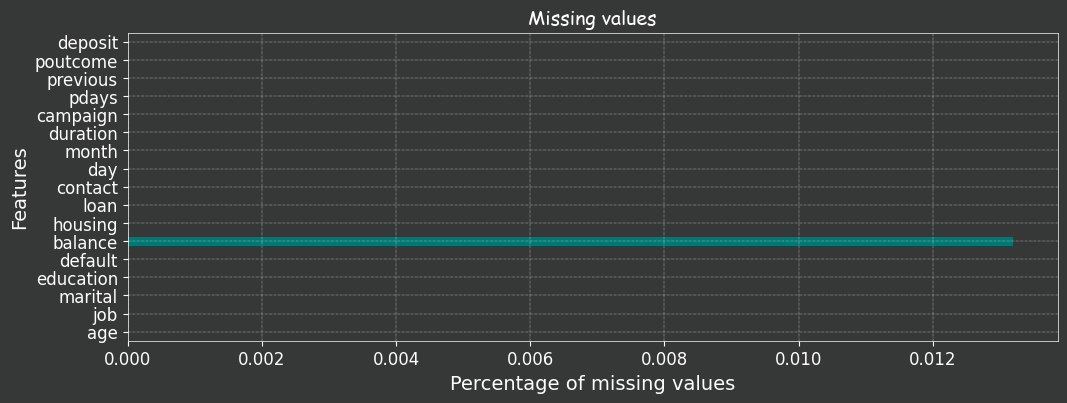

In [5]:
# визуализируем обнаруженные пропуски в признаках 
# строим фигуру и координатную плоскость
fig, ax = plt.subplots(figsize=(12,4)) 
# устанавливаем цвет фона координатной плоскости
fig.patch.set_facecolor('xkcd:dark grey')
plt.rcParams["font.family"] = "serif"
ax.set_facecolor('#363737')
# строим столбчатую диаграмму 
total_missing.plot.barh(color='#007974')
ax.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
# название графика
ax.set_title('Missing values', fontsize=14, color = '#fdfdfe',fontname = 'Comic Sans MS') 
# название оси x
ax.set_xlabel('Percentage of missing values', fontsize=14, color = '#fdfdfe') 
# название оси y
ax.set_ylabel('Features', fontsize=14, color = '#fdfdfe'); 
ax.tick_params(axis='y', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax.tick_params(axis='x', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax.grid(color='#c5c9c7',linestyle='-.', linewidth=0.3)
plt.show();


Признак `balance` содержит несущественное количество пропущенных значений по отношению к общему количеству записей

#### Узнаем какие типы данных представлены в датасете и вычислим количество уникальных значений по каждому признаку

In [3]:
# признак, количество уникальных значений, тип данных признака
unique_list = [(col, df[col].nunique(), df[col].dtypes) for col in df.columns]
unique_counts = pd.DataFrame(unique_list, columns=['column_name', 'unique_count', 'data_type']).sort_values(by='unique_count', ignore_index=True)
print('Уникальные значения и типы данных:')
unique_counts

Уникальные значения и типы данных:


column_name  unique_count data_type
0      deposit             2    object
1         loan             2    object
2      housing             2    object
3      default             2    object
4      contact             3    object
5      marital             3    object
6     poutcome             4    object
7    education             4    object
8          job            12    object
9        month            12    object
10         day            31     int64
11    previous            34     int64
12    campaign            36     int64
13         age            76     int64
14       pdays           472     int64
15    duration          1428     int64
16     balance          3802    object

Отметим, что подавляющее количество признаков являются строковыми, среди которых:   
* `бинарные` - deposit, loan, housing, defult
* `порядковые` - education, poutcome
* `номинальные` - contact, marital, job, month

### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

Пропущенные значения в признаке `job` обозначены как `unknown`

### Задание 3

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# удалим лишние символы и пробелы в строкax и преобразуем в тип данных float
df['balance']= df['balance'].str.replace(r"[\s$]|,\d+", "", regex=True)
df['balance'] = [float(i) for i in df['balance']]
print('Среднее значение по признаку {} до заполнения пропусков {}'.format('balance', np.round(df['balance'].mean(),3)))

Среднее значение по признаку balance до заполнения пропусков 1529.129


### Задание 4

In [7]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку

df['balance'] = df['balance'].fillna(df['balance'].median())
df['balance'].isnull().sum()
print('Среднее значение по признаку {}  после заполнения пропусков {}'.format('balance', np.round(df['balance'].mean(),3)))


Среднее значение по признаку balance  после заполнения пропусков 1526.936


### Задание 5

In [8]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения


print('Модальное значение признака job: {}'.format(df['job'].mode()[0]))
df['job'] = [(df['job'].mode()[0]) if x == 'unknown' else x for x in df['job']] 


print('Модальное значение признака education: {}'.format(df['education'].mode()[0]))
df['education'] = [(df.education.mode()[0]) if x == 'unknown' else x for x in df['education']]

Модальное значение признака job: management
Модальное значение признака education: secondary


In [9]:
# рассчитаем средний баланс клиентов, занятых в менеджменте и имеющих высшее образование
print('Cредний баланс клиентов, занятых в менеджменте и с высшим образованием: ',  \
      np.round(df[(df['job'] == 'management') & (df['education'] == 'secondary')]['balance'].mean(),3))

Cредний баланс клиентов, занятых в менеджменте и с высшим образованием:  1598.883


### Задание 6

#### Визуализируем распределение данных в признаке balance, построив гистограмму и коробчатую диаграмму

In [12]:
# настроим отображение осей графиков seaborn
sns.set_context('notebook')

Распределение признака balance


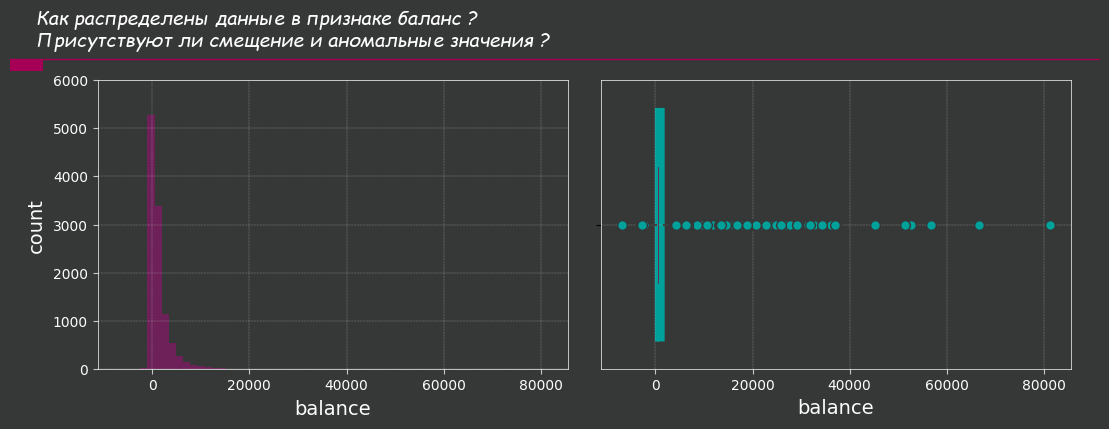

In [10]:
# строим фигуру и координатную плоскость

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(11,4))

# устанавливаем цвет фона фигуры
fig.patch.set_facecolor('xkcd:dark grey')

# строим гистограмму признака
ax1 = sns.distplot(x=df['balance'], 
                   kde=False, 
                   bins=60, 
                   ax=ax[0], 
                   color = '#c2008c')
ax1.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax1.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
ax1.set_ylabel('count', fontsize=14, labelpad=5, color = '#fdfdfe')
ax1.set_xlabel('balance', fontsize=14, labelpad=5, color = '#fdfdfe')
ax1.tick_params(axis='y',color = '#c5c9c7', labelsize=10, labelcolor = '#fdfdfe')
ax1.tick_params(axis='x',color = '#c5c9c7', labelsize=10, labelcolor = '#fdfdfe')
ax1.grid(color='#c5c9c7', linestyle='-.', linewidth=0.2)
ax1.set_facecolor('#363737')
ax1.set_ylim(0,6_000)


# строим коробчатую диаграмму
ax2 = sns.boxplot(data=df, 
                  x='balance', 
                  ax=ax[1], 
                  notch=True, 
                  showcaps=False,
                  flierprops={"marker": "o", 
                              "markerfacecolor":'#00a19b',
                              "linewidth" : .05, 
                              "markeredgecolor" : '#363737', 
                              "markersize" : 7, },
                  boxprops={"facecolor": '#00a19b',
                            "edgecolor" : '#00a19b'},
                  medianprops = {"linewidth" : .5, 
                                 "color" : '#8c0034'}
                  )
ax2.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax2.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
ax2.set_xlabel('balance', fontsize=14, color = '#fdfdfe')
ax2.set_facecolor('#363737')
ax2.tick_params(axis='x', color = '#c5c9c7', labelsize=10, labelcolor = '#fdfdfe')
ax2.grid(color='#c5c9c7', linestyle='-.', linewidth=0.2)

fig.tight_layout(pad=2.)

plt.rcParams["font.family"] = "serif"

# добавим элемент для выделения названия 
# добавлем прямоугольник
plt.gca().add_patch(
    plt.Rectangle(
        (0.01, 0.94), # координаты левого нижнего угла
        0.03, # ширина
        0.03, # высота
        facecolor = 'xkcd:violet red',
        transform = fig.transFigure,
        clip_on = False,
        linewidth = 0
    )
)

# добавляем прямую линию 
plt.gca().plot(
    [0.01, 1.], # длина линии по оси x
    [.97, .97], # координаты по оси y
    transform = fig.transFigure,
    clip_on = False,
    color = 'xkcd:violet red', 
    linewidth = 1.
)

# добавляем текст заголовка 
ax1.text(x=-24000,
         y=7150, 
         s="Как распределены данные в признаке баланс ?",
         ha='left', 
         fontsize = 14,
         fontname = 'Comic Sans MS', 
         style = 'oblique', 
         weight='normal', 
         color='#fdfdfe')

# 
ax1.text(x=-24000, 
         y=6700, 
         s='Присутствуют ли смещение и аномальные значения ?', 
         fontname = 'Comic Sans MS',
         fontsize = 14,
         style = 'oblique',  
         color='#fdfdfe');


print('Распределение признака {}'.format('balance'))

plt.show();

**`Графики показывают, что в данных присутствуют выбросы`**

* основная часть данных клиентов с положительным балансом распределена в пределах 5 тыс., отрицательного баланса до -1 тыс.
* при этом коробчатая диаграмма показывает наличие более 80 тыс.

#### Удалим выбросы с помощью **`Метода Тьюки`** (метод межквартильного размаха) в 1,5 сигмы 


In [12]:
def outliers_iqr(data, feature):
    x = data[feature]
    iqr = x.quantile(0.75) - x.quantile(0.25)
    lower_bound = x.quantile(0.25) - (iqr * 1.5)
    upper_bound = x.quantile(0.75) + (iqr * 1.5)
    outliers = data[(x<=lower_bound) | (x >= upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    
    print(f'Нижняя граница: {lower_bound}')
    print(f'Верхняя граница: {upper_bound}')
    
    return outliers, cleaned

outliers, cleaned = outliers_iqr(df, 'balance')

print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Количество признаков: {len(cleaned.columns)}')




Нижняя граница: -2241.0
Верхняя граница: 4063.0
Результирующее число записей: 10105
Число выбросов по методу Тьюки: 1058
Количество признаков: 17


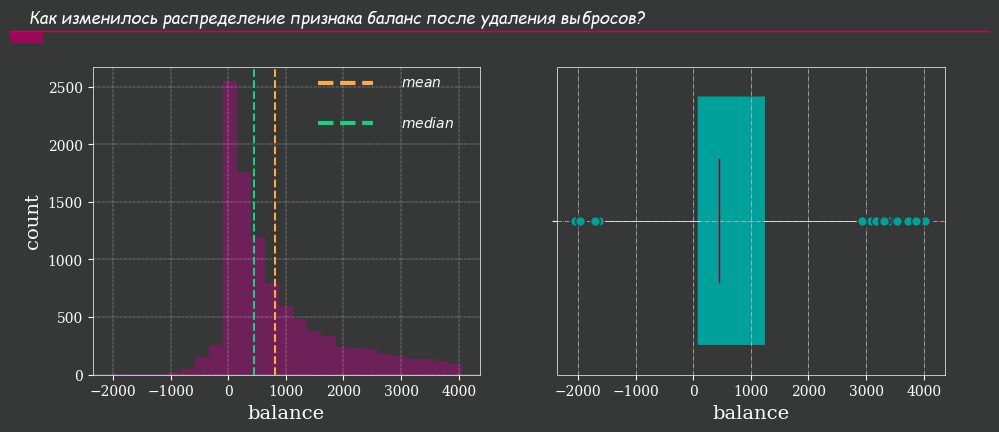

In [13]:
# Построим графики распределения после применения метода Тьюки

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(11,4))
fig.patch.set_facecolor('xkcd:dark grey') 

# установим шрифт
plt.rcParams["font.family"] = "serif"


ax1 = sns.distplot(cleaned, 
                   x=cleaned['balance'], 
                   bins=25, 
                   kde=False, 
                   ax=ax[0], 
                   color = '#c2008c')
ax1.set_ylabel('count', fontsize=14, color = '#fdfdfe')
ax1.set_xlabel('balance', fontsize=14, color = '#fdfdfe')
ax1.tick_params(axis='x', labelsize=10, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax1.tick_params(axis='y', labelsize=10, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax1.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax1.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
ax1.axvline(cleaned['balance'].mean(), color = '#fdaa48', ls = '--', alpha = 1)
ax1.axvline(cleaned['balance'].median(), color = '#18d17b', ls = '--', alpha = 1)
ax1.set_facecolor('#363737')  
ax1.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)

ax2 = sns.boxplot(data=cleaned, 
                  x=cleaned['balance'], 
                  ax=ax[1],  
                  notch=True, 
                  showcaps=False,
                  flierprops={"marker": "o", 
                              "markerfacecolor":'#00a19b',
                              "linewidth" : .05, 
                              "markeredgecolor" : '#363737', 
                              "markersize" : 7, },
                  boxprops={"facecolor": '#00a19b',
                            "edgecolor" : '#00a19b'},
                  medianprops = {"linewidth" : 1., 
                                 "color" : '#8c0034'},
                  whiskerprops = {'linestyle': 'solid', 
                                  'linewidth': 0.5, 
                                  'color': '#fdfdfe'}
                  )
                
ax2.set_xlabel('balance', fontsize=14, color = '#fdfdfe')
ax2.tick_params(axis='x', labelsize=10, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax2.tick_params(axis='y', labelsize=10, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax2.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax2.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
ax2.set_facecolor('#363737')
ax2.grid(color='#c5c9c7', linestyle='-.', linewidth=0.5)

plt.gca().add_patch(
    plt.Rectangle(
        (0.05, .94), # location
        0.03, #  width
        0.03,  #  height
        facecolor = 'xkcd:dark fuchsia',
        transform = fig.transFigure,
        clip_on = False,
        linewidth = 0
    )
)
plt.gca().plot(
    [0.05, 0.94], # x co-ords length
    [.97, .97],   # y co-ords height
    transform = fig.transFigure,
    clip_on = False,
    color = 'xkcd:deep pink',
    linewidth = 1.
)

# добавим на график среднее и медиану

plt.gca().plot(
    [0.33, 0.38], # length of line
    [.84, .84], # height
    transform = fig.transFigure,
    clip_on = False,
    color = 'xkcd:light orange',
    linestyle='--', 
    linewidth = 3
)
plt.gca().plot(
    [0.33, 0.38], # length of line
    [.74, .74], # height
    transform = fig.transFigure,
    clip_on = False,
    color = 'xkcd:seaweed',
    linestyle='--', 
    linewidth = 3
)
# Title text
ax1.text(x=3000, 
         y=2500, 
         s="$mean$", 
         size='medium',
         weight='medium', 
         color='#fdfefe');
# Title text
ax1.text(x=3000, 
         y=2150, 
         s="$median$", 
         size='medium', 
         weight='medium', 
         color='#fdfefe');

# Title text
ax1.text(x=-3450, 
         y=3050, 
         s="Как изменилось распределение признака баланс после удаления выбросов?", \
         fontname = 'Comic Sans MS', 
         style = 'oblique',
         weight='normal',
         size='large', 
         color='#fdfefe');
plt.show();

* Графики показывают, что после удаления выбросов в **1,5** **$\sigma$** в данных по-прежнему присутствуют выбросы (`верхняя граница` около 3 тыс. и `нижняя` -1,500 тыс.)
* Гистограмма распределения имеет отчетливое смещение вправо


## **`Часть 2`**:  Разведывательный анализ

### Задание 1

In [65]:
# %matplotlib inline

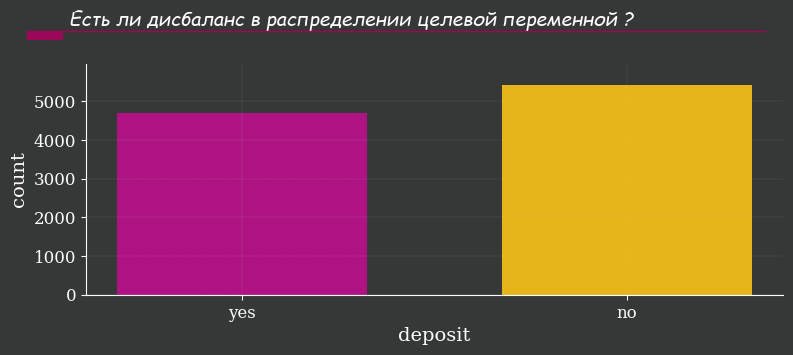

In [14]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 3))

# устанавливаем цвет фона фигуры
fig.patch.set_facecolor('xkcd:dark grey')  

# устанавливаем цвет фона координантной сетки
ax.set_facecolor('#363737')   

plt.rcParams["font.family"] = "serif"

ax = sns.countplot(data=cleaned, 
                   x='deposit', 
                   width=.65, 
                   saturation=.8,  
                   palette = ['#c2008c', '#ffc200'])  
ax.margins(y=0.1) 

ax.set_xlabel('deposit', fontsize=14, color = '#fdfdfe')
ax.set_ylabel('count', fontsize=14, color = '#fdfdfe')
ax.tick_params(axis='x', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax.tick_params(axis='y', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax.spines[['top','right']].set_linewidth(.5)
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('#fdfdfe') 
ax.grid(color='#c5c9c7', linestyle='-.', linewidth=0.1)

plt.gca().add_patch(
    plt.Rectangle(
        (0.06, .96), 
        0.04, 
        0.03, 
        facecolor = 'xkcd:dark fuchsia',
        transform = fig.transFigure,
        clip_on = False,
        linewidth = 0
    )
)

plt.gca().plot(
    [0.06, .88],
    [.99, .99], 
    transform = fig.transFigure,
    clip_on = False,
    color = 'xkcd:dark fuchsia', 
    linewidth = 1.
)

ax.text(x=-0.45, 
        y=6950, 
        s="Есть ли дисбаланс в распределении целевой переменной ?", 
        fontname = 'Comic Sans MS', 
        fontsize = 14, 
        style = 'oblique',
        weight='normal', 
        color='#fdfdfe');

    
plt.show()

График показывает наличие дисбаланса целевой переменной, следовательно при разбиении данных нам необходимо учитывать данный факт

### Задания 2 и 3

Green vertical line - mean value 
Yellow vertical line - median value


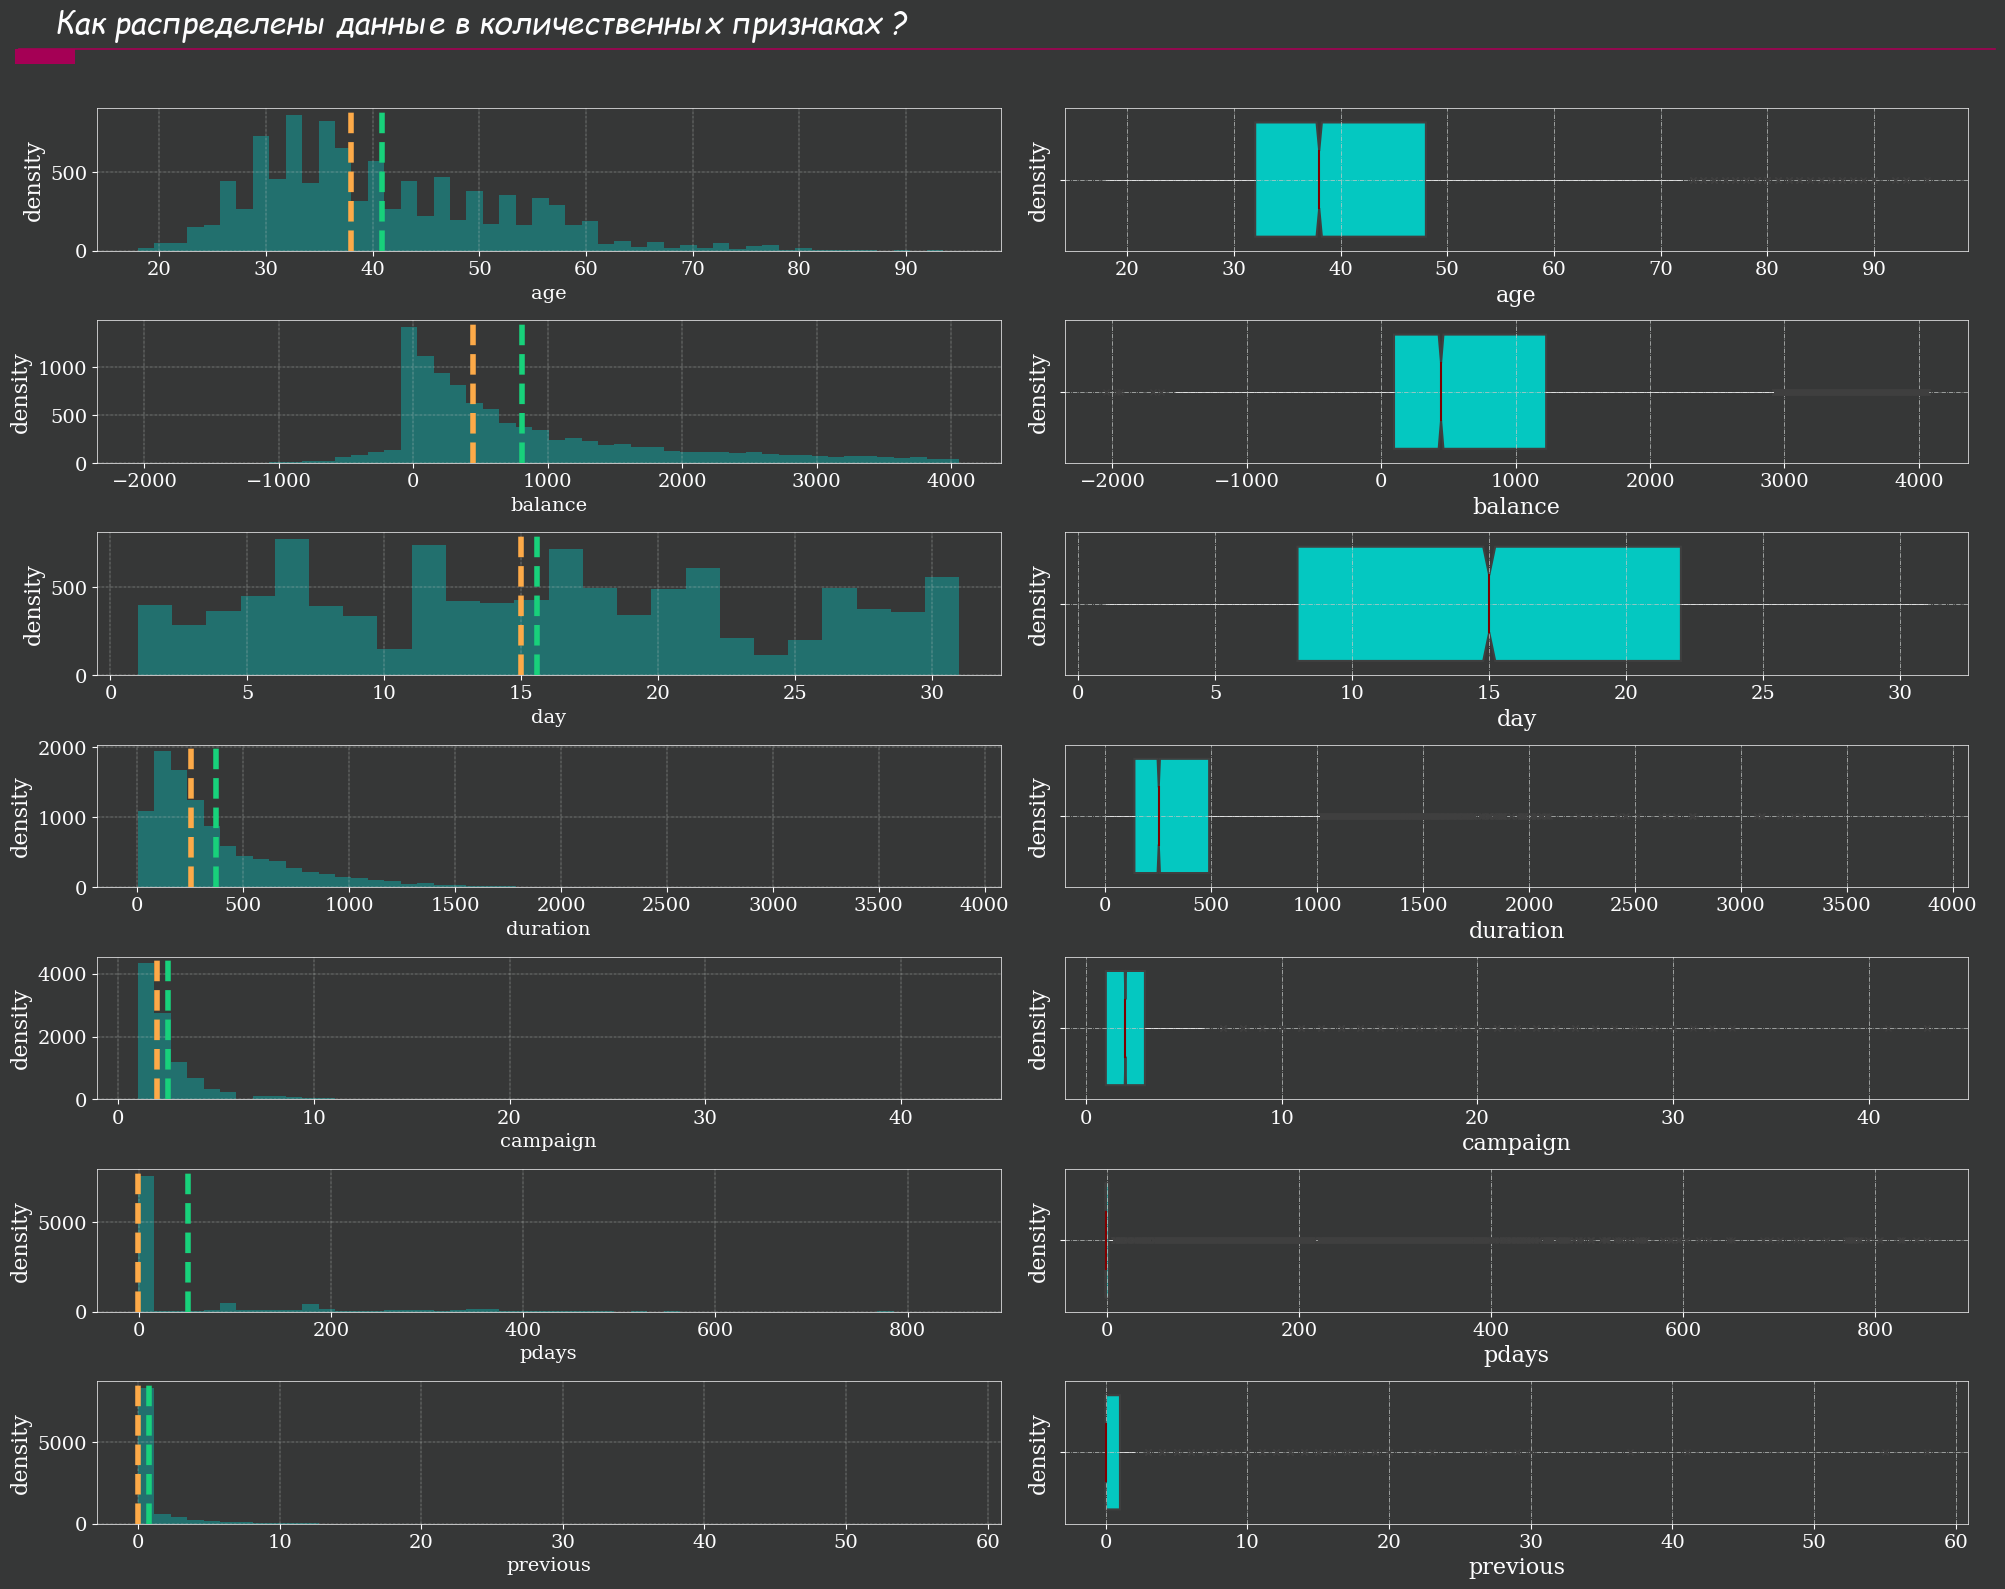

In [16]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат

# Взглянем как распределены данные в количественных переменных
# визуализируем их с помощью гистограмы и боксплота

# выберем только числовые признаки 
num = [x for x in cleaned.columns if cleaned[x].dtypes !='object'] 

# установим количество строк для функции plt.subplots()
row = len(num) 

# установим количество столбцов для функции plt.subplots()
col = 2        

# инициализируем счетчик графиков
cnt = 1          


# строим фигуру
fig = plt.figure(figsize = (20,15))
fig.patch.set_facecolor('xkcd:dark grey') 

plt.rcParams["font.family"] = "serif"


# пройдем в цикле по каждому признаку списка num и строим сначала гистограмму распределения
for i in num:
    ax = fig.add_subplot(row, col, cnt)
    ax.set_facecolor('#363737')
    sns.distplot(cleaned[i],
                 kde=False, 
                 color = '#04c8c1') 
    plt.axvline(cleaned[i].mean(), linewidth=4, color = '#18d17b', ls = '--', alpha = 1)
    plt.axvline(cleaned[i].median(), linewidth=4, color = '#fdaa48', ls = '--', alpha = 1)
    ax.set_xlabel(i, fontsize=14, color = '#fdfdfe')
    ax.set_ylabel('density', fontsize=16, color = '#fdfdfe')
    ax.tick_params(axis='x', labelsize=14, color = '#fdfdfe', labelcolor = '#fdfdfe')
    ax.tick_params(axis='y', labelsize=14, color = '#fdfdfe', labelcolor = '#fdfdfe')
    ax.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
    ax.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
    ax.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)
    
    cnt = cnt+1
# строим боксплот
    ax = fig.add_subplot(row, col, cnt)
    ax.set_facecolor('#363737')
    sns.boxplot(data = cleaned[num], 
                x = i,
                notch=True, 
                showcaps=False,
                flierprops={"marker": "x"},
                boxprops={"facecolor": '#04c8c1'},
                medianprops={"color": "maroon"},
                whiskerprops = {'linestyle': 'solid', 
                                'linewidth': 0.5, 
                                'color': '#fdfdfe'}) 
    ax.set_xlabel(i, fontsize=16, color = '#fdfdfe' )
    ax.set_ylabel('density', fontsize=16, color = '#fdfdfe') 
    ax.tick_params(axis='x', labelsize=14, color = '#fdfdfe', labelcolor = '#fdfdfe')
    ax.tick_params(axis='y', labelsize=14, color = '#fdfdfe', labelcolor = '#fdfdfe')
    ax.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
    ax.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
    ax.grid(color='#c5c9c7', linestyle='-.', linewidth=0.5)
    
    cnt = cnt+1
    
fig.tight_layout(pad=1.05, h_pad = 1)

# для наглядности добавим на график гистограммы среднее и медиану
print('Green vertical line - mean value \nYellow vertical line - median value')

# модифицируем заголовок графика с помошью прямоугольника и прямой линии
plt.gca().add_patch(
    plt.Rectangle(
        # строим прямоугольник с координатами xy
        (0.01, 1.02), 
        # задаем ширину прямоугольника
        0.03, 
        # задаем высоту прямоугольника
        0.01, 
        # задаем цвет прямоугольника
        facecolor = 'xkcd:violet red',
        transform = fig.transFigure,
        clip_on = False,
        linewidth = .2
    )
)   
# строим горизонтальную линию 
plt.gca().plot(
    # задаем координаты начала и конца по оси x
    [0.012, 1.], 
    # задаем координаты высоты по оси y 
    [1.03, 1.03], 
    transform = fig.transFigure,
    clip_on = False,
    #color = 'tab:salmon', # цветовая палитра Tableu
    color = 'xkcd:violet red', # RGB monitor colors
    linewidth = 1.2
)

# добавляем текстовые данные
fig.text(x=0.03, 
        y=1.04, 
        s="Как распределены данные в количественных признаках ?", 
        fontname = 'Comic Sans MS', 
        style = 'italic',
        weight='normal',
        fontsize=22,
        ha = 'left', 
        transform = fig.transFigure,
        color='#fdfdfe');


plt.show()


* Признак **`age`**:
    * среднее признака `age` составляет примерно 41 год, медиана 38 лет
    * размах значений возраста составляет 77 лет от минимального 18 лет до максимального в 95 лет
    * стандартное отклонение равно 12.7 лет 
* Признак **`balance`**   
    * среднее признака `balance` равного 807 и медианы равной 445 свидетельствует о правосторонней ассиметрии  
    * размах значений признака равен 6112 при этом минимальное значение -2049, а максимальная сумма на счету клиента составляет 4063
    * стандартное отклонение равно 994$
* Признак **`day`** 
    * среднее признака равно 15 и медиана 15 
    * размах значений составляет 30 соответственно от минимального 1 до максимального 31 
    * стандартное отклонение равно 8 дней
    статистика признака day говорит нам, что контакты с клиентами осуществлялись в течении месяца, однако неравномерно, большая часть контактов приходилась на середину месяца
* Признак **`duration`**
    * среднее признака равно 368 и медиана 252 свидетельствует о правосторонней ассиметрии  
    * размах значений составляет 3879 секунд минимальная продолжительность равна 2 секунды, а максимальная 3881
    * стандартное отклонение около 347 секунд
    *  в признаке длительности контакта `duration` среднее больше значения медианы поскольку максимальное время общения составляет около 80 минут в то время как минимальное значение всего 2 секунды 
* Признак **`campaign`** 
    * среднее значение 2.5 и медиана -1 
    * размах равен примерно 42 минимальное значение 1 и максимальное 43
    * стандартное отклонение 2.7
    * количество контактов в течении текущей компании `campaign` в среднем составляет 2 раза, минимальное количество контактов составляет 1 контакт, а максимальное количество 43 контакта, что выглядит подозрительно навязчивым   
* Признак **`pdays`** 
    * среднее значение признака 0.8 и медиана 0 
    * размах равен 853 минимальное значение -1 и максимальное 854
    * стандартное отклонение 109 
    * количество дней между контактами в предыдущей и текущей маркетинговой кампании `pdays` в среднем составляет 51 день, тем не менее медиана признака равна -1 день, что, вероятно, можно трактовать как отсутствие перерыва между контактами во время проведения кампаний, максимальное значение в 854 дня или чуть более 2-х лет выглядит сомнительно

### Задания 4 и 5

Попробуйте извлечь максимум информации из тех показателей, которые можете получить. Сколько всего сфер занятости представлено среди клиентов банка? В каждый ли месяц проходила маркетинговая кампания? Какое семейное положение встречается чаще всего? А образование? Постарайтесь дать достаточно подробную интерпретацию. Для лучшей наглядности добавьте визуализации по каждой категориальной переменной.

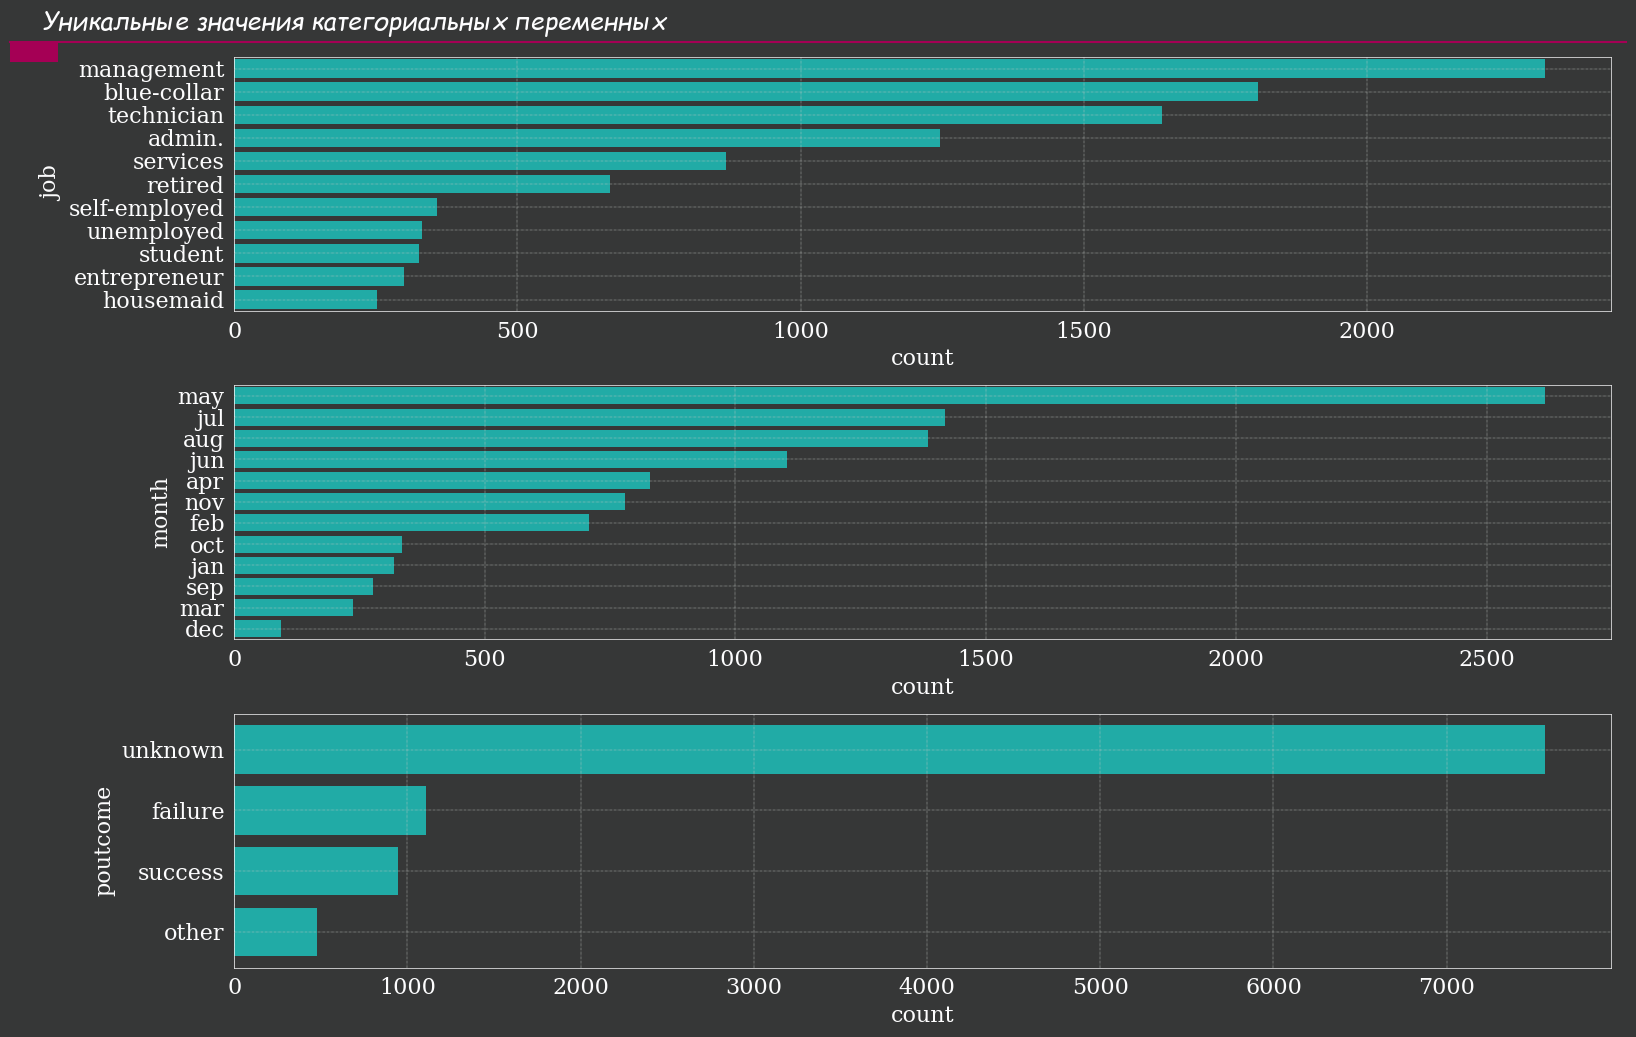

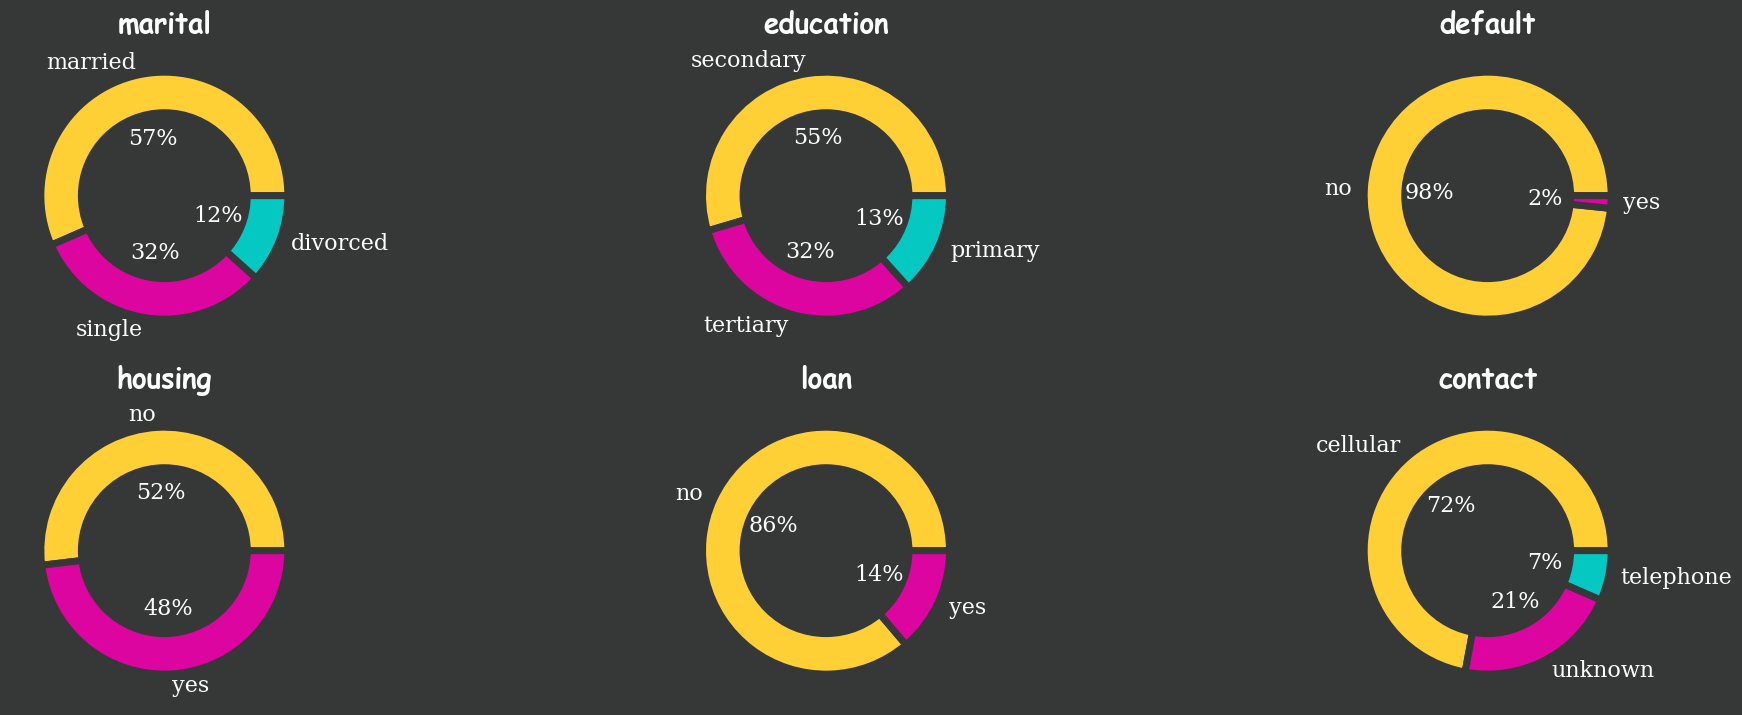

In [18]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#постройте визуализации, иллюстрирующие результаты


# создаем список категориальных признаков с количеством уникальных значений больше 4
cat_sample = [x for x in cleaned.columns if (cleaned[x].dtypes == 'object') & (cleaned[x].nunique() >= 4)]
# установим количество строк для функции plt.subplots
row = len(cat_sample) 
# установим количество столбцов для функции plt.subplots
col = 1                
# инициализируем счетчик графиков
cnt = 1                 

fig  = plt.figure(figsize = (16,10))
fig.patch.set_facecolor('xkcd:dark grey') 

for i in cat_sample:
    
    ax = fig.add_subplot(row, col, cnt)
    ax.set_facecolor('#363737')
    sns.barplot(x = cleaned[i].value_counts(), 
                y = cleaned[i].value_counts().index, 
                data=cleaned[cat_sample], 
                saturation = .7,              
                orient = 'h', 
                color='#04c8c1')
                
    
    ax.set_xlabel('count', fontsize=16, color = '#fdfdfe')
    ax.set_ylabel(i, fontsize=16, color = '#fdfdfe') 
    ax.tick_params(axis='x', labelsize=16, color = '#363737', labelcolor = '#fdfdfe')
    ax.tick_params(axis='y', labelsize=16, color = '#363737', labelcolor = '#fdfdfe')
    ax.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
    ax.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
    ax.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)
    
    
    cnt = cnt+1
    
fig.tight_layout()


plt.gca().add_patch(
    plt.Rectangle(
        (-0.01, .98), 
        0.03, 
        0.02, 
        facecolor = 'xkcd:violet red',
        transform = fig.transFigure,
        clip_on = False,
        linewidth = 0
    )
)

plt.gca().plot(
    [-0.01, 1.], 
    [1., 1.],
    transform = fig.transFigure,
    clip_on = False,
    color = 'xkcd:violet red', 
    linewidth = 1.5
)

plt.text(
    x = 0.01, 
    y = 1.012, 
    s = 'Уникальные значения категориальных переменных',
    fontname = 'Comic Sans MS', 
    fontsize = 18,
    style = 'oblique',
    weight='normal',
    ha = 'left',
    color='#fdfdfe',
    transform = fig.transFigure)

plt.show();

# создаем список категориальных признаков с количеством уникальных значений меньше и равно 4
cat_uniq = [x for x in cleaned.columns if (cleaned[x].dtypes == 'object') & (cleaned[x].nunique() < 4)]
data = cleaned[cat_uniq].drop('deposit', axis=1) # удалим целевой признак


row = len(cat_uniq) # установим количество строк для функции plt.subplots
col = 3             # установим количество столбцов для функции plt.subplots
cnt = 1             # инициализируем счетчик графиков

colors = ['#ffcf36','#dc05a0','#04c8c1','#2ccec8']  # задаем цвета для секторов круговой диаграммы  #007B81 


fig  = plt.figure(figsize = (20,25))
#plt.suptitle('Категориальные признаки', fontsize=27)
fig.patch.set_facecolor('xkcd:dark grey') 

for i in data.columns:
    ax = fig.add_subplot(row, col, cnt)
    ax.set_facecolor('#363737')
    plt.pie(x = data[i].value_counts(), 
            labels = data[i].value_counts().index,
            textprops={'fontsize': 16, 
                    "color" : '#fdfdfe'} , 
            wedgeprops = {'linewidth':5.0,'edgecolor':'#363737'},
            data = data,
            pctdistance=0.47, 
            autopct='%.f%%',
            colors = colors)
    plt.title(i,fontsize = 20, weight = 'bold', color='#fdfdfe', fontname = 'Comic Sans MS')
    centre_circle = plt.Circle((0, 0), 0.70, fc='#363737')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    cnt = cnt+1

fig.tight_layout()

plt.show();


In [22]:
print('Основные описательные статистики категориальных признаков')

cleaned.describe(include = 'object').T.style.background_gradient(subset = ['unique', 'freq'], 
                                                                 cmap='Spectral', 
                                                                 vmin=1, 
                                                                 vmax=10000)

Основные описательные статистики категориальных признаков


Итак, сфера занятости представлена 11-ю уникальными значениями, при этом подавляющая часть клиентов занята в сфере менеджмента, на втором месте по представленности 'синиие воротниички', замыкает тройку техники. На графике отчетливо выделяются в одну группу самозанятые, безработные, студенты, предприниматели и домохозяева, которая наименее представлена в данных. 
* Наиболее активно маркетинговая кампания проводилась в мае, в летние месяцы активность снижается почти вдвое, наименее активна кампания в декабре, что, вероятно, объясняется подготовкой к праздникам.
* Более половины клиентов 53% имеют среднее образование, то есть закончили только школу, 33 % имеют высшее образование
* Замужем или женаты 56% клиентов
* Имеют ипотечный кредит 47 % клиентов 
* Большая часть клиентов не брала кредит на личные нужды и не имеет просрочек по обязательным платежам, поскольку от этого зависит кредитный рейтинг, а значит более выгодные условия кредитования
* Основной способ связи 72% контактов - личный сотовый телефон, в то время как 21 % контактов обозначен как неизвестный способ контакта, менее 7 %  контактов домашний телефон 
Самое представленное значение признака  `poutcome` 74% обозначен как неизвестный (вероятно, клиент не смог в моменте принять решение) 

### Задание 6

In [23]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

result = pd.pivot_table(cleaned, index='deposit', columns='poutcome', aggfunc='size')
display(result) 

poutcome  failure  other  success  unknown
deposit                                   
no            562    216       84     4562
yes           547    265      861     3008

### Задание 7

In [24]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

no_deposit = cleaned[cleaned.deposit == 'no'].groupby(['month'])['deposit'].count()

# сгруппируем данные по месяцам и депозиту и посчитаем общее количество записей
month = cleaned.groupby(['month'])['deposit'].count()

# разделим количество записей с отказом от депозита на общее количество записей по данному признаку и получим % отказов по каждому месяцу

no_deposit_pct = no_deposit/month*100

print('В каком месяце чаще всего отказывались от открытия депозита:\n',np.round(no_deposit_pct.sort_values(ascending=False)))

В каком месяце чаще всего отказывались от открытия депозита:
 month
may    68.0
jan    61.0
jul    59.0
nov    58.0
aug    56.0
jun    55.0
feb    46.0
apr    38.0
oct    19.0
sep    17.0
mar    10.0
dec    10.0
Name: deposit, dtype: float64


Мы получили количество  отказов (в %) в каждом месяце от предложения открыть депозит, но данные неупорядочены по месяцам года. Поэтому построим график, который покажет период - от января до декабря с количеством положительных и негативных исходов

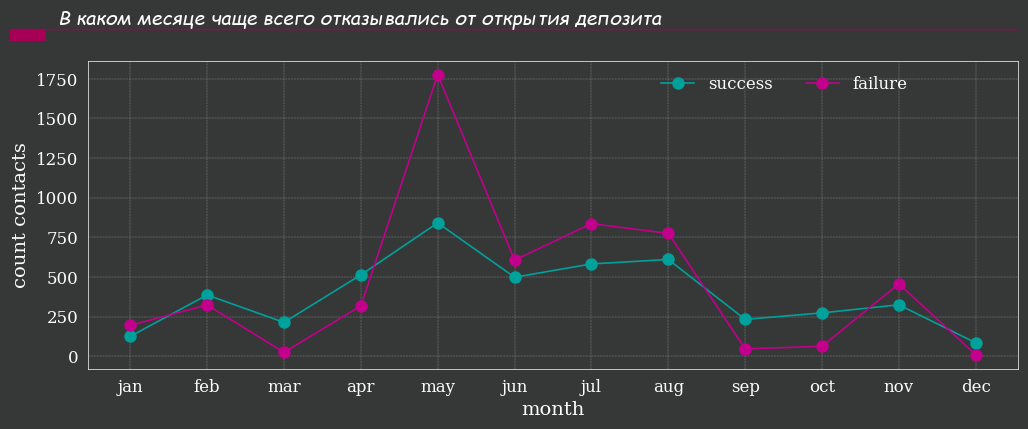

In [25]:
# построим сводную таблицу из двух признаков - месяца и депозита
month_dep = pd.pivot_table(cleaned, index='month', columns='deposit', aggfunc='size')
# создадим список месяцев года
sorted_months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
# изменим индекс на сортированный список месяцев
month_dep = month_dep.reindex(sorted_months, axis=0)

# создадим два образца - положительный и негативный итог контакта
df_yes = month_dep['yes'].reset_index()
df_no = month_dep['no'].reset_index()


# создаем объект фигуры и задаем размер
fig, ax = plt.subplots(figsize=(12,4))

fig.patch.set_facecolor('xkcd:dark grey')
ax.set_facecolor('#363737')

plt.rcParams["font.family"] = "serif"
# строим линейный график
sns.lineplot(data=df_yes, 
             x='month', 
             y='yes', 
             linewidth = 1.2,
             color ='#00a19b', 
             label='success',
             marker = 'o',
             markersize=8,
             markeredgecolor = '#00a19b',
             markeredgewidth = 1.
             )
# график негативного результата
sns.lineplot(data=df_no, 
             x='month', 
             y='no', 
             linewidth = 1.2,
             color = '#c2008c',
             label='failure',
             marker = 'o',
             markersize=8,
             markeredgecolor = '#c2008c',
             markeredgewidth = 1.
             )


plt.gca().add_patch(
    plt.Rectangle(
        (0.06, .93), 
        0.03, 
        0.03, 
        facecolor = 'xkcd:violet red',
        transform = fig.transFigure,
        clip_on = False,
        linewidth = 0
    )
)

plt.gca().plot(
    [0.06,.9], 
    [.96, .96], 
    transform = fig.transFigure,
    clip_on = False,
    color = 'xkcd:violet red', 
    linewidth = 1.
)
plt.text(
    x = 0.1, 
    y = .97, 
    s = 'В каком месяце чаще всего отказывались от открытия депозита',
    fontname = 'Comic Sans MS',
    fontsize = 14,
    style = 'oblique',
    weight='medium',
    ha='left',
    color='#fdfdfe',
    transform = fig.transFigure
)

ax.set_xlabel('month', fontsize=14, color = '#fdfdfe')
ax.set_ylabel('count contacts', fontsize=14, color = '#fdfdfe') 
ax.tick_params(axis='x', labelsize=12, color = '#363737', labelcolor = '#fdfdfe')
ax.tick_params(axis='y', labelsize=12, color = '#363737', labelcolor = '#fdfdfe')
ax.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
ax.grid(color='#c5c9c7', linestyle='-.', linewidth=0.2)
plt.legend(bbox_to_anchor =(0.6, 1.), frameon = False, facecolor = '#363737', fontsize=12, labelcolor = '#fdfdfe', ncol = 2)
plt.show();

Как мы узнали ранее самый активный период маркетинговой кампании это - май - август, именно в данный отрезок было совершено подавляющее количество контактов с клиентами. Однако, именно в эти месяцы количество отказов превышает количество положительных результатов. Мы видим месяцы, когда клиенты соглашались больше, чем отказывались, в первом полугодии - это февраль и март, а во втором - сентябрь и половина октября, когда количество контактов было меньше.

Рассмотрим внимательнее признак продолжительности контакта - `duration`  
Визуализируем его распределение в группах значений признака `deposit` 

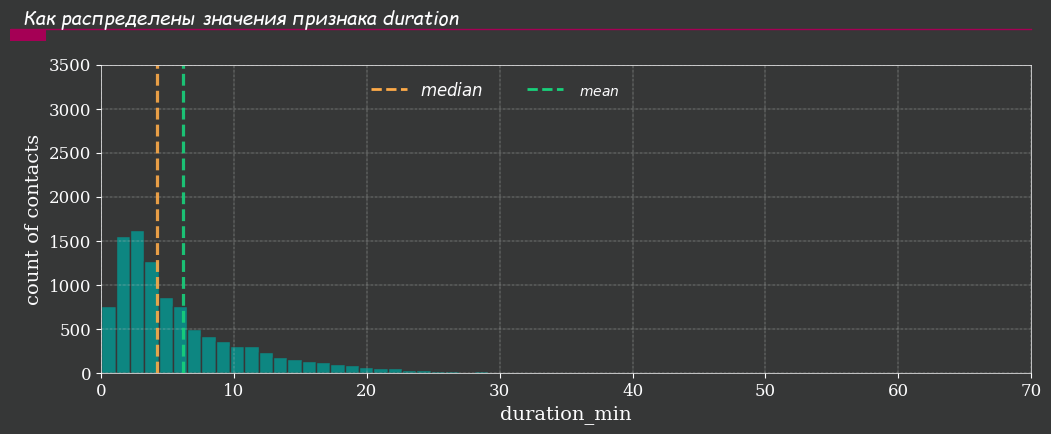

In [27]:
# создадим временный признак продолжительности контакта в минутах
cleaned.loc[:, 'duration_min'] = [np.round((x/60),1) for x in cleaned['duration']]
# присоединим к данному признаку столбец целевой переменной deposit
sample = cleaned['duration_min']
con_sample = pd.concat([cleaned['duration_min'],cleaned['deposit']], axis=1)

# построим гистограмму распределения таргета в зависимости от продолжительности контакта
# Строим фигуру и координатную плоскость
fig, ax = plt.subplots(figsize=(12,4))

fig.patch.set_facecolor('xkcd:dark grey')
ax.set_facecolor('#363737')


# Строим гистограмму распределения
sns.histplot(data=con_sample, 
             x='duration_min',
             edgecolor = '#363737', 
             element = 'bars',
             bins=60,
             color = '#00a19b')
             
ax.set(xlim = (0,70), ylim = (0,3500))



# добавим медиану и среднее
ax.axvline(con_sample['duration_min'].mean(), 
           color = '#18d17b',  
           ls = '--', 
           linewidth= 2.3,
           alpha = 0.9)
ax.axvline(con_sample['duration_min'].median(), 
           color = '#fdaa48',  
           ls = '--', 
           linewidth = 2.3,
           alpha = 0.9)



plt.gca().add_patch(
    plt.Rectangle(
        (0.049, .94),
        0.03, 
        0.03, 
        facecolor = 'xkcd:violet red',
        transform = fig.transFigure,
        clip_on = False,
        linewidth = 0
    )
)

plt.gca().plot(
    [0.05, .9], 
    [.97, .97], 
    transform = fig.transFigure,
    clip_on = False,
    color = 'xkcd:violet red', 
    linewidth = 1.
)
plt.text(
    x = .06, 
    y = .98, 
    s = 'Как распределены значения признака duration',
    fontname = 'Comic Sans MS',
    fontsize = 14,
    style = 'oblique',
    weight='medium',
    ha='left',
    color='#fdfdfe',
    transform = fig.transFigure
)



plt.gca().plot(
    [0.35, 0.38], 
    [.82, .82], 
    transform = fig.transFigure,
    clip_on = False,
    color = 'xkcd:light orange',
    linestyle='--', 
    linewidth = 2.
)
plt.gca().plot(
    [0.48, 0.51], 
    [.82, .82], 
    transform = fig.transFigure,
    clip_on = False,
    color = 'xkcd:seaweed',
    linestyle='--', 
    linewidth = 2.
)
# 
ax.text(x=36, 
        y=3150, 
        s="$mean$", 
        size='medium',
        weight='normal', 
        color='#fdfdfe');
# 
ax.text(x=24, 
        y=3150, 
        s="$median$", \
        weight='normal', 
        size = 'large', 
        color='#fdfdfe');

ax.set_xlabel('duration_min', fontsize=14, color = '#fdfdfe')
ax.set_ylabel('count of contacts', fontsize=14, color = '#fdfdfe') 
ax.tick_params(axis='x', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax.tick_params(axis='y', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
ax.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)
plt.show();


График распределения демонстрирует смещение медианы влево, а следовательно дает основания для предположения о присутствии аномальных значений

Рассмотрим признак длительности совместно с целевой переменной 

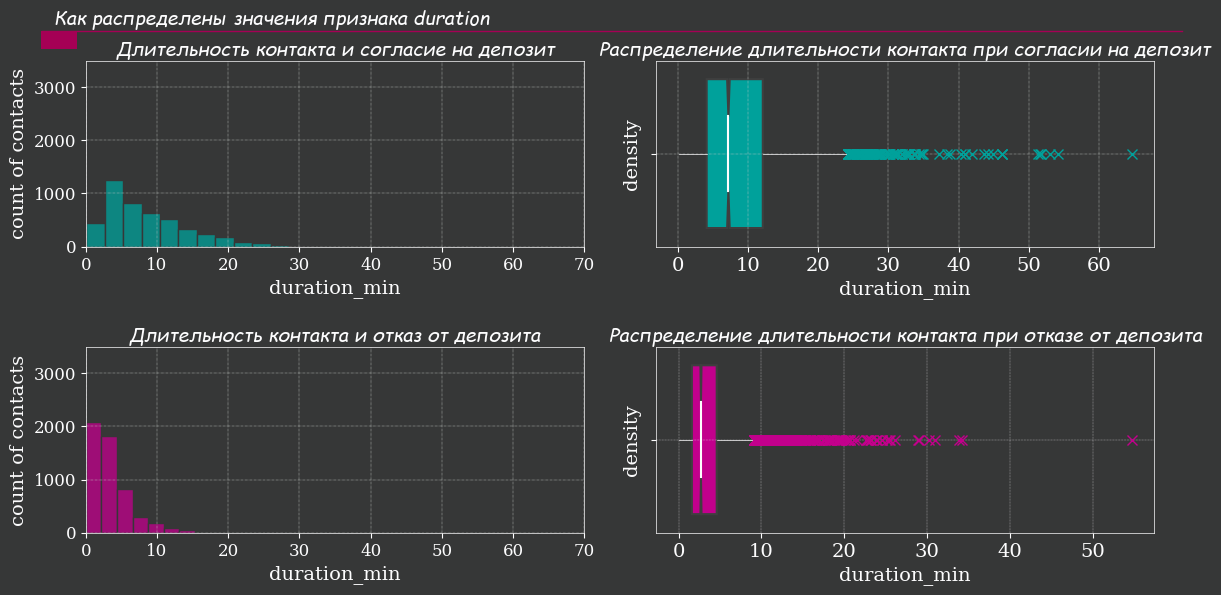

In [29]:
# разделим объединенные признаки по значениям целевого признака и отсортируем их по признаку длительности контакта в минутах

deposit_pos = con_sample[con_sample['deposit']=='yes'].sort_values(by='duration_min', ascending=True)
deposit_neg = con_sample[con_sample['deposit']=='no'].sort_values(by='duration_min', ascending=True)


# построим гистограмму распределения таргета в зависимости от продолжительности контакта
# Строим фигуру и координатную плоскость
fig, ax = plt.subplots(2,2,figsize=(12,6))
fig.patch.set_facecolor('xkcd:dark grey') # dark grey


# Строим гистограммы распределения
ax1 = sns.histplot(data=deposit_pos, 
                   x='duration_min',
                   edgecolor = '#363737', 
                   element = 'bars',
                   bins=25,
                   ax=ax[0, 0],
                   color = '#00a19b')
             
ax1.set(xlim = (0,70), ylim = (0,3500))
ax1.set_title("Длительность контакта и согласие на депозит", 
              fontname = 'Comic Sans MS',
              fontsize = 14,
              style = 'oblique',
              weight='medium',
              color='#fdfdfe',
              pad=.1)        
ax1.set_xlabel('duration_min', fontsize=14, color = '#fdfdfe')
ax1.set_ylabel('count of contacts', fontsize=14, color = '#fdfdfe') 
ax1.tick_params(axis='x', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax1.tick_params(axis='y', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax1.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax1.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
ax1.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)
ax1.set_facecolor('#363737') #00035b #363737

ax2 = sns.histplot(data=deposit_neg, 
                   x='duration_min',
                   edgecolor = '#363737', 
                   element = 'bars',
                   bins=25,
                   ax=ax[1,0],
                   color = "#c2008c")
ax2.set_title("Длительность контакта и отказ от депозита", 
              fontname = 'Comic Sans MS',
              fontsize = 14,
              style = 'oblique',
              weight='medium',
              color='#fdfdfe',
              pad=.1)             
ax2.set(xlim = (0,70), ylim = (0,3500))
ax2.set_xlabel('duration_min', fontsize=14, color = '#fdfdfe')
ax2.set_ylabel('count of contacts', fontsize=14, color = '#fdfdfe') 
ax2.tick_params(axis='x', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax2.tick_params(axis='y', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax2.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax2.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
ax2.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)
ax2.set_facecolor('#363737')

# Строим коробчатые диаграммы 
ax3 = sns.boxplot(data = deposit_pos, 
                x = deposit_pos['duration_min'],
                notch=True, 
                showcaps=False,
                ax=ax[0,1],
                flierprops={"marker": "x",
                            "markeredgecolor":'#00a19b',
                            "markersize" : 7},
                boxprops={"facecolor": '#00a19b'},
                medianprops={"color": '#fdfdfe'},
                whiskerprops = {'linestyle': 'solid', 
                                'linewidth': 0.5, 
                                'color': '#fdfdfe'}) 
ax3.set_title("Распределение длительности контакта при согласии на депозит", 
              fontname = 'Comic Sans MS',
              fontsize = 14,
              style = 'oblique',
              weight='medium',
              color='#fdfdfe',
              pad=.1)
ax3.set_xlabel('duration_min', fontsize=14, color = '#fdfdfe' )
ax3.set_ylabel('density', fontsize=14, color = '#fdfdfe') 
ax3.tick_params(axis='x', labelsize=14, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax3.tick_params(axis='y', labelsize=14, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax3.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax3.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
ax3.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)
ax3.set_facecolor('#363737')

ax4 = sns.boxplot(data = deposit_neg, 
                x = deposit_neg['duration_min'],
                notch=True, 
                showcaps=False,
                ax=ax[1,1],
                flierprops={"marker": "x",
                            "markeredgecolor":"#c2008c",
                            "markersize" : 7},
                boxprops={"facecolor": "#c2008c"},
                medianprops={"color": '#fdfdfe'},
                whiskerprops = {'linestyle': 'solid', 
                                'linewidth': 0.5, 
                                'color': '#fdfdfe'}) 
ax4.set_title("Распределение длительности контакта при отказе от депозита", 
              fontname = 'Comic Sans MS',
              fontsize = 14,
              style = 'oblique',
              weight='medium',
              color='#fdfdfe',
              pad=.1)
ax4.set_xlabel('duration_min', fontsize=14, color = '#fdfdfe' )
ax4.set_ylabel('density', fontsize=14, color = '#fdfdfe') 
ax4.tick_params(axis='x', labelsize=14, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax4.tick_params(axis='y', labelsize=14, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax4.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax4.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
ax4.grid(color='#fdfdfe', linestyle='-.', linewidth=0.2) #c5c9c7
ax4.set_facecolor('#363737')

fig.tight_layout(pad=2)

# Декорируем отображение графиков
plt.gca().add_patch(
    plt.Rectangle(
        (0.049, .94),
        0.03, 
        0.03, 
        facecolor = 'xkcd:violet red',
        transform = fig.transFigure,
        clip_on = False,
        linewidth = 0
    )
)

plt.gca().plot(
    [0.05, 1.], 
    [.97, .97], 
    transform = fig.transFigure,
    clip_on = False,
    color = 'xkcd:violet red', 
    linewidth = 1.
)
plt.text(
    x = .06, 
    y = .98, 
    s = 'Как распределены значения признака duration',
    fontname = 'Comic Sans MS',
    fontsize = 14,
    style = 'oblique',
    weight='medium',
    ha='left',
    color='#fdfdfe',
    transform = fig.transFigure
)

plt.show();


Как показывает коробчатая диаграмма, в данных медиана смещена, следовательно признак duration содержит аномальные значения за пределами межквартильного размаха.
* Длительность контакта с клиентами, открывшими депозит как показывают графики распределения  продолжительнее в сравнении с продолжительностью контакта с клиентами, которые отказались от депозита. Данное наблюдение не доказывает зависимость между признаком duration и целевой переменной  

### Задание 8

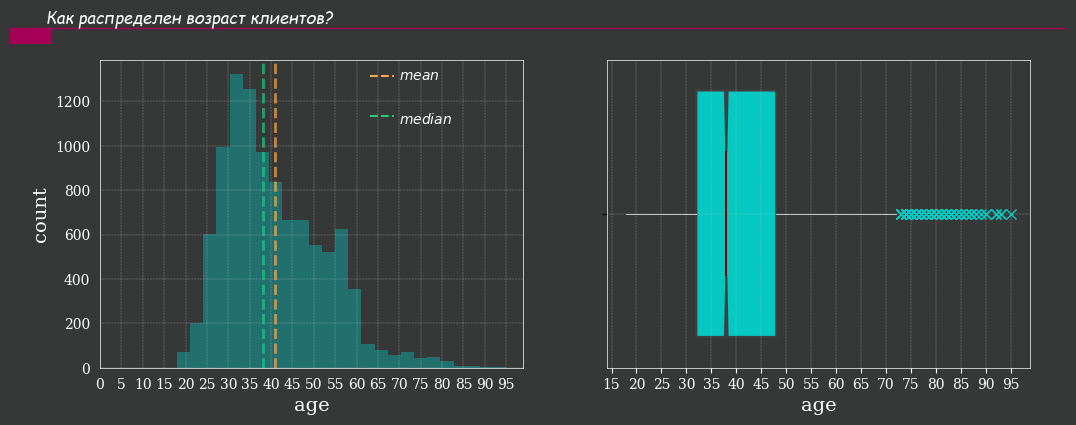

In [30]:
# Построим графики распределения признака возраст
 
fig, ax = plt.subplots(ncols=2,nrows=1, figsize=(12, 4))
fig.patch.set_facecolor('xkcd:dark grey')


plt.rcParams["font.family"] = "serif"

ax1 = sns.distplot(x=cleaned['age'], 
                   bins=25,
                   kde=False, 
                   ax=ax[0], 
                   color = '#04c8c1') 
ax1.set_facecolor('#363737')
ax1.set(xticks = np.arange(0, 100, 5))
ax1.axvline(cleaned['age'].mean(), color = '#fdaa48', linewidth = 2, ls = 'dashed', alpha = .7)
ax1.axvline(cleaned['age'].median(), color = '#18d17b', linewidth = 2, ls = 'dashed', alpha = .7)
ax1.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax1.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
ax1.set_ylabel('count', fontsize=14, color = '#fdfdfe')
ax1.set_xlabel('age', fontsize=14, color = '#fdfdfe')
ax1.tick_params(axis='y', labelsize=10, color = '#363737', labelcolor = '#fdfdfe')
ax1.tick_params(axis='x', labelsize=10, color = '#363737', labelcolor = '#fdfdfe')
ax1.grid(color='#c5c9c7', linestyle='-.', linewidth=0.2)



ax2 = sns.boxplot(data=cleaned, 
                  x='age', 
                  ax=ax[1],  
                  notch=True, 
                  showcaps=False,
                  flierprops={"marker": "x",
                            "markeredgecolor":"#04c8c1",
                            "markersize" : 7},
                  boxprops={"facecolor": '#04c8c1'},
                  medianprops={"color": "maroon"},
                  whiskerprops = {'linestyle': 'solid', 
                                  'linewidth': 0.5, 
                                  'color': '#fdfdfe'})
ax2.set_facecolor('#363737')
ax2.set(xticks = np.arange(0, 100, 5))
ax2.set_xlabel('age', fontsize=14, color = '#fdfdfe')
ax2.tick_params(axis='x', labelsize=10, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax2.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax2.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
ax2.grid(color='#c5c9c7', linestyle='-.', linewidth=0.2)

plt.gca().add_patch(
    plt.Rectangle(
        (0.05, .92), 
        0.035, 
        0.04, 
        facecolor = 'xkcd:violet red',
        transform = fig.transFigure,
        clip_on = False,
        linewidth = 0
    )
)

plt.gca().plot(
    [0.05, .93], 
    [.96, .96], 
    transform = fig.transFigure,
    clip_on = False,
    color = 'xkcd:violet red', 
    linewidth = 1.
)


plt.gca().plot(
    [0.35, 0.37], 
    [.84, .84], 
    transform = fig.transFigure,
    clip_on = False,
    color = 'xkcd:light orange',
    linestyle='--', 
    linewidth = 1.5
)
plt.gca().plot(
    [0.35, 0.37], 
    [.74, .74], 
    transform = fig.transFigure,
    clip_on = False,
    color = 'xkcd:seaweed',
    linestyle='--', 
    linewidth = 1.5
)


ax1.text(x=70, 
         y=1300, 
         s="$mean$", 
         fontsize=10,
         weight='normal', 
         color = '#fdfdfe');

ax1.text(x=70, 
         y=1100, 
         s="$median$", \
         fontsize = 10, 
         weight ='normal', 
         color = '#fdfdfe');
plt.text(
    x = .08, 
    y = .97, 
    s = 'Как распределен возраст клиентов?',
    fontname = 'Comic Sans MS',
    style = 'oblique',
    size = 'large',
    weight='normal',
    ha='left',
    color='#fdfdfe',
    transform = fig.transFigure
)

plt.show()


In [31]:
# Вычислим коэффициент ассиметрии распределения
print('Коэффициент ассиметрии распределения признака age : {}'.format(cleaned['age'].skew()))

Коэффициент ассиметрии распределения признака age : 0.8677036244006852


Положительный коэффициент ассиметрии говорит о правостороннем смещении распределения признака возраст, а значит в признаке присутствуют аномальные значения (максимальные значения возраста)

In [32]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
cleaned['age_group'] = pd.cut(cleaned['age'], [0, 30, 40, 50, 60, np.inf], labels=['<30', '30-40', '40-50', '50-60', '60+'])

Построим график и посмотрим соотношения возрастных групп в наших данных   
напишем функцию для визуализации распределения категориальных признаков, которая на вход принимает 
* датафрейм, 
* категориальный признак, 
* размер фигуры, (уникальные значения варьируются от 2 до 12) 
* размер шрифта заголовка, значение признака deposit - 'yes'или 'no' или ''

In [33]:
def treemap_plot(data, feature, title, figsize, fontsize, value=''):
    '''Позиционные аргументы:
       data (DataFrame) -- датафрейм,
       feature (column) -- столбец с категориальными данными,
       title (str) -- заголовок графика,
       figsize (tuple, int) -- размер графика,
       fontsize (int) -- размер шрифта
       Именованный аргумент:
       value (str) -- значение признака deposit - '', yes' или 'no'
       Return -- график распределения в зависимости от значения аргумента value
            Если value == '' -- функция строит treemap общего распределения уникальных значений признака feature,
            Если value == 'yes' -- функция строит treemap распределения возрастных групп внутри множества data[data['deposit'] == 'yes'],
            Если value == 'no' -- функция строит treemap распределения возрастных групп внутри множества data[data['deposit'] == 'no']'''
 
    if value == '':
# Вычисляем % соотношение уникальных значений в признаке feature        
        df = data[feature].value_counts(normalize = True).reset_index()
# Переименовываем столбцы
        df.columns = [feature, 'Percentage']

# Вычисляем какой % составляет данное значение 
        df['Percentage'] = [np.round(x*100) for x in df['Percentage']]
# Создаем переменную (список) с уникальными значениями признака  
        name = df[feature].to_list()
# Создаем переменную (список) с % долей данного значения
        count = df['Percentage'].to_list()
# Добавим метку возрастной группы и ее % показатель       
        df.loc[:,feature] = [str(name[i])+ ' '+ '\n' +str(count[i])+ '%' for i in range(len(name))]
        
        
# Если value указано как 'no' или 'yes' функция строит treemap распределение признака feature в каждом значениии value признака deposit    
    else:
        
        df = data[data['deposit'] == value][feature].value_counts(normalize = True).reset_index()
        df.columns = [feature, 'Percentage']
        df['Percentage'] = [np.round(x*100) for x in df['Percentage']]
        name = df[feature].to_list()
        count = df['Percentage'].to_list()

# Добавим метку вотной группы и ее % показатель
    df.loc[:,feature] = [str(name[i])+ ' '+ '\n' +str(count[i])+ '%' for i in range(len(name))]
# Строим фигуру
    fig = plt.figure(figsize=figsize) # уберу figsize для те
    fig.patch.set_facecolor('xkcd:dark grey')
    
    plt.rcParams["font.family"] = "serif"

# Задаем имена блоков
    labels = df[feature]
# Задаем размеры блоков
    sizes = df['Percentage']
# Задаем цветовое оформление блоков
    colors = ['#00a19b','#ffda64', '#e55abf','#ffcf36', '#55d7d2']
# Строим treemap
    squarify.plot(label=labels, 
                sizes=sizes, 
                color=colors, 
                pad=1.5, 
                text_kwargs={'fontsize': fontsize,
                            'fontname' : 'sans-serif',
                            'weight' : 'semibold',
                            'color':'#fdfdfe'},
                alpha=.7
                )
    
    if value == '':
        
        plt.axis('off')
        
        plt.gca().add_patch(
            plt.Rectangle(
                (0.12, .91),
                0.033, 
                0.03, 
                facecolor = 'xkcd:violet red',
                transform = fig.transFigure,
                clip_on = False,
                linewidth = 0
                )
            )
# 
        plt.gca().plot(
            [0.12, .9], 
            [.94, .94], 
            transform = fig.transFigure,
            clip_on = False,
            color = 'xkcd:violet red', 
            linewidth = 1.
            )
        plt.text(
            x = 0.15, 
            y = .95, 
            s = title,
            fontname = 'Comic Sans MS',
            fontsize = 16,
            style = 'oblique',
            weight='normal',
            ha='left',
            color='#fdfdfe',
            transform = fig.transFigure
            )
       
        plt.show();    
    
    
    else:
        plt.axis('off')
        
        plt.gca().add_patch(
            plt.Rectangle(
                (0.12, .91), 
                0.033, 
                0.03, 
                facecolor = 'xkcd:violet red',
                transform = fig.transFigure,
                clip_on = False,
                linewidth = 0
                )
            )

        plt.gca().plot(
            [0.12, .91], 
            [.94, .94],
            transform = fig.transFigure,
            clip_on = False,
            color = 'xkcd:violet red', 
            linewidth = 1.
            )
        plt.text(
            x = 0.15, 
            y = .95, 
            s = title,
            fontname = 'Comic Sans MS',
            fontsize = 16,
            style = 'italic',
            weight='normal',
            ha='left',
            color='#fdfdfe',
            transform = fig.transFigure
            )
        
        
        plt.show();    
        

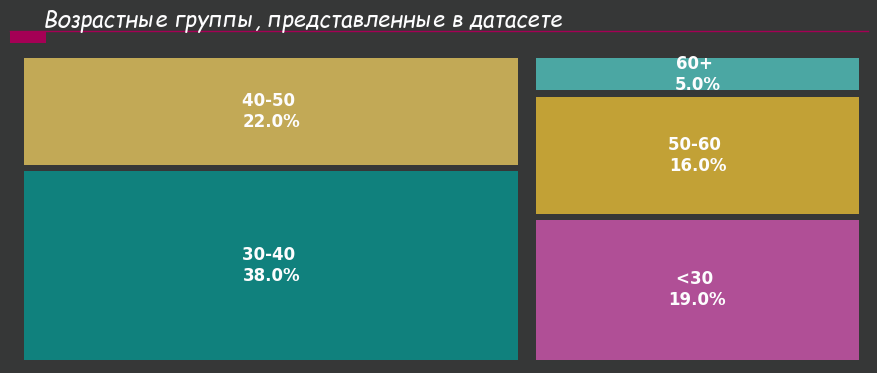

In [34]:
title = 'Возрастные группы, представленные в датасете'
figsize=(11,4)
fontsize = 12    
treemap_plot(cleaned, 'age_group', title, figsize, fontsize)

Итак, в данных заметно преобладание двух возрастных групп: 30-40 лет (38%) и 40-50 (22%), которые суммарно составляют 60% всех записей, самая малочисленная группа 5% - это клиенты старше 60 лет.

Визуализируем распределение признака `deposit' по возрастным группам и посмотрим клиенты каких возрастных групп соглашаются на предложение об открытии депозита, а какие отклоняют

In [35]:
# задаем размеры фигуры и координатной плоскости
def viz_groups(df,feature, target, title, fontsize):
    fig, ax = plt.subplots(figsize=(11,4))
    fig.patch.set_facecolor('xkcd:dark grey') 
    plt.rcParams["font.family"] = "serif"
    
# строим столбчатую диаграмму распределения
    ax = sns.countplot(data = df,
                       x = df[feature], 
                       hue = df[target], 
                       palette = ['#2ccec8','#c2008c']
                        );
    ax.set_facecolor('#363737')
    ax.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
    ax.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
    ax.set_ylabel('count', fontsize=14, color = '#fdfdfe')
    ax.set_xlabel(feature, fontsize=14, color = '#fdfdfe')
    ax.tick_params(axis='y', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
    ax.tick_params(axis='x', labelsize=fontsize, color = '#fdfdfe', labelcolor = '#fdfdfe')
 
    
    plt.gca().add_patch(
        plt.Rectangle(
        (0.05, .92), 
        0.03, 
        0.03, 
        facecolor =  'xkcd:violet red',
        transform = fig.transFigure,
        clip_on = False,
        linewidth = 0
        )
    )
# now the line
    plt.gca().plot(
        [0.05, .96], 
        [.95, .95], 
        transform = fig.transFigure,
        clip_on = False,
        color =  'xkcd:violet red', 
        linewidth = 1.
        )
    plt.text(
        x = 0.07, 
        y = .96, 
        s = title,
        fontname = 'Comic Sans MS',
        fontsize = 14,
        style = 'normal',
        weight='normal',
        ha='left',
        color='#fdfdfe',
        transform = fig.transFigure
        )


    ax.grid(color='#c5c9c7',linestyle='-.', linewidth=0.3) 
    ax.legend(bbox_to_anchor =(0.9, 1.), facecolor = '#363737',frameon = False, fontsize=16, labelcolor = '#fdfdfe', ncol = 2)
   
    plt.show();


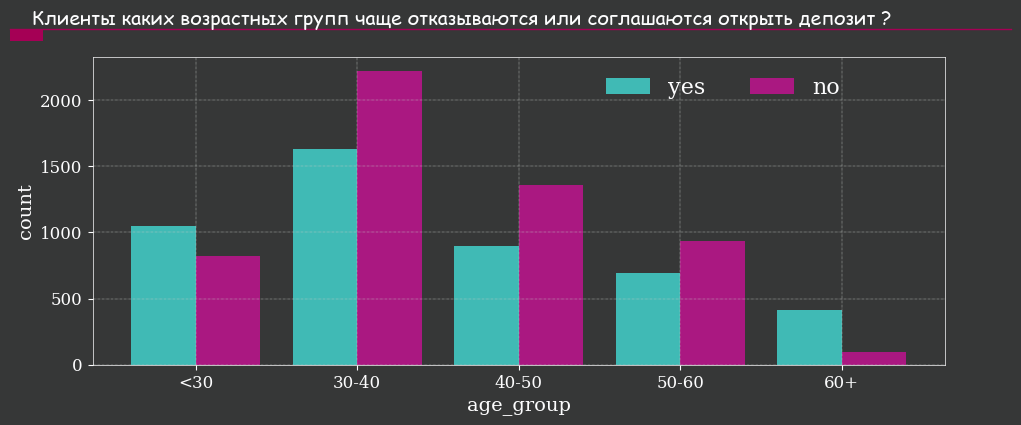

In [36]:
title = 'Клиенты каких возрастных групп чаще отказываются или соглашаются открыть депозит ?'
fontsize = 12
viz_groups(cleaned,'age_group', 'deposit', title, fontsize)

Мы получили понимание какое количество клиентов согласились или отказались от открытия депозита среди всех возрастных групп.
В трех возрастных группах из 5-ти (30-40, 40-50, 50-60) мы видим, что преобладает категория клиентов, не имеющих депозита, обратную ситуацию демонстрируют две оставшиеся группы (<30, 60+), хотя критерий возраста не объясняет мотивацию одобрения предложения или отказа от открытия депозита, тем не менее обрисовывает контуры целевой аудитории 

Мы узнали из графика выше как распределен признак `deposit` по возрастным группам, теперь взглянем какую долю составляет каждая возрастная группа среди клиентов, которые открыли депозит и которые отказались

Возрастные группы и их доля среди клиентов, согласившихся открыть депозит


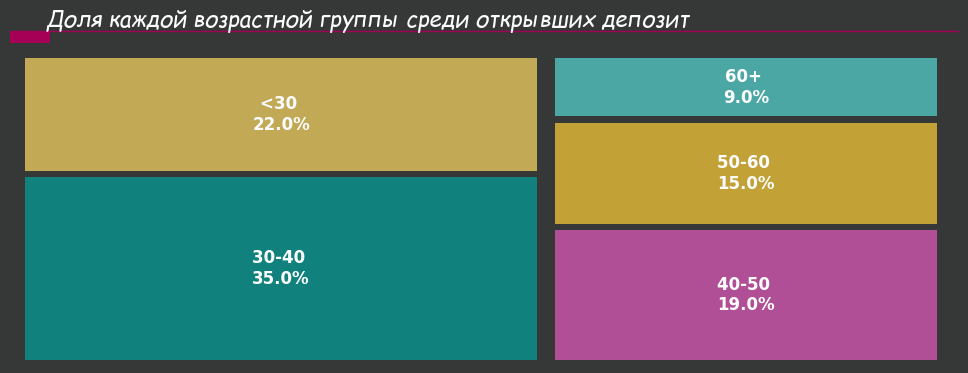

Возрастные группы и их доля среди клиентов, не согласившихся открыть депозит


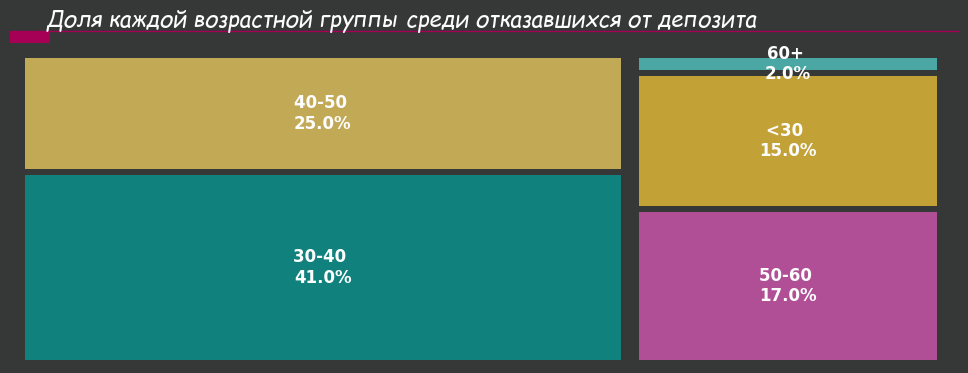

In [37]:
title = 'Доля каждой возрастной группы среди открывших депозит'
fontsize = 12
figsize=(12,4)
print('Возрастные группы и их доля среди клиентов, согласившихся открыть депозит')
treemap_plot(cleaned, 'age_group', title,figsize, fontsize, 'yes')
print('Возрастные группы и их доля среди клиентов, не согласившихся открыть депозит')
title = 'Доля каждой возрастной группы среди отказавшихся от депозита'
treemap_plot(cleaned, 'age_group',title, figsize, fontsize, 'no')

Как мы выяснили ранее, в целевой переменной наблюдается дисбаланс в сторону отказа от открытия депозита, тем не менее мы можем сформулировать промежуточные наблюдения касательно признака возраста клиентов 
* Среди клиентов, давших согласие на предложение об открытии депозита 35% принадлежат возрастной группе 30-40 лет и 22% клиентов из группы младше 30.
* В то же время клиенты в группе 30-40 лет чаще всего отказываются от открытия депозита, о чем свидетельствует их процентная доля в 41% среди всех кто отклонил предложение, похожая ситуация с возрастной группой 40-50 лет, представители которой чаще отказывались от открытия депозита, чем соглашались, о чем говорят цифры в 25 % отказавшихся против 19% давших утвердительный ответ


### Задания 9 и 10

Какое соотношение имеют значения признака `marital` 

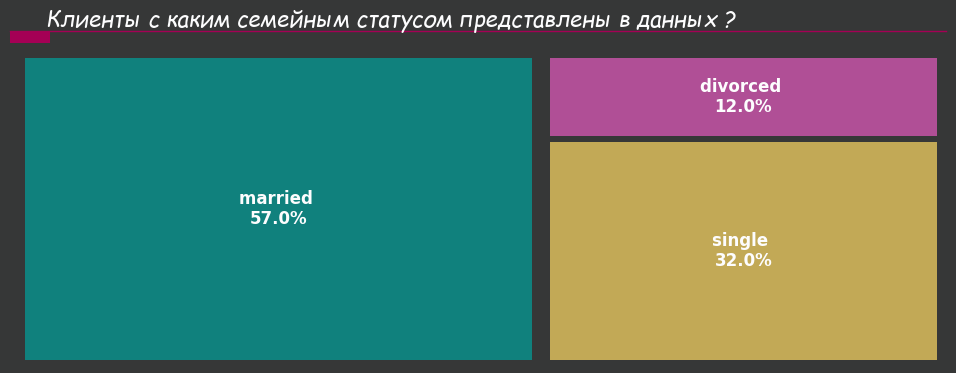

In [38]:
title = 'Клиенты с каким семейным статусом представлены в данных ?'
figsize=(12,4)
fontsize=12
treemap_plot(cleaned, 'marital', title, figsize,fontsize)

57% клиентов  клиентов замужем/женаты, треть - 32% холосты 

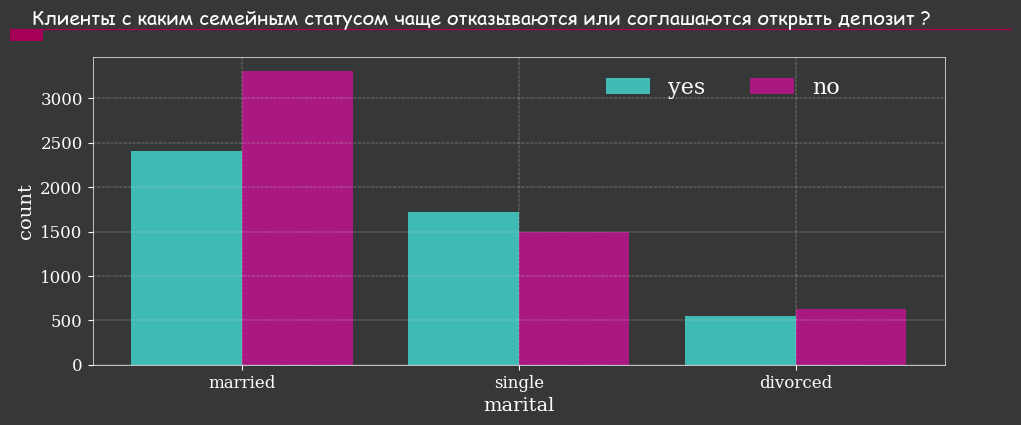

In [39]:
title = 'Клиенты с каким семейным статусом чаще отказываются или соглашаются открыть депозит ?'
fontsize=12
viz_groups(cleaned, 'marital', 'deposit', title, fontsize)

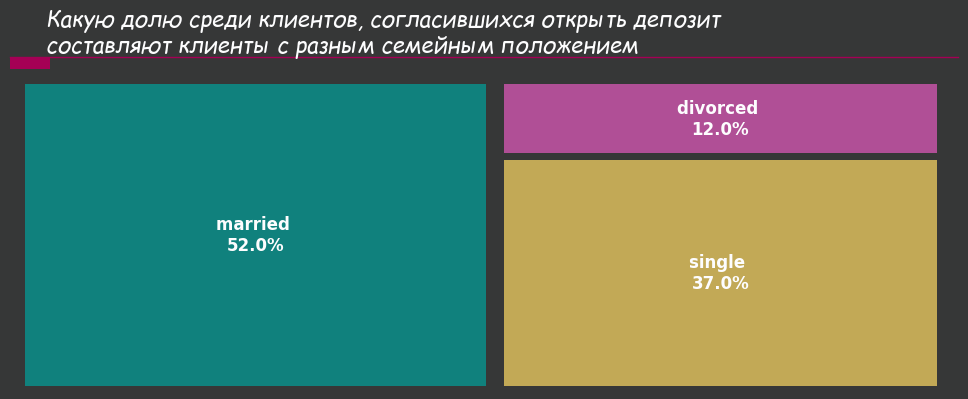

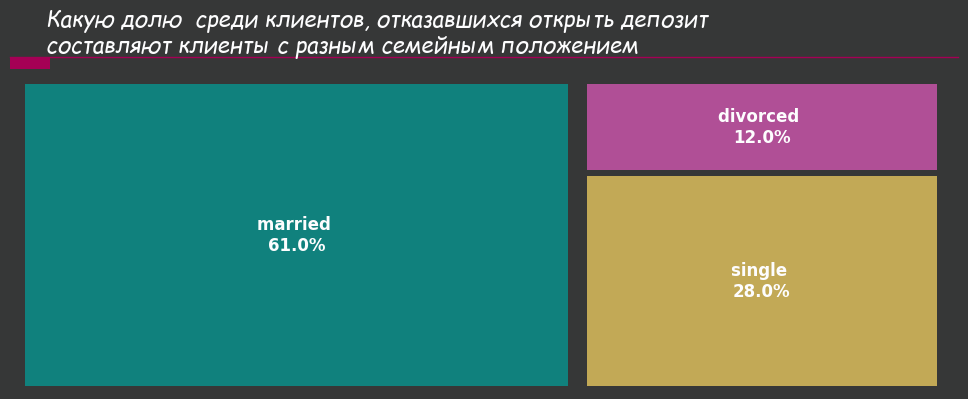

In [40]:
figsize = (12,4)
fontsize=12
title = 'Какую долю среди клиентов, согласившихся открыть депозит \nсоставляют клиенты с разным семейным положением'
treemap_plot(cleaned, 'marital',title, figsize, fontsize, 'yes')
title = 'Какую долю  среди клиентов, отказавшихся открыть депозит \nсоставляют клиенты с разным семейным положением'
treemap_plot(cleaned, 'marital', title, figsize, fontsize,'no')

Признак семейного статуса распределен в группах значений признака депозит следующим образом:
Женатые\замужние клиенты чаще отказываются от открытия депозита - 61% отказов против 52% одобрений  
Холостые клиенты чаще соглашаются с предложением открыть депозит - 37% положительных ответов против 28% отказов 
Среди разведенных клиентов 

### Признак `education`
Визуализируем процентное соотношение уникальных значений признака в данных

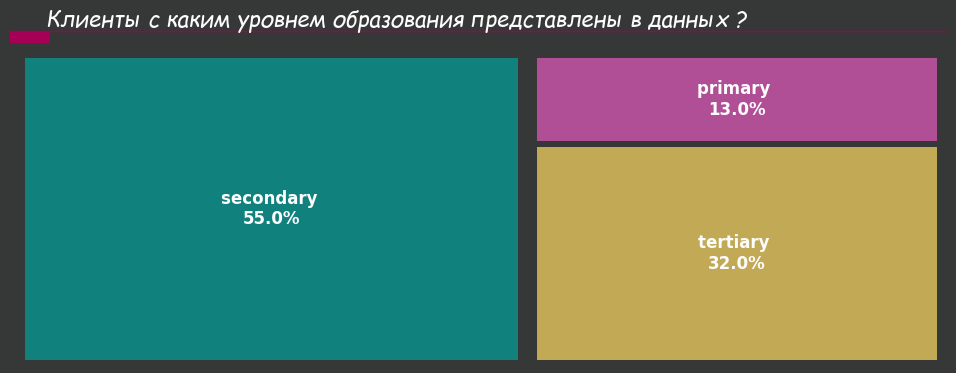

In [41]:
title = 'Клиенты с каким уровнем образования представлены в данных ?'
figsize=(12,4)
fontsize=12
treemap_plot(cleaned, 'education', title, figsize, fontsize)

В данных преобладают клиенты со средним образованием, их доля в общей совокупности составляет 55%, треть записей, а именно 32% принадлежит клиентам с высшим образованием, доля клиентов с начальным образованием равна 13%

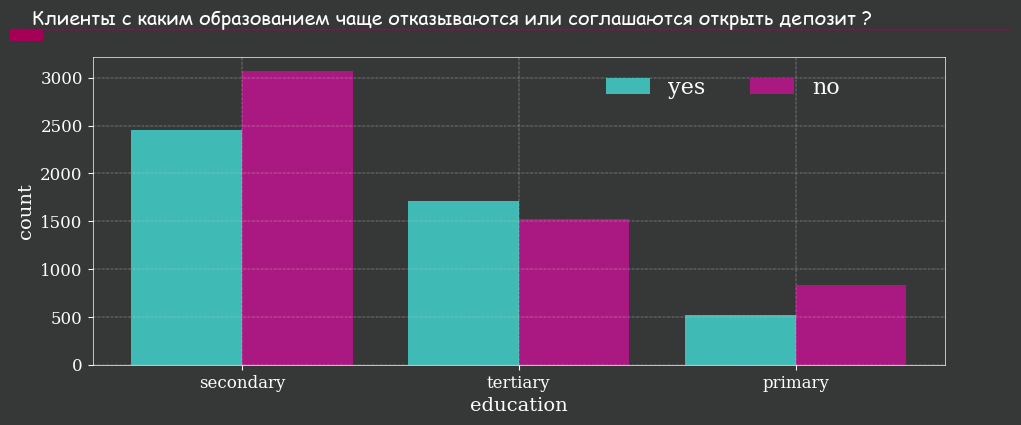

In [42]:
title = 'Клиенты с каким образованием чаще отказываются или соглашаются открыть депозит ?'
fontsize = 12
viz_groups(cleaned, 'education', 'deposit', title, fontsize)

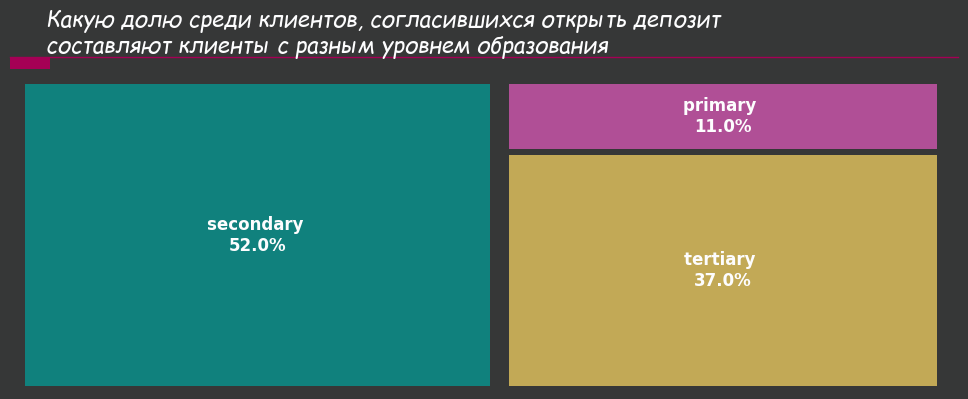

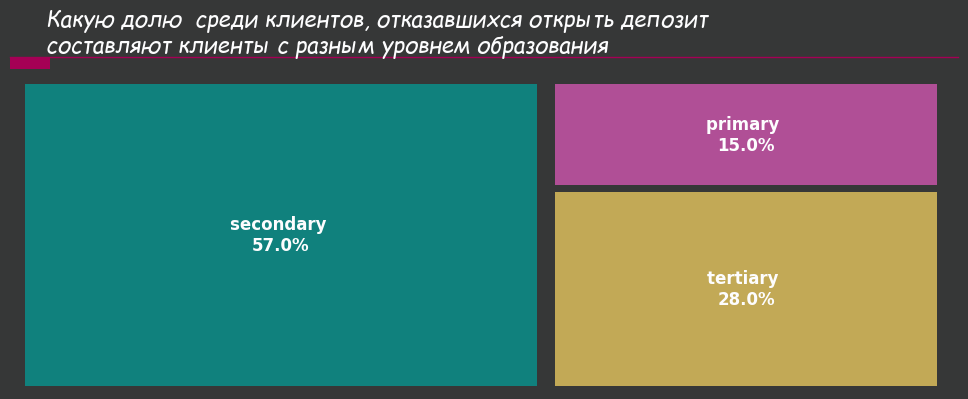

In [43]:

title = 'Какую долю среди клиентов, согласившихся открыть депозит \nсоставляют клиенты с разным уровнем образования'
figsize = (12,4)
fontsize=12
treemap_plot(cleaned, 'education', title, figsize,fontsize, 'yes')

title = 'Какую долю  среди клиентов, отказавшихся открыть депозит \nсоставляют клиенты с разным уровнем образования'
treemap_plot(cleaned, 'education', title, figsize, fontsize, 'no')

Клиенты со средним уровнем образования, которые отказались от депозита составляют 57%, в то время как в группе, давших согласие их доля составляет 52%, 37% клиентов с высшим образованием согласились с предложением и 28% отказались, 11% клиентов с начальным уровнем образования одобрили открытие депозита, отклонили предложение 15%  

### Признак `job`

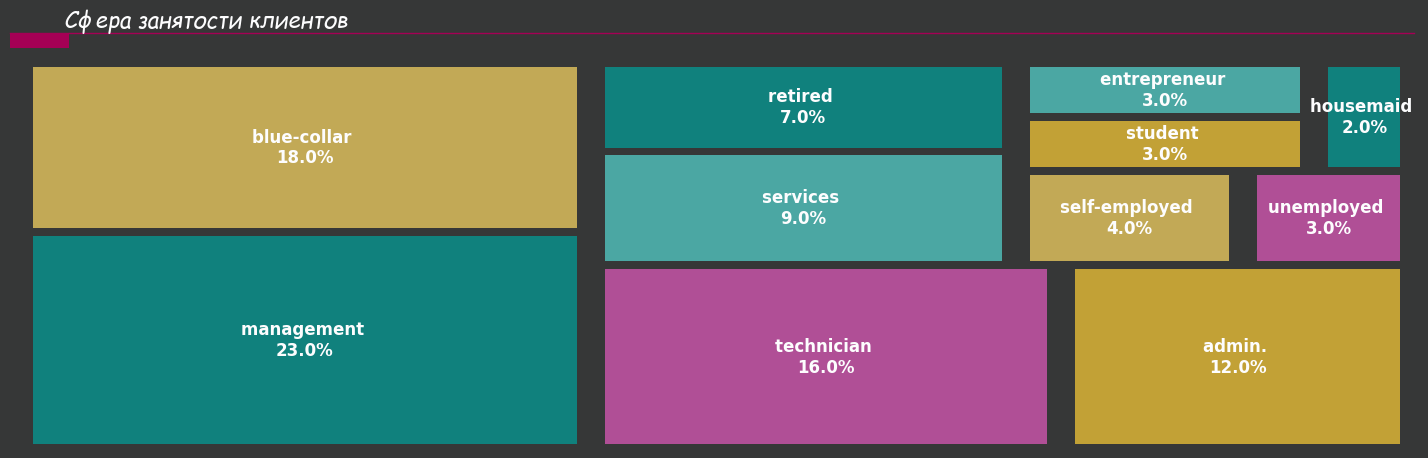

In [44]:
title = 'Сфера занятости клиентов'
fontsize=12
figsize=(18,5)   
treemap_plot(cleaned, 'job', title, figsize, fontsize)

Наиболее многочисленная сфера деятельности клиентов - менеджмент, в ней занято 23% всех клиентов, на второй позиции - "синие воротнички" и 18%, на третьем месте - техники с 16% и 12% это администраторы

In [624]:
%config InlineBackend.figure_format = 'retina'

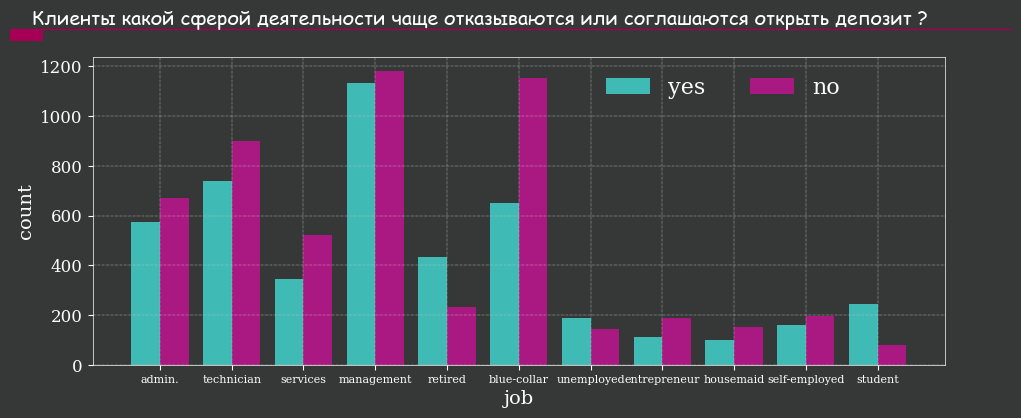

In [45]:
title = 'Клиенты какой сферой деятельности чаще отказываются или соглашаются открыть депозит ?'
fontsize=8
viz_groups(cleaned, 'job', 'deposit', title, fontsize)

Здесь мы наблюдаем следующую ситуацию, представители восьми из 11 сфер отказались от открытия депозита, чаще отказывались "синие воротнички", служащие и администраторы, чаще соглашались с предложением пенсионеры и студенты

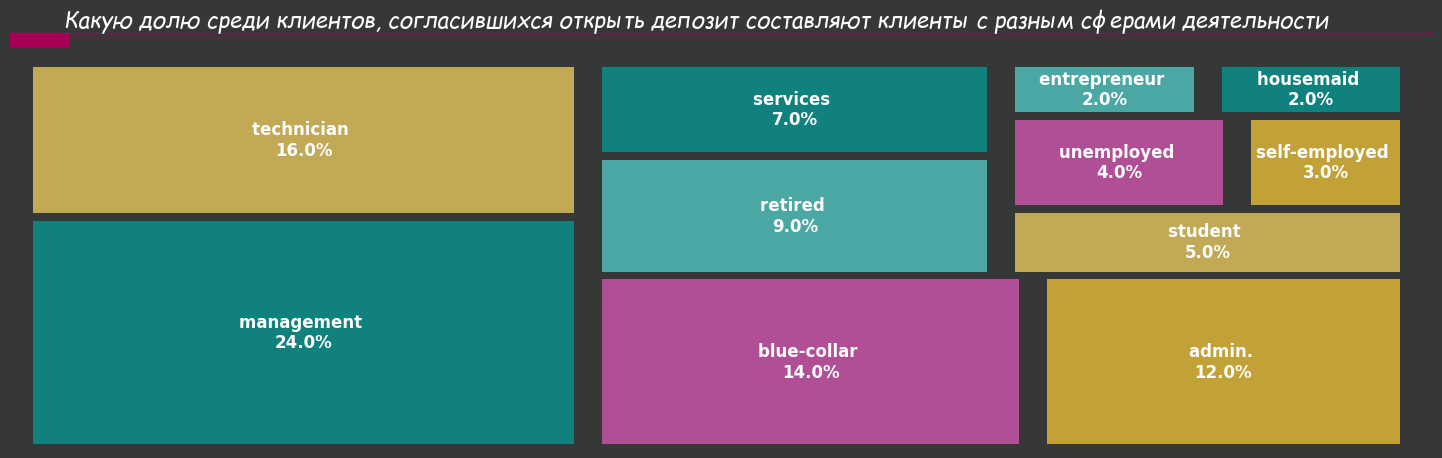

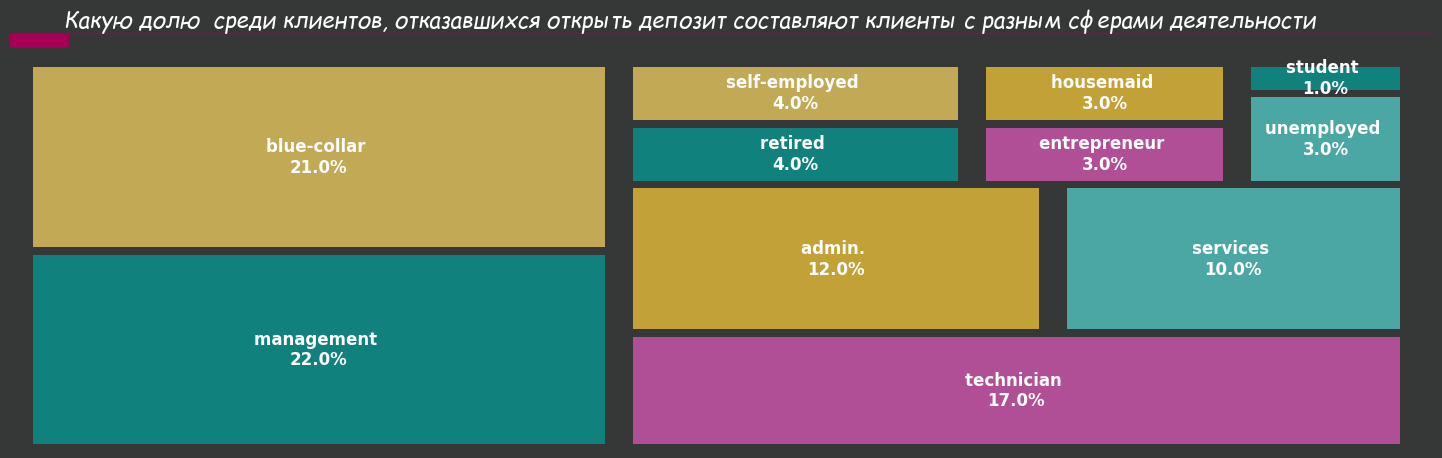

In [46]:
title = 'Какую долю среди клиентов, согласившихся открыть депозит составляют клиенты с разным сферами деятельности'
fontsize=12
figsize=(18,5)  
treemap_plot(cleaned, 'job',title, figsize, fontsize, 'yes')
title = 'Какую долю  среди клиентов, отказавшихся открыть депозит составляют клиенты с разным сферами деятельности'
treemap_plot(cleaned, 'job', title, figsize, fontsize, 'no')

Если сравнить как распределены процентные доли профессиональных сфер по значениям признака депозит, мы видим,что клиенты, занятые в сфере менеджемента соглашаются на предложение (24%) так же часто как и отказываются (22%),аналогичная ситуация с техниками, процент одобрения (16%), отказа (17%), 'синие воротнички' напротив, отклоняют предложение (21%) чаще, чем одобряют (14%), администраторы приниимают и отклоняют предложение примерно одинаково, их доля в обеих группах составляет (12%),что касается остальных категорий,то служащие, предприниматели, самозанятые в целом принимают либо отклоняют предложение примерно в одинаковых соотношениях, что касается студентов и пенсионеров, то данные категории клиентов, принимают предложение чаще, чем отказывают   

### Задание 11

In [47]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

pivot = pd.pivot_table(cleaned, index=['education', 'marital'], columns='deposit', aggfunc='size')
pivot 

deposit               no   yes
education marital             
primary   divorced    91    96
          married    641   339
          single     100    82
secondary divorced   370   283
          married   1830  1289
          single     866   879
tertiary  divorced   163   174
          married    832   784
          single     531   755

In [48]:
group1 = cleaned[cleaned['balance'] > 0][['housing', 'loan', 'default']]
group2 = cleaned[cleaned['balance'] < 0][['housing', 'loan',  'default']]
result_pos_balance = pd.crosstab(group1['housing'], group1['default'])
result_neg_balance = pd.crosstab(group2['housing'], group2['default'])

print('Положительный баланс:')
print(result_pos_balance)
print()
print('Отрицательный баланс:')
print(result_neg_balance)

Положительный баланс:
default    no  yes
housing           
no       4598   37
yes      3986   28

Отрицательный баланс:
default   no  yes
housing          
no       154   24
yes      452   52


## Часть 3: преобразование данных

### Задание 1

In [49]:
# преобразуйте уровни образования
lab_encoder = LabelEncoder()
cleaned['education'] = lab_encoder.fit_transform(cleaned['education'])
cleaned['age_group'] = lab_encoder.fit_transform(cleaned['age_group'])

### Задания 2 и 3

In [50]:
# преобразуйте бинарные переменные в представление из нулей и единиц

cleaned['deposit'] = [1 if x=='yes' else 0 for x in cleaned['deposit']]  
cleaned['deposit'].std()

0.4986712532452124

In [51]:
cleaned['default'] = [1 if x=='yes' else 0 for x in cleaned['default']]
cleaned['housing'] =[1 if x=='yes' else 0 for x in cleaned['housing']]
cleaned['loan'] = [1 if x=='yes' else 0 for x in cleaned['loan']]
cleaned['default'].mean() + cleaned['housing'].mean() + cleaned['loan'].mean()

0.6354280059376547

### Задание 4

In [52]:
# создайте дамми-переменные
print(cleaned.shape)
bank = cleaned.copy()
bank= pd.get_dummies(bank, columns = ['job', 'marital', 'contact', 'month', 'poutcome'], dtype=int)

print(bank.shape) # количество признаков после dummie кодирования

(10105, 19)
(10105, 47)


### Задания 5 и 6

После dummy-кодирования категориальных признаков количество столбцов увеличилось, поэтому в целях сохранения информативности корреляционной матрицы, применим фильтрацию к значениям корреляции между признаками, присвоив метки:  
* **`W`** - слабая связь  > `0.25`
* **`M`** - средняя связь > `0.5`
* **`S`** - сильная связь > `0.75`  
отметим только значения,которые соответствуют условиям фильтра, остальное пространство будет соответствовать очень слабой корреляционной связи между признаками

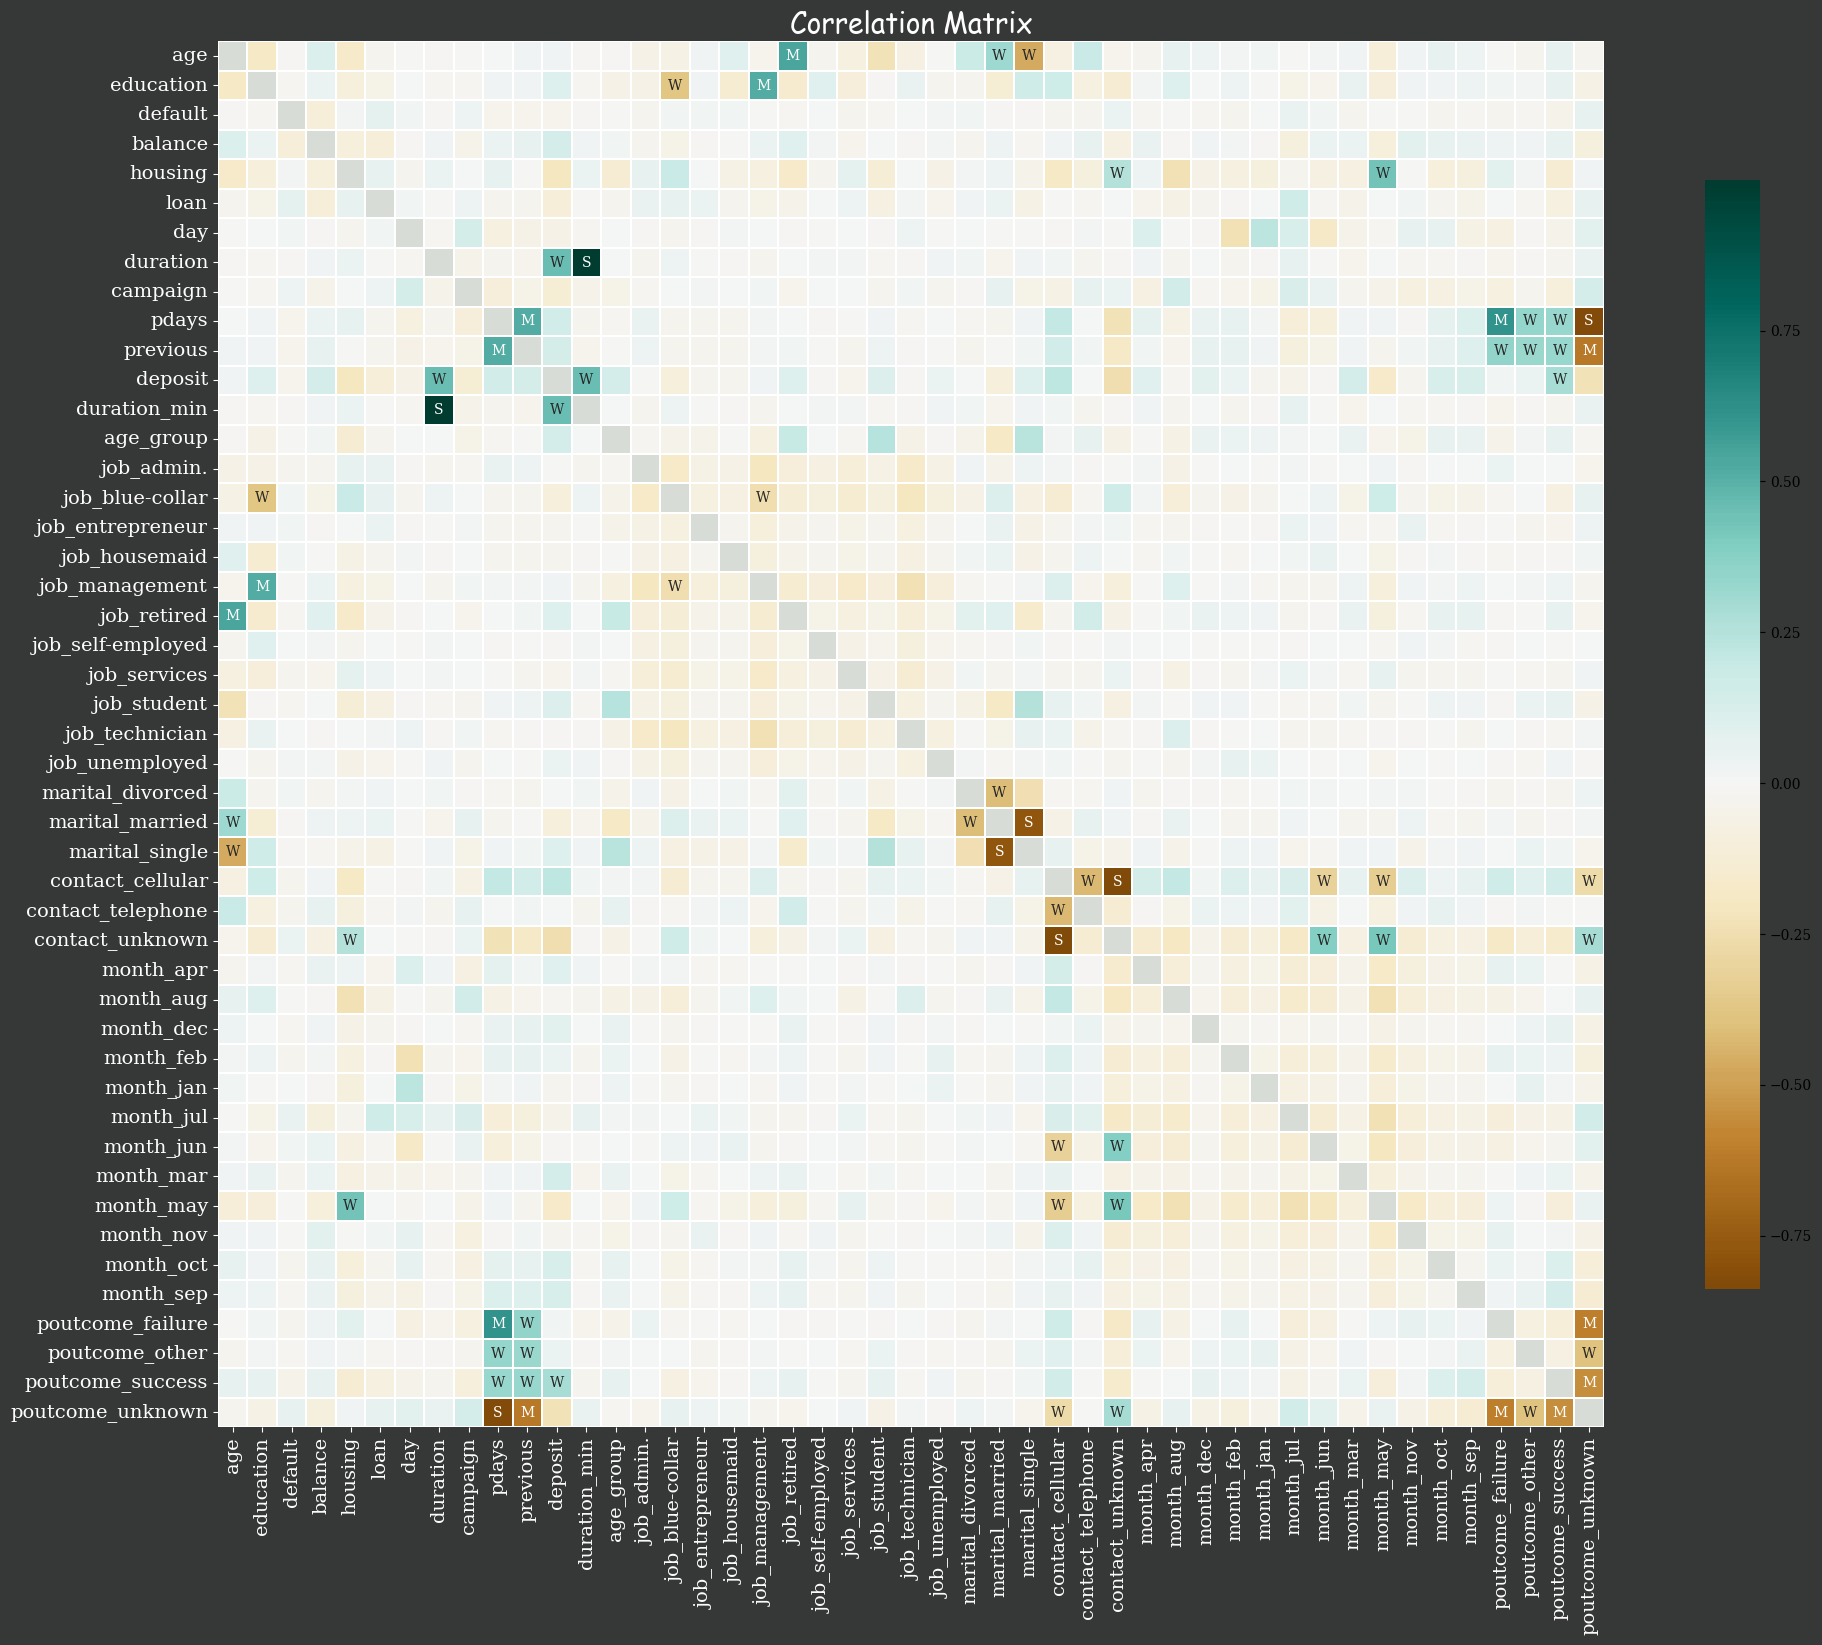

In [53]:
data_corr = bank.corr()
labels = np.where(np.abs(data_corr)>0.75, 'S',
                np.where(np.abs(data_corr)>0.5,'M',
                        np.where(np.abs(data_corr)>0.25,'W','')))
                                  

fig, ax = plt.subplots(figsize=(26,18))

fig.patch.set_facecolor('xkcd:dark grey') 
ax.set_facecolor('#d8dcd6')
plt.rcParams["font.family"] = "serif"
sns.heatmap(data_corr, 
            mask = np.eye(len(data_corr)), 
            center=0, 
            cmap='BrBG', 
            annot=labels, 
            fmt='', 
            linewidth=.3, 
            square=True, 
            cbar_kws={'shrink':.8})
ax.tick_params(axis='y', labelsize=14, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax.tick_params(axis='x', labelsize=14, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax.set_title('Correlation Matrix', fontsize=20, color = '#fdfdfe',fontname = 'Comic Sans MS')
plt.show();

In [54]:
# удалим временный признак 
bank.drop('duration_min', axis=1, inplace =True)

Мы видим, что признаков с сильной связью всего 3 (`unknown-pdays, single-married, unknown-cellular`), в основном между признаками корреляционная связь отсутствует, либо крайне слаба

In [56]:
corr_with_target = bank.corr()['deposit'].abs().sort_values()

#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('deposit')

Теперь визуализируем корреляцию признаков с целевой переменной `deposit`

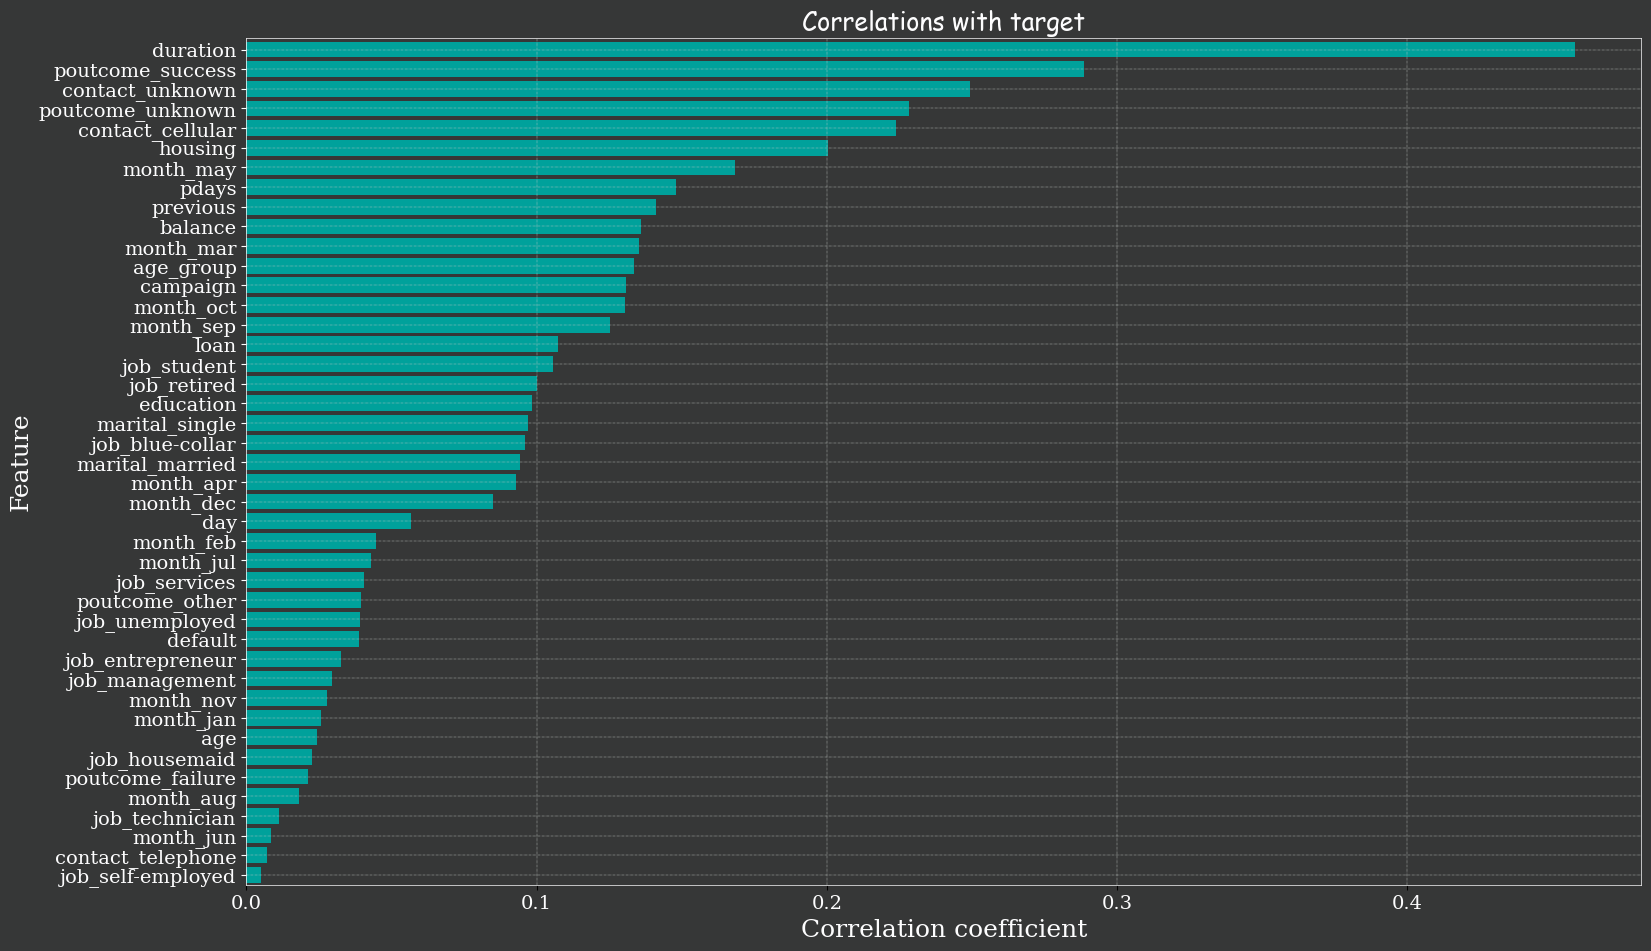

In [57]:
fig, ax = plt.subplots(figsize=(18,11)) #фигура+координатная плоскость
fig.patch.set_facecolor('xkcd:dark grey')
plt.rcParams["font.family"] = "serif"
ax.set_facecolor('#363737')
ax.barh(corr_with_target.index, corr_with_target.values, color='#00a19b') #столбчатая диаграмма
ax.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
ax.set_title('Correlations with target', fontsize=18, color = '#fdfdfe',fontname = 'Comic Sans MS') #название графика
ax.set_xlabel('Сorrelation coefficient', fontsize=18, color = '#fdfdfe') #название оси x
ax.set_ylabel('Feature',  fontsize=18, color = '#fdfdfe'); #название оси y
ax.tick_params(axis='y', color = '#fdfdfe',  labelsize=14, labelcolor = '#fdfdfe')
ax.tick_params(axis='x', labelsize=14, labelcolor = '#fdfdfe')
ax.grid(color='#c5c9c7',linestyle='-.', linewidth=0.3)
ax.set_ylim(1.5,44.6);

Видим аналогичную картину, корреляционную связь между таргетом и признаками можно описать как слабую  

### Задания 7 и 8

In [58]:
#  разобьем датасет на трейн и тест, принимая во внимание дисбаланс целевой переменной
X = bank.drop(['deposit'], axis=1)
y = bank['deposit']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify = y, 
                                                    random_state = 42, 
                                                    test_size = 0.33)
print('Размер тренировочной выборки {} и {}'.format(X_train.shape, y_train.shape))
print('Размер тестовой выборки {} и {}'.format(X_test.shape, y_test.shape))

Размер тренировочной выборки (6770, 45) и (6770,)
Размер тестовой выборки (3335, 45) и (3335,)


# рассчитайте необходимые показатели

In [60]:
# рассчитайте необходимые показатели
print('Среднее значение тестовой выборки: {}'.format(np.round(y_test.mean(),2)))

Среднее значение тестовой выборки: 0.46


### Задание 9

In [61]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
# создаем объект SelectKBest
selector = SelectKBest(score_func = f_classif, k=15).fit(X_train, y_train)

# обучаем модель на тренировочных данных
#kbest_features = selector.fit(X, y)

# для удобства создадим датафрейм результатов
# с помощью применения метода .get_suppport() получаем 15 выбранных признаков и F-значение 
scores = selector.scores_[selector.get_support()]
pvalue = selector.pvalues_[selector.get_support()]

# создадим датафрейм для визуализации 
features = X_train.columns[selector.get_support()]
kbest_scores = pd.DataFrame({'Feature': features, 
                            'F Score' : scores})

print('Признаки и оценка')
display(kbest_scores.sort_values(by='F Score', ascending=False).reset_index(drop=True))


Признаки и оценка


Feature      F Score
0           duration  1839.078214
1   poutcome_success   628.351616
2    contact_unknown   427.557659
3   poutcome_unknown   373.006765
4   contact_cellular   350.501992
5            housing   301.264198
6          month_may   183.875989
7           previous   153.923796
8              pdays   148.749979
9           campaign   139.486664
10         month_sep   130.230009
11         age_group   129.445120
12         month_oct   125.319693
13         month_mar   114.759591
14           balance   114.356404

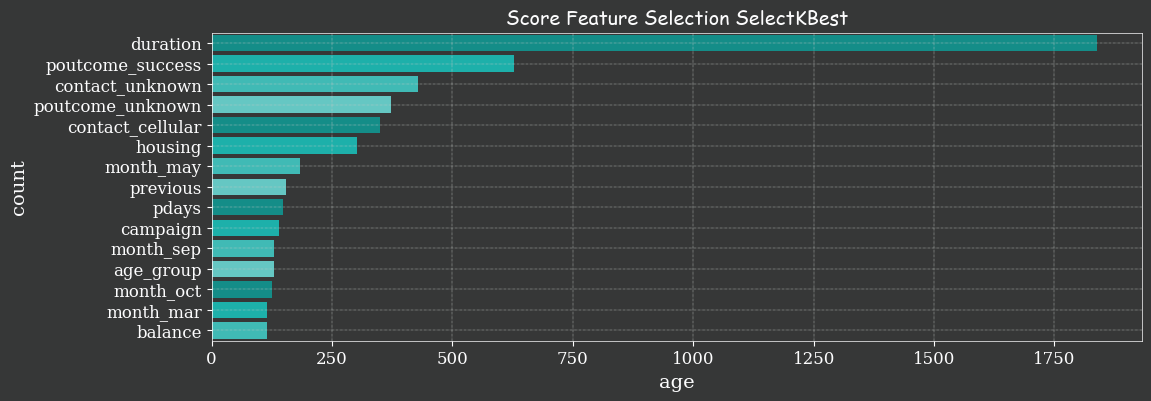

In [59]:
fig, ax = plt.subplots(figsize = (12, 4))
fig.patch.set_facecolor('xkcd:dark grey')
ax.set_facecolor('#363737')
plt.rcParams["font.family"] = "serif"
# для удобства визуализации оценок признака отсортируем значения по столбцу Score
sorted_scores = kbest_scores.sort_values(by='F Score', ascending=False).reset_index(drop=True)

sns.barplot(x = sorted_scores['F Score'], 
            y = sorted_scores['Feature'], 
            data = sorted_scores,
            orient ='h', 
            palette = ['#00a19b', '#04c8c1', '#2ccec8', '#55d7d2'])  

        
ax.set_title("Score Feature Selection SelectKBest", fontsize=14, color = '#fdfdfe',fontname = 'Comic Sans MS') 


ax.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
ax.set_ylabel('count', fontsize=14, color = '#fdfdfe')
ax.set_xlabel('age', fontsize=14, color = '#fdfdfe')
ax.tick_params(axis='y', color = '#fdfdfe', labelsize=12, labelcolor = '#fdfdfe')
ax.tick_params(axis='x', color = '#fdfdfe', labelsize=12, labelcolor = '#fdfdfe')
ax.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)


plt.show();

In [62]:
# получим список признаков, отобранных методом SelectKBest
best_features = X_train.columns[selector.get_support()]

In [ ]:
'''selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

X_new = SelectKBest(score_func = f_classif, k = 15).fit(X_train, y_train)
X_new'''

In [ ]:
'''# с помощью SelectKBest отберите 15 наиболее подходящих признаков
# создаем объект SelectKBest
selector = SelectKBest(score_func = f_classif, k=15)

# обучаем модель на тренировочных данных
kbest_features = selector.fit(X_train, y_train)

# для удобства создадим датафрейм результатов
# с помощью применения метода .get_suppport() получаем 15 выбранных признаков и F-значение 
scores = kbest_features.scores_[kbest_features.get_support()]
pvalue = kbest_features.pvalues_[kbest_features.get_support()]

# создадим датафрейм для визуализации 
features = X_train.columns[kbest_features.get_support()]
kbest_scores = pd.DataFrame({'Feature': features, 
                            'F Score' : scores})
kbest_scores.sort_values(by='F Score', ascending=False).reset_index(drop=True)


print('Признаки и оценка')
display(kbest_scores.sort_values(by='F Score', ascending=False).reset_index(drop=True))

'''

In [ ]:
'''names = X_train.columns.values[kbest_features.get_support()]
scores = kbest_features.scores_[kbest_features.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True]).reset_index(drop=True)
ns_df_sorted'''

Метод SelectKBest отобрал 15 лучших признаков на которых мы будем обучать модель

Создадим датафрейм из признаков,выбранных выше

### Задание 10

In [63]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train[best_features])
X_train_scaled = scaler.transform(X_train[best_features])
X_test_scaled = scaler.transform(X_test[best_features])  

In [64]:
mean_col_0 = np.round(np.mean(X_test_scaled[:, 0]),2)
print(mean_col_0)

0.47


In [65]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error 

# `Часть 4`: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

* ### **`Logistic Regression`**

In [67]:
# обучите логистическую регрессию и рассчитайте метрики качества

# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(solver = 'sag', 
                                          random_state=42, 
                                          max_iter=1000)
# Обучаем модель, минизируя logloss
log_reg.fit(X_train_scaled, y_train)


# Делаем предсказание класса на трейне
y_pred_train = log_reg.predict(X_train_scaled)
print('Значения метрик на трейне:\n')
print(metrics.classification_report(y_train, y_pred_train))

# Делаем предсказание класса на тесте
y_pred_test = log_reg.predict(X_test_scaled)
print('Значения метрик на тесте:\n')
# Выводим метрики модели 
print(metrics.classification_report(y_test, y_pred_test))

# Построим матрицу ошибок для визуализации результатов работы модели 
lg_reg_con_mtx = confusion_matrix(y_test, y_pred_test, labels=[1,0])

# Преобразуем двумерный массив матрицы ошибок в одномерный
lg_reg_con_mtx.flatten()


Значения метрик на трейне:

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

Значения метрик на тесте:

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



array([1139,  406,  233, 1557], dtype=int64)

#### Напишем функцию визуализации матрицы ошибок алгоритма

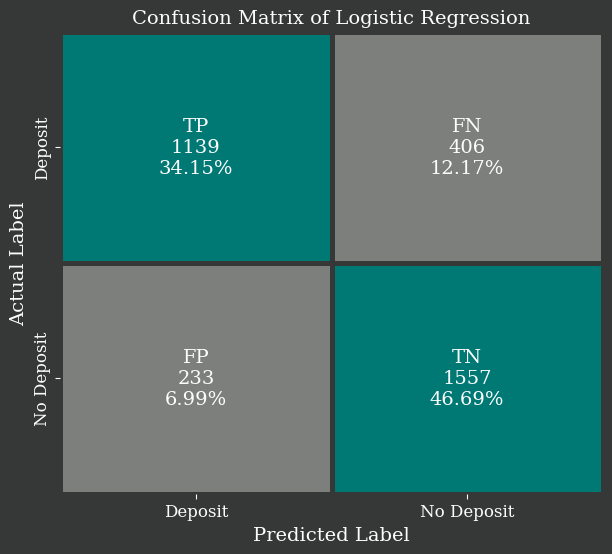

In [68]:
def models_conf_mtx_plot(conf_mtx, title):
    ''' Функция строит график матрицы ошибок модели после обучения на тренировочных и тестовых данных
        Аргументы: 
        conf_mtx - двумерный массив
        title - заголовок графика
        
        Возвращает: график матрицы ошибок
    '''
    
    # составим список меток предсказаний модели
    labels = ['TP', 'FN', 'FP', 'TN']
   
    # вычисляем количество значений по каждому результату
    labels_count = ['{0:0.0f}'.format(value) for value in conf_mtx.flatten()]
    
    # вычисляем долю каждого результата 
    labels_pct = ['{0:.2%}'.format(value) for value in conf_mtx.flatten()/np.sum(conf_mtx)]
    
    # объединяем labels, labels_count, labels_pct в список строк меток 
    labs= [f'{v1}\n{v2}\n{v3}' for v1,v2,v3 in zip(labels,labels_count,labels_pct)]
    
    # преобразуем список в двумерный массив
    lab_mtx = np.asarray(labs).reshape(2,2)
   
    # строим график матрицы ошибок
    fig, ax = plt.subplots(figsize=(7,6))
    fig.patch.set_facecolor('xkcd:dark grey')
    ax.set_facecolor('#363737')

    sns.heatmap(conf_mtx, 
                annot=lab_mtx, 
                fmt='', 
                cbar= False,
                linewidths=2.5,
                linecolor = '#363737',
                annot_kws={"size": 14,
                           "color":'#fdfdfe'},
                cmap = ['#7d7f7c', '#007974'], 
                xticklabels=[ 'Deposit', 'No Deposit'],
                yticklabels=['Deposit', 'No Deposit'])
    plt.title(title, fontsize=14, color = '#fdfdfe')
    ax.tick_params(axis='y', color = '#fdfdfe', labelsize=12, labelcolor = '#fdfdfe')
    ax.tick_params(axis='x', color = '#fdfdfe', labelsize=12, labelcolor = '#fdfdfe') 
    ax.set_xlabel('Predicted Label', fontsize =14, color = '#fdfdfe')
    ax.set_ylabel('Actual Label', fontsize =14, color = '#fdfdfe')
    plt.show();
    
models_conf_mtx_plot(lg_reg_con_mtx, 'Confusion Matrix of Logistic Regression')  


Метрика Accuracy модели логистической регрессии составляет 82% на трейне и 81% на тесте  
Также матрица ошибок говорит о том, что модель лучше выявляет класс 0 (No Deposit) доля результатов `True Negative` равен 46%, в то время как `True Positive` 34%, показатель `Ошибки II рода`, то есть доли `False Negative` составляет 12%, то есть модель предсказывает, что клиент отказался от предложения, когда на самом деле клиент согласился открыть депозит, ложно-положительные предсказания модели `False Positive` или `Ошибка I рода` составили почти 7%

Визуализируем результат работы модели логистической регрессии, с точки зрения какой вес модель присвоила каждому из 15 признаков, выбранных 
`методом SelectKBest` с помощью библитеки `ELI5`

In [69]:
# важность признаков модели логистической регрессии
eli5.show_weights(log_reg, feature_names = X_train[best_features].columns.to_list())

Мы видим,что только 10 признаков из 15-ти модель посчитала значимыми, признак с максимальным весом это проложительность контакта `duration`, в то время как признаки месяца с максимальным количеством контактов и отказов от депозита (month_may), наличия ипотеки (housing), неизвестного исхода предыдущей маркетинговой кампании(poutcome_unknown), количества контактов с клиентом (campaign) и типа контакта (contact_unknown) получили отрицательный вес 

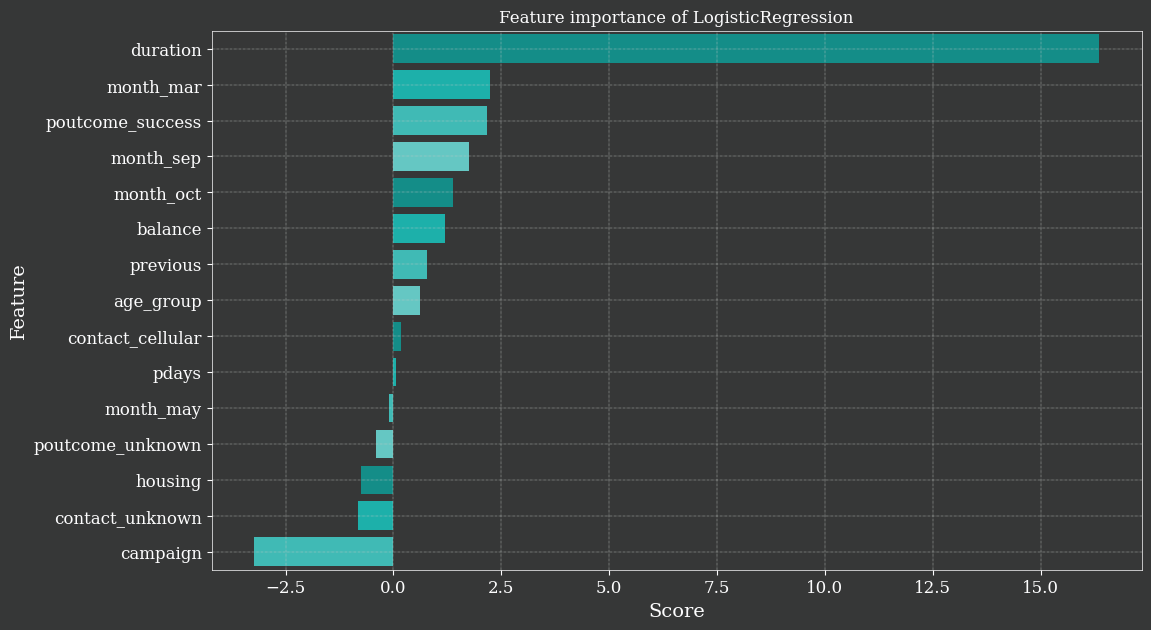

In [70]:
# Визуализируем "важность" признаков модели логистической регрессии 
# получаем коэффициенты логистической регрессии
importance = log_reg.coef_[0]

# объединяем значения коэффициентов и имена признаков в Series
features = pd.DataFrame(importance, list(X_train[best_features].columns)).reset_index()
# features.rename(columns = {})
features.columns = ['Feature', 'Score']
features_sorted = features.sort_values(by='Score', ascending = False).reset_index(drop=True)

fig, ax = plt.subplots(figsize = (12, 7))
fig.patch.set_facecolor('xkcd:dark grey')
ax.set_facecolor('#363737')

sns.barplot(x=features_sorted['Score'], 
            y=features_sorted['Feature'], 
            data=features_sorted,
            orient='h', 
            palette = ['#00a19b', '#04c8c1', '#2ccec8', '#55d7d2'])
            
           
ax.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
ax.set_ylabel('Feature', fontsize=14, color = '#fdfdfe')
ax.set_xlabel('Score', fontsize=14, color = '#fdfdfe')
ax.tick_params(axis='y', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax.tick_params(axis='x', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)
ax.set_title('Feature importance of LogisticRegression', color = '#fdfdfe')
plt.show();

In [68]:
os.environ["PATH"] += os.pathsep + 'C://Program Files//Graphviz//bin'

### Задания 2,3,4

* ### **`Decision Tree Classifier`**

Значения метрик на трейне:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

Значения метрик на тесте:

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1790
           1       0.73      0.73      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



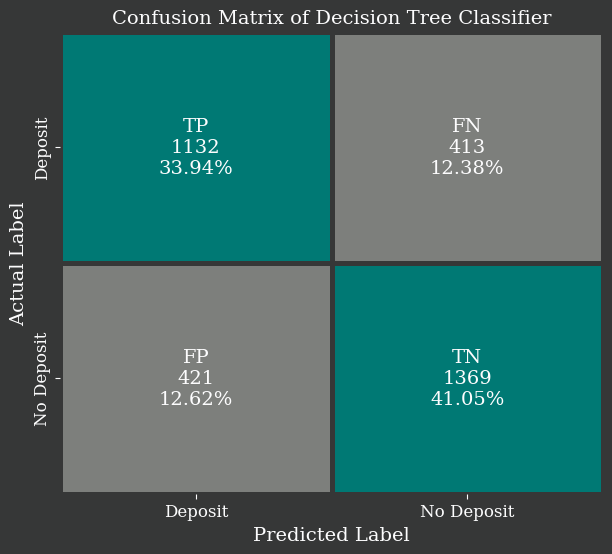

In [71]:
# обучите решающие деревья, настройте максимальную глубину
# Создаём объект класса DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(#criterion='entropy',  # критерий информативности 
                                       #max_depth=6,          # максимальная глубина
                                       random_state=42        # генератор случайных чисел
                                            )
# Обучаем дерево решений по алгоритму CART
decision_tree.fit(X_train_scaled, y_train)

#  Делаем предсказание класса для всего набора данных
y_train_pred = decision_tree.predict(X_train_scaled)
print('Значения метрик на трейне:\n')
# Выводим отчёт о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))

# Делаем предсказание класса для всего набора данных
dt_clsf_y_pred = decision_tree.predict(X_test_scaled)
print('Значения метрик на тесте:\n')
# Выводим отчёт о метриках классификации
print(metrics.classification_report(y_test, dt_clsf_y_pred))


dtcls_con_mtx = confusion_matrix(y_test, dt_clsf_y_pred, labels=[1,0])

models_conf_mtx_plot(dtcls_con_mtx, 'Confusion Matrix of Decision Tree Classifier')


Значения метрики `accuracy` модели решающих деревьев на трейне составила 82%, на тесте показатель составил 81% - то есть присутствует незначительное улучшение. Также судя по матрице ошибок, модель распознала 39% записей как `True Positive` и 41.5% как `True Negative`, хотя дисбаланс в сторону последней сохраняется, тем не менее модель решающих деревьев, сократила разрыв между истинно положительным и истинно негативным исходами по сравнению с моделью логистической регресии почти на 12%. Однако, с другой стороны, увеличилось количество `False Positive` предсказаний до 12% (почти в 2 раза в сравнении с показателями логистической регрессии) и уменьшение доли `False Negative`, то есть увеличилось количество `ошибок I рода`. 

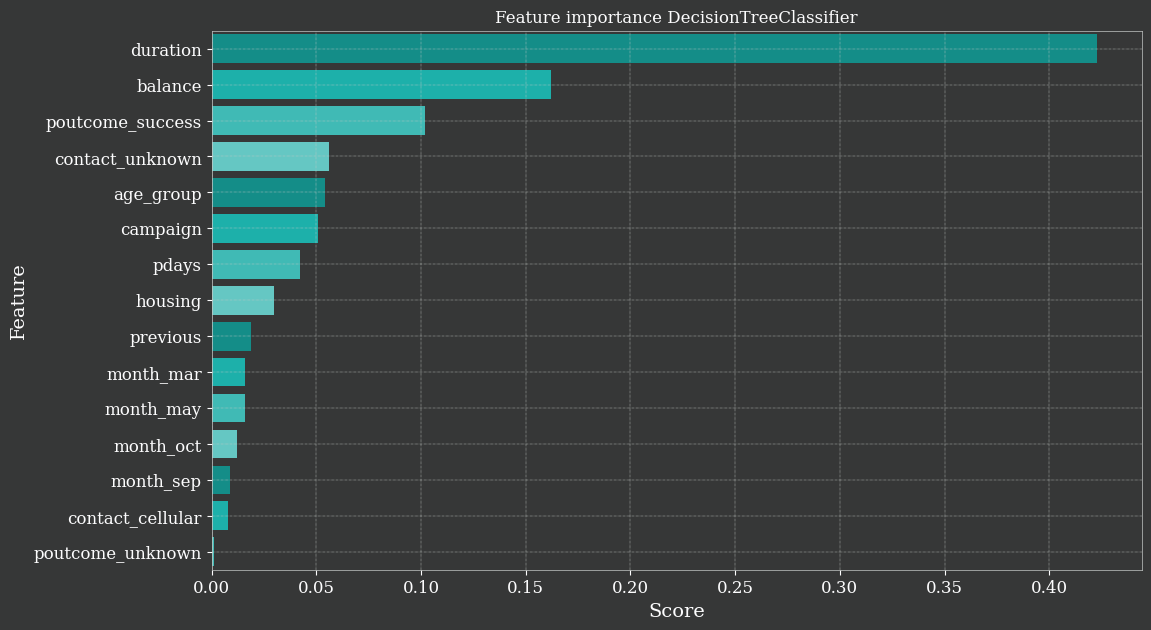

In [72]:
# визуализируем важность признаков модели решающих деревьев

importance = pd.DataFrame(np.round(decision_tree.feature_importances_, 3),
                       list(X_train[best_features].columns)).reset_index()
importance.columns = ['Feature', 'Score']
importance_sorted = importance.sort_values(by='Score', ascending = False)

fig, ax = plt.subplots(figsize = (12, 7))
fig.patch.set_facecolor('xkcd:dark grey')
ax.set_facecolor('#363737')
sns.barplot(x=importance_sorted['Score'], 
            y=importance_sorted['Feature'], 
            data=importance_sorted,
            orient='h', 
            palette = ['#00a19b', '#04c8c1', '#2ccec8', '#55d7d2'])

           
ax.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax.spines[['top', 'bottom', 'left', 'right']].set_color('#c5c9c7')
ax.set_ylabel('Feature', fontsize=14, color = '#fdfdfe')
ax.set_xlabel('Score', fontsize=14, color = '#fdfdfe')
ax.tick_params(axis='y', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax.tick_params(axis='x', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)
       
plt.title('Feature importance DecisionTreeClassifier', color = '#fdfdfe')
plt.show()

Важными модель посчитала следующие признаки:
* `duration` - продолжительность контакта
* `poutcome_success` - положительный исход предыдущей маркетинговой кампании
* `contact_unknown` - неизвестный способ контакта

### Задание 5

Применим `метод GridSearchCV` для поиска оптимальных параметров модели решающих деревьев, далее обучим модель и сравним значения метрик 

In [73]:
# подберите оптимальные параметры с помощью gridsearch

from sklearn.model_selection import GridSearchCV
# создаем объект модели Decision Tree 
dtree = DecisionTreeClassifier()
# создаем список параметров модели
tree_params = [{'splitter': ['best', 'random'],
                'min_samples_split': list(range(0,11)),
                'max_depth': list(range(0,11)),
                'criterion': ['gini', 'entropy'],
                'min_samples_leaf': list(range(0,11)),
                'random_state':list(range(41,43))
                }]
# создаем объект алгоритма GridSearchCV
gs_model = GridSearchCV(dtree, tree_params, cv=5, verbose=1)
# обучаем модель\находим оптимальные параметры модели
gs_model.fit(X_train_scaled, y_train)
# предсказываем значения на тренировочных данных
y_train_pred = gs_model.predict(X_train_scaled)
# выводим значения параметров 
print('Лучшие значения параметров модели:\n{}'.format(gs_model.best_params_))
print('='*130)
print('Среднее значение по фолдам: {}'.format(gs_model.best_score_))


Fitting 5 folds for each of 10648 candidates, totalling 53240 fits
Лучшие значения параметров модели:
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 2, 'random_state': 41, 'splitter': 'random'}
Среднее значение по фолдам: 0.8211225997045789


Значения метрик на трейне:

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      3634
           1       0.82      0.82      0.82      3136

    accuracy                           0.83      6770
   macro avg       0.83      0.83      0.83      6770
weighted avg       0.83      0.83      0.83      6770

Значения метрик на тесте:

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.79      0.81      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



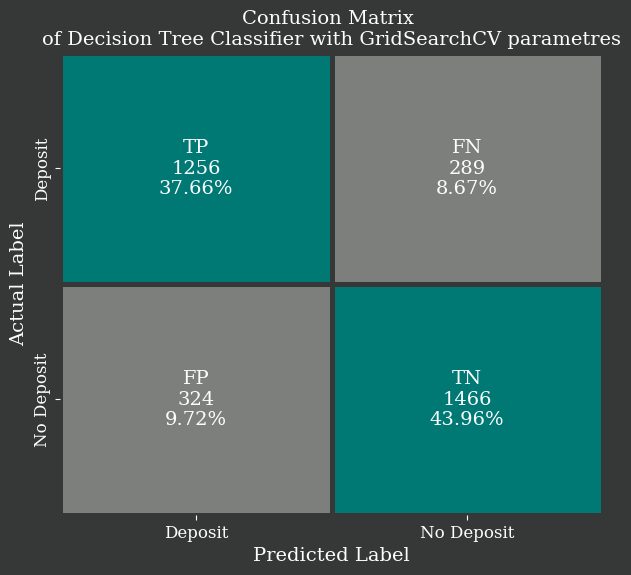

In [74]:
# передаем полученные выше параметры в модель решающих леревьев
gridscv_tree = DecisionTreeClassifier(criterion='gini',        #  критерий информативности 
                                        max_depth=10,          #  максимальная глубина
                                        min_samples_leaf = 8,  #  максиамальное количество листьев
                                        min_samples_split=2,   #  макисмальное разделение внутреннего узла
                                        splitter = 'random',   #  стратегия наилучшего лучайного разбиения 
                                        random_state=41        #  генератор случайных чисел
                                        )

#  обучаем модель
gridscv_tree.fit(X_train_scaled, y_train)

#  делаем предсказание класса для всего набора данных
y_train_pred = gridscv_tree.predict(X_train_scaled)
print('Значения метрик на трейне:\n')
#  выводим отчёт о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))

#  делаем предсказание класса для всего набора данных
gridscv_y_pred = gridscv_tree.predict(X_test_scaled)
print('Значения метрик на тесте:\n')
#  выводим отчёт о метриках классификации
print(metrics.classification_report(y_test, gridscv_y_pred))

# строим матрицу ошибок для модели DecisionTreeClassifier
gridscv_con_mtx = confusion_matrix(y_test, gridscv_y_pred, labels=[1,0])
# вызываем функцию визуализации матрицы ошибок
models_conf_mtx_plot(gridscv_con_mtx, 'Confusion Matrix \nof Decision Tree Classifier with GridSearchCV parametres')

Значения метрики `Accuracy` на тесте незначительно улучшилось с 81% до 82%, однако `True Positive` предсказания модели ухудшились с 39% до 37.6% и в то же время увеличилось доля `True Negative` c 41% до почти 44%, то есть модель лучше распознает объекты класса 0 - отсутствие депозита, снизилась вероятность `Ошибки I рода` с 12% до 9.7%, но незначительно возросла вероятность `Ошибки II рода` с 7%  до 8.5%
Разница между значениями метрик на трейне и тесте составляет - 1-2% 

### Задание 5.5

#### `Условия для GridSearch`
* 'min_samples_split': [2, 5, 7, 10],  
* 'max_depth':[3,5,7]                

In [76]:
dtree = DecisionTreeClassifier()
# создаем список параметров модели
tree_params = [{'min_samples_split': [2, 5, 7, 10],
                'max_depth': [3,5,7]}]
# создаем объект алгоритма GridSearchCV
gs_model = GridSearchCV(dtree, tree_params, cv=5, verbose=1)
# обучаем модель\находим оптимальные параметры модели
gs_model.fit(X_train_scaled, y_train)
# предсказываем значения на тренировочных данных
y_train_pred = gs_model.predict(X_train_scaled)
# выводим значения параметров 
print('Лучшие значения параметров модели:\n{}'.format(gs_model.best_params_))
print('='*130)
print('Среднее значение по фолдам: {}'.format(gs_model.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие значения параметров модели:
{'max_depth': 7, 'min_samples_split': 2}
Среднее значение по фолдам: 0.8146233382570163


### Проверим какая глубина оптимальна на примере графика метрики F1 score

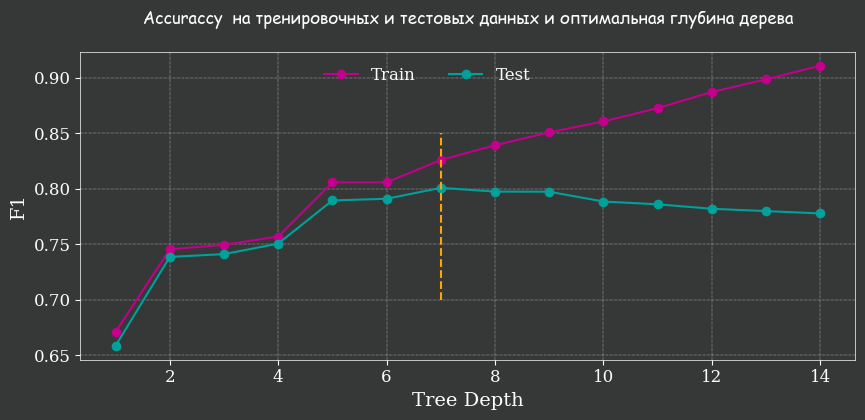

In [79]:
max_depth_list = [i for i in range(1, 15)]

train_scores = [] 
test_scores = [] 

for i in max_depth_list:
    model = DecisionTreeClassifier(max_depth=i, random_state=42) 
    
    model.fit(X_train_scaled,y_train)
    
    train_depth = model.predict(X_train_scaled)
    train_acc = metrics.f1_score(y_train, train_depth)
    train_scores.append(train_acc)
    
    test_depth = model.predict(X_test_scaled)
    test_acc = metrics.f1_score(y_test, test_depth)
    test_scores.append(test_acc)

fig, ax = plt.subplots(figsize=(10, 4))
fig.patch.set_facecolor('xkcd:dark grey')
ax.set_facecolor('#363737')
plt.rcParams["font.family"] = "serif"

ax.plot(max_depth_list, train_scores, label='Train', marker='o', color='#c2008c') 
ax.plot(max_depth_list, test_scores, label='Test', marker='o', color='#00a19b')
ax.vlines(7,0.700,0.850, linestyles='--', colors='orange')
ax.set_title('Accuraccy  на тренировочных и тестовых данных и оптимальная глубина дерева', fontname = 'Comic Sans MS', color = '#fdfdfe', pad=20)
ax.set_xlabel('Tree Depth', fontsize=14, color = '#fdfdfe')
ax.set_ylabel('F1', fontsize=14, color = '#fdfdfe') 
ax.tick_params(axis='x', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax.tick_params(axis='y', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax.spines[['top', 'bottom', 'left', 'right']].set_color('#fdfdfe')
ax.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)
plt.legend(bbox_to_anchor =(0.6, 1.), frameon= False,  facecolor = '#363737', labelcolor = '#fdfdfe', fontsize=12, ncol = 2)
plt.show(); 

Значения метрик на трейне:

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      3634
           1       0.82      0.83      0.82      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

Значения метрик на тесте:

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      1790
           1       0.79      0.82      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



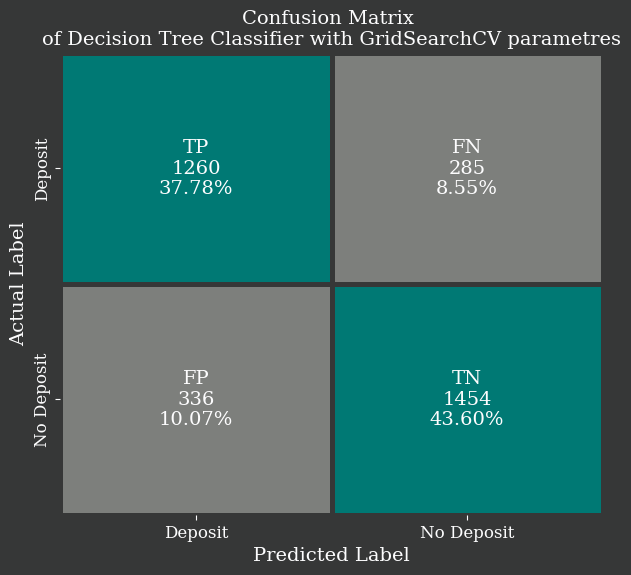

In [80]:
# передаем полученные выше параметры в модель решающих леревьев
grids_tree = DecisionTreeClassifier(max_depth=7,              #  максимальная глубина
                                      min_samples_split=10,   #  максимальное разделение внутреннего узла
                                      random_state=42)        #  генератор случайных чисел
                                    

#  обучаем модель
grids_tree.fit(X_train_scaled, y_train)

#  делаем предсказание класса для всего набора данных
grids_train_pred = grids_tree.predict(X_train_scaled)
print('Значения метрик на трейне:\n')
#  выводим отчёт о метриках классификации
print(metrics.classification_report(y_train, grids_train_pred))

#  делаем предсказание класса для всего набора данных
grids_test_pred = grids_tree.predict(X_test_scaled)
print('Значения метрик на тесте:\n')
#  выводим отчёт о метриках классификации
print(metrics.classification_report(y_test, grids_test_pred))

# строим матрицу ошибок для модели DecisionTreeClassifier
gridscv_con_mtx = confusion_matrix(y_test, grids_test_pred, labels=[1,0])
# вызываем функцию визуализации матрицы ошибок
models_conf_mtx_plot(gridscv_con_mtx, 'Confusion Matrix \nof Decision Tree Classifier with GridSearchCV parametres')

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

* ### **`Random Forest`**

### `Обучите случайный лес со следующими параметрами:`

* n_estimators = 100,
* criterion = 'gini',
* min_samples_leaf = 5,
* max_depth = 10,
* random_state = 42

Значения метрик на трейне:

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Значения метрик на тесте:

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



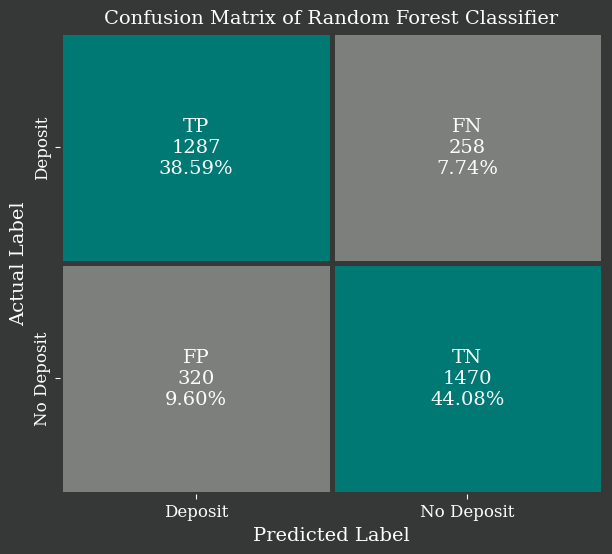

In [81]:
# обучите на ваших данных случайный лес
# создаем объект модели RandomForest
rf_model = ensemble.RandomForestClassifier(n_estimators = 100,
                                           criterion = 'gini',
                                           min_samples_leaf = 5,
                                           max_depth = 10,
                                           random_state = 42)
# обучаем модель 
rf_model.fit(X_train_scaled, y_train)
# предсказываем значения таргета на тренировочных данных
y_train_pred = rf_model.predict(X_train_scaled)

# выводим значения метрик на тренировочных данных
print('Значения метрик на трейне:\n')

print(metrics.classification_report(y_train, y_train_pred))

# предсказываем значения таргета на тестовых данных
rf_y_pred = rf_model.predict(X_test_scaled)
# выводим значения метрик на тестовых данных
print('Значения метрик на тесте:\n')
print(metrics.classification_report(y_test, rf_y_pred))
# строим матрицу ошибок для модели Random Forest
rf_gridscv_con_mtx = confusion_matrix(y_test, rf_y_pred, labels=[1,0])
# вызываем функцию визуализации матрицы ошибок
models_conf_mtx_plot(rf_gridscv_con_mtx, 'Confusion Matrix of Random Forest Classifier')

In [77]:
# с помощью GridSearchCV найдем параметры для модели случайного леса
rfc=ensemble.RandomForestClassifier(random_state=41)

param_grid = { 
    'n_estimators': [100, 200],               # количество деревьев
    'max_features': ['auto', 'sqrt', 'log2'], # количество признаков для лучшего разделения
    'max_depth' : [4,5,6,7,8],                # макстмальная глубина 
    'criterion' : ['gini', 'entropy'],        # критерий ветвления 
    'random_state': [41,42,43]              
}
# создаем объект GridSearchCV
rf_grids = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# обучаем модель
rf_grids.fit(X_train_scaled, y_train)

# выводим лучшие параметры модели
print('Лучшие параметры модели:\n{}'.format(rf_grids.best_params_))
print()
print('Среднее значение по фолдам: {}'.format(rf_grids.best_score_))

Лучшие параметры модели:
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200, 'random_state': 43}

Среднее значение по фолдам: 0.8361890694239291


Значения метрик на трейне:

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Значения метрик на тесте:

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



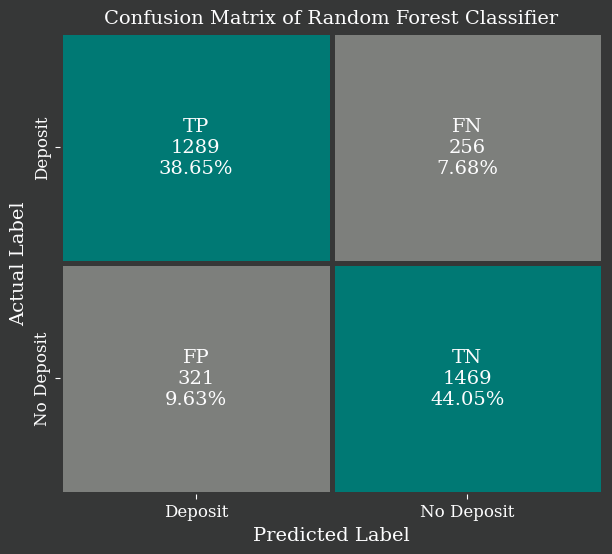

In [82]:
# обучите на ваших данных случайный лес
# создаем объект модели RandomForest
rf_gridsvc = ensemble.RandomForestClassifier(criterion='entropy',
                                             max_depth=8,
                                             max_features = 'auto',
                                             n_estimators=200,
                                             random_state=43
                                             )
# обучаем модель 
rf_gridsvc.fit(X_train_scaled, y_train)
# предсказываем значения таргета на тренировочных данных
y_train_pred = rf_gridsvc.predict(X_train_scaled)

# выводим значения метрик на тренировочных данных
print('Значения метрик на трейне:\n')

print(metrics.classification_report(y_train, y_train_pred))

# предсказываем значения таргета на тестовых данных
rf_y_pred = rf_gridsvc.predict(X_test_scaled)
# выводим значения метрик на тестовых данных
print('Значения метрик на тесте:\n')
print(metrics.classification_report(y_test, rf_y_pred))
# строим матрицу ошибок для модели Random Forest
rf_gridscv_con_mtx = confusion_matrix(y_test, rf_y_pred, labels=[1,0])
# вызываем функцию визуализации матрицы ошибок
models_conf_mtx_plot(rf_gridscv_con_mtx, 'Confusion Matrix of Random Forest Classifier')

Модель `Random Forest` показала незначительное улучшение метрики `Accuracy` на тесте 83%, против значения  82% у модели `Decision Tree`, разница между значениями на трейне и тесте составляют 3%. Матрица ошибок показывает улучшение `True Positive` предсказаний 38.6% против 37.6% у `Decision Tree`, значения позиции `True Negative` схож со значением у модели `Dicision Tree`, незначительно снизилась вероятность `ошибки II рода`, то есть значение `False Negative`. Модель лучше распознает объекты `класса 0` (`No Deposit`)

In [83]:
# важность признаков модели Random Forest ELI5
eli5.show_weights(rf_gridsvc, feature_names=list(X_train[best_features].columns))

Визуализируем важность признаков модели Random Forest

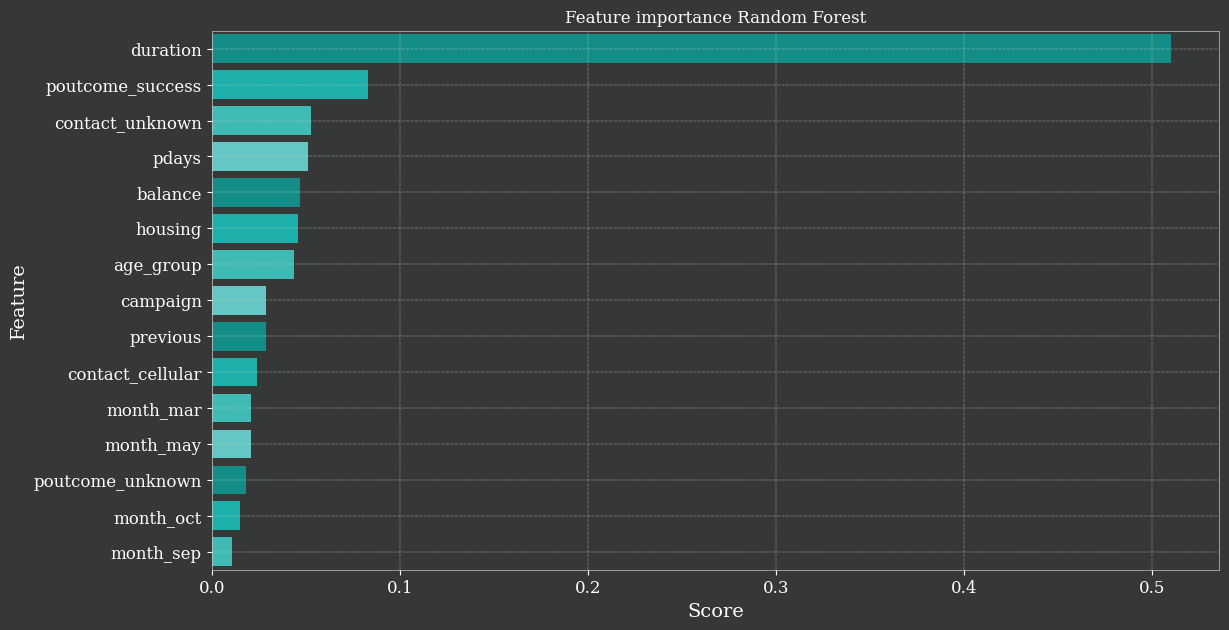

In [84]:
# объединим значения и признаки модели
importance = pd.DataFrame({'Feature' : list(X_train[best_features].columns),
                           'Score': np.round(rf_gridsvc.feature_importances_, 3)})
importance_sorted = importance.sort_values(by='Score', ascending = False).reset_index(drop=True)
                

# визуализируем важные признаки 
fig, ax = plt.subplots(figsize = (13, 7))
fig.patch.set_facecolor('xkcd:dark grey')
ax.set_facecolor('#363737')
sns.barplot(x=importance_sorted['Score'], 
            y=importance_sorted['Feature'], 
            data=importance_sorted,
            orient='h', 
            palette =  ['#00a19b', '#04c8c1', '#2ccec8', '#55d7d2'])

ax.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax.spines[['top', 'bottom', 'left', 'right']].set_color('#c5c9c7')
ax.set_ylabel('Feature', fontsize=14, color = '#fdfdfe')
ax.set_xlabel('Score', fontsize=14, color = '#fdfdfe')
ax.tick_params(axis='y', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax.tick_params(axis='x', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)

plt.title('Feature importance Random Forest', color = '#fdfdfe')     
plt.show();

Среди признаков модель Random Forest выделила следующие как более важные  
* `duration` - продолжительность контакта
* `poutcome_success` - положительный результат предыдущей кампании


### Задания 2 и 3

* ### **`Gradient Boosting Classifier`**

In [ ]:
learning_rate = 0.05,
n_estimators = 300,
min_samples_leaf = 5,
max_depth = 5
random_state = 42

Значения метрик на трейне:

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

Значения метрик на тесте:

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



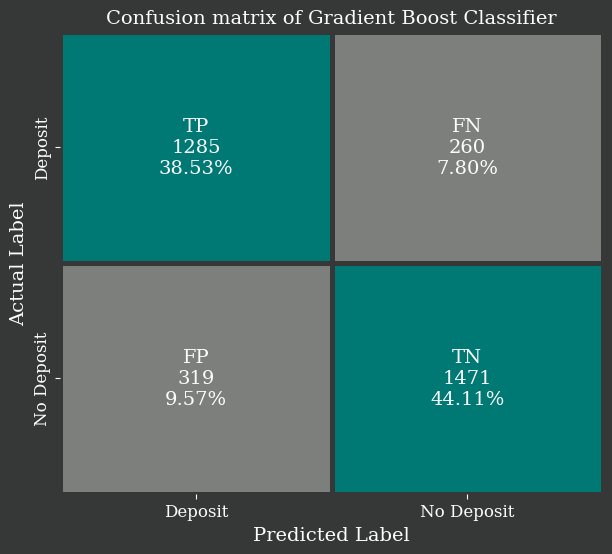

In [85]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
# создаем объект Gradient Boosting
gboost_model = GradientBoostingClassifier(learning_rate = 0.05,
                                            n_estimators = 300,
                                            min_samples_leaf = 5,
                                            max_depth = 5,
                                            random_state = 42
                                            )
    

# обучаем модель
gboost_model.fit(X_train_scaled, y_train)
# предсказываем таргет на тренировочных данных
y_train_pred = gboost_model.predict(X_train_scaled)
# выводим метрики модели на тренировочных данных
print('Значения метрик на трейне:\n')
print(metrics.classification_report(y_train, y_train_pred))

# предсказываем таргет на тестовых данных
gboost_y_pred = gboost_model.predict(X_test_scaled)
# выводим метриеи модели на тестовых данных 
print('Значения метрик на тесте:\n')
print(metrics.classification_report(y_test, gboost_y_pred))
# строим матрицу ошибок модели Gradient Boosting
gboost_cnf_mtx = confusion_matrix(y_test, gboost_y_pred, labels=[1,0])
# вызываем функцию визуализации матрицы ошибок модели Gradient Boosting
models_conf_mtx_plot(gboost_cnf_mtx, 'Confusion matrix of Gradient Boost Classifier')


значение метрики `Accuracy` модели `Gradient Boosting` на тесте показал *83%*, что соответствует значению метрики модели `Random Forest`, тем не менее матрица ошибок говорит, что показатель `True Positive` в *38.5%* меньше показателя `True Positve` модели `Random Forest`, который составляет *38.5%*, наблюдается незначительное увеличение доли `True Negative` предсказаний `Gradient Boosting` по сравнению с `Random Forest` c *44%* до *44.1%*, а также вероятности` ошибки II рода False Negative` предсказаний с *7.6%* до *7.38%*

In [373]:
# важность признаков модели Gradient Boosting
eli5.show_weights(gboost_model, feature_names=list(X_train[best_features].columns))

Визуализируем важные признаки модели Gradient Boosting

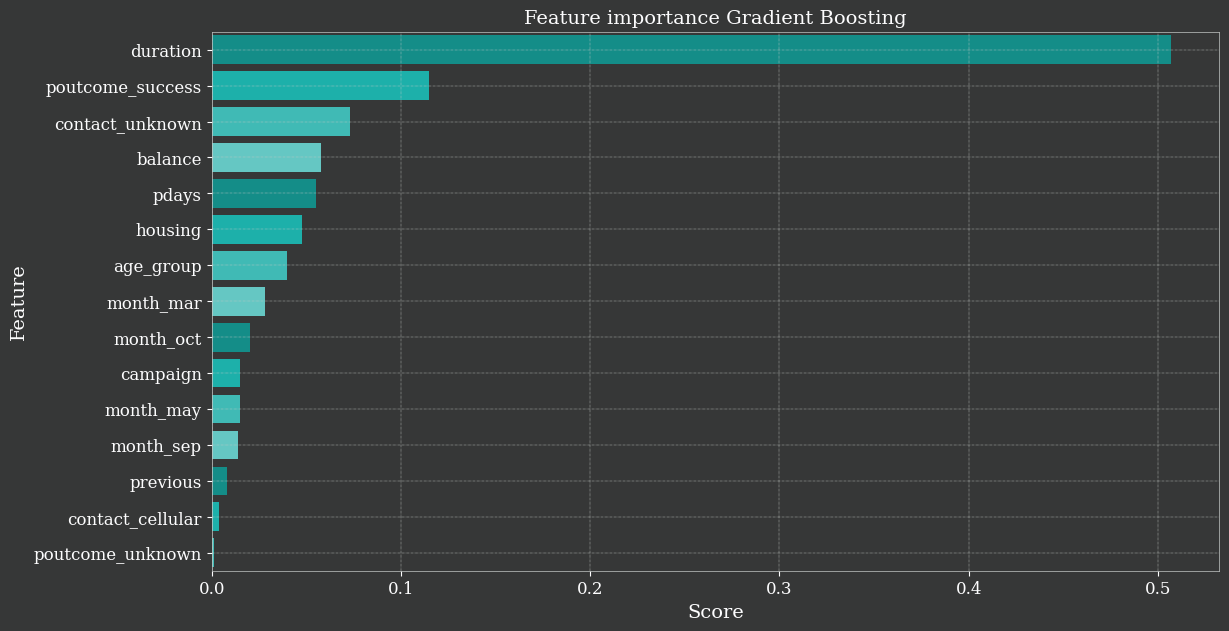

In [86]:
# объединим значения и признаки модели
importance = pd.DataFrame({'Feature': list(X_train[best_features].columns), 
                        'Score' : np.round(gboost_model.feature_importances_, 3)})
importance_sorted = importance.sort_values(by = 'Score', ascending = False).reset_index(drop=True)

# визуализируем важные признаки 
fig, ax = plt.subplots(figsize = (13, 7))
fig.patch.set_facecolor('xkcd:dark grey')
ax.set_facecolor('#363737')

sns.barplot(x=importance_sorted['Score'], 
            y=importance_sorted['Feature'], 
            data=importance_sorted,
            orient='h', 
            palette =  ['#00a19b', '#04c8c1', '#2ccec8', '#55d7d2'])

ax.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax.spines[['top', 'bottom', 'left', 'right']].set_color('#c5c9c7')
ax.set_ylabel('Feature', fontsize=14, color = '#fdfdfe')
ax.set_xlabel('Score', fontsize=14, color = '#fdfdfe')
ax.tick_params(axis='y', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax.tick_params(axis='x', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)

plt.title('Feature importance Gradient Boosting', fontsize=14, color = '#fdfdfe')
plt.show()

Среди наиболее важных признаков модель Gradient Boosting отметила 
* `duration` -продожительность контакта
* `poutcome_success` - положительный результат предыдущей маркетинговой кампании

In [ ]:
'''def plot_importance(estimator, X, y, ax, kind_set):
    
    res = permutation_importance(estimator, X, y, n_repeats = 10, random_state = 4, n_jobs = -2)   
    sorted_importance = res.importances_mean.argsort()  
    fig, ax = plt.subplots(figsize=(14, 8))
    fig.patch.set_facecolor('xkcd:dark grey')
    ax.set_facecolor('#363737')
    ax.boxplot(res.importances[sorted_importance].T, 
               vert = False, 
               labels = X_skb.columns[sorted_importance], 
               widths = 0.6,
               showcaps = False,
               boxprops = {"facecolor": '#04c8c1', 
                           "edgecolor": '#04c8c1', 
                           "linewidth": 0.5},
               flierprops = {"marker": "o",
                             "markerfacecolor":'#007974',
                             "linewidth" : .05, 
                             "markeredgecolor" : '#363737', 
                             "markersize" : 7, },
               medianprops = {"color": "maroon"},
               whiskerprops = {'linestyle': 'solid', 
                                'linewidth': 0.5, 
                                'color': '#fdfdfe'},
               patch_artist = True)
    ax.axvline(x = 0 , color = 'r', linestyle = '--')
    ax.set_title("Permutation Importances\n({})".format(kind_set), fontsize=16, color = '#fdfdfe');
    ax.set_ylabel('Feature', fontsize=14, color = '#fdfdfe');
    ax.set_xlabel('Accuracy score', fontsize=14, color = '#fdfdfe');
    ax.tick_params(axis='y', labelsize=14, color = '#fdfdfe', labelcolor = '#fdfdfe')
    ax.tick_params(axis='x', labelsize=14, color = '#fdfdfe', labelcolor = '#fdfdfe')
    ax.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
    ax.spines[['top', 'bottom', 'left', 'right']].set_color('#c5c9c7')
    ax.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)
    ax.figure.tight_layout()
    
    return plt.show()'''
    

#### применим метод `permutation importance` для выявления "важности" признаков

In [87]:
# вычислим permutation importance для каждой модели
# на тренировочных данных
perm_lr_train = permutation_importance(log_reg, X_train_scaled, y_train)
perm_dt_train = permutation_importance(decision_tree, X_train_scaled, y_train)
perm_grids_dt_train = permutation_importance(grids_tree, X_train_scaled, y_train)
perm_rf_train = permutation_importance(rf_model, X_train_scaled, y_train)
perm_grids_rf_train = permutation_importance(rf_gridsvc, X_train_scaled, y_train)


# на тестовых данных
perm_lr_test = permutation_importance(log_reg, X_test_scaled, y_test)
perm_dt_test = permutation_importance(decision_tree, X_test_scaled, y_test)
perm_grids_dt_test = permutation_importance(grids_tree, X_test_scaled, y_test)
perm_rf_test = permutation_importance(rf_model, X_test_scaled, y_test)
perm_grids_rf_test = permutation_importance(rf_gridsvc, X_test_scaled, y_test)


train_results = ['perm_lr_train', 'perm_dt_train', 'perm_grids_dt_train', 'perm_rf_train', 'perm_grids_rf_train']

test_results = ['perm_lr_test', 'perm_dt_test', 'perm_grids_dt_test', 'perm_rf_test', 'perm_grids_rf_test']

models_names = ['Logistic Regression', 'Decision Tree (default)', 'Decision Tree (GridSearch)', 'Random Forest', 'Random Forest (GridSearch)']


### `Функция визуализации важности признаков для модели № 1`

In [138]:
'''model_name = ['Logistic Regression', 'Decision Tree', 'Decision Tree(gridsearch)', 'Random Forest', 'Random Forest (gridsearch)', 
              'Gradient Boosting']
estimator = ['log_reg', 'decision_tree', 'grids_tree', 'rf_model', 'rf_gridsvc', 'gboost_model']

def plot_feature_importance(model_name, est, columns):
    if model_name == 'Logistic Regression':
        df = pd.DataFrame({'Features' : list(columns),'Score' : np.round(est.coef_[0], 3)}).sort_values(by='Score', ascending = False).reset_index(drop=True)

            #df.columns = ['Feature', 'Score']
            #df = features.sort_values(by='Score', ascending = False).reset_index(drop=True)

        fig, ax = plt.subplots(figsize = (12, 7))
        fig.patch.set_facecolor('xkcd:dark grey')
        ax.set_facecolor('#363737')
        sns.barplot(x=df['Score'], 
                        y=df['Features'], 
                        data=df,
                        orient='h', 
                        palette = ['#00a19b', '#04c8c1', '#2ccec8', '#55d7d2'])

           
        ax.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
        ax.spines[['top', 'bottom', 'left', 'right']].set_color('#c5c9c7')
        ax.set_ylabel('Feature', fontsize=14, color = '#fdfdfe')
        ax.set_xlabel('Score', fontsize=14, color = '#fdfdfe')
        ax.tick_params(axis='y', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
        ax.tick_params(axis='x', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
        ax.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)
       
        plt.title('Feature importance of ' + model_name, color = '#fdfdfe')
        plt.show()
        
            
        
    else: 
            
        df = pd.DataFrame({'Features' : list(columns),'Score': np.round(est.feature_importances_, 3)}).sort_values(by='Score', ascending = False).reset_index(drop=True)
           

        fig, ax = plt.subplots(figsize = (12, 7))
        fig.patch.set_facecolor('xkcd:dark grey')
        ax.set_facecolor('#363737')
        sns.barplot(x=df['Score'], 
                        y=df['Features'], 
                        data=df,
                        orient='h', 
                        palette = ['#00a19b', '#04c8c1', '#2ccec8', '#55d7d2'])

           
        ax.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
        ax.spines[['top', 'bottom', 'left', 'right']].set_color('#c5c9c7')
        ax.set_ylabel('Feature', fontsize=14, color = '#fdfdfe')
        ax.set_xlabel('Score', fontsize=14, color = '#fdfdfe')
        ax.tick_params(axis='y', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
        ax.tick_params(axis='x', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
        ax.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)
       
        plt.title('Feature importance of ' + model_name, color = '#fdfdfe')
        plt.show()'''
            
            
             

### `Функция визуализации важности признаков для модели № 2`

In [90]:
# объединим модели в список
models_name = ['Logistic Regression', 'Decision Tree', 'Decision Tree(gridsearch)', 'Random Forest', 'Random Forest (gridsearch)',
               'Gradient Boosting']
# объединим коэффициенты важности в список
importance = [log_reg.coef_[0], decision_tree.feature_importances_, grids_tree.feature_importances_, 
            rf_model.feature_importances_, rf_gridsvc.feature_importances_, gboost_model.feature_importances_]
# объединим модели и коэффициенты в словарь
models = {name : imp for name, imp in zip(models_name, importance)}
# создадим датафрейм из словаря
models_df = pd.DataFrame.from_dict(models, orient = 'index', columns = X[best_features].columns)
models_df.reset_index(drop=False, inplace = True)
models_df.rename(columns={'index':'model_name'}, inplace = True)
models_df = models_df.melt(id_vars = 'model_name', var_name = 'features', value_name = 'importance_score')
models_df


model_name          features  importance_score
0          Logistic Regression           balance          1.194602
1                Decision Tree           balance          0.161850
2    Decision Tree(gridsearch)           balance          0.020142
3                Random Forest           balance          0.047554
4   Random Forest (gridsearch)           balance          0.047019
..                         ...               ...               ...
85               Decision Tree  poutcome_unknown          0.001118
86   Decision Tree(gridsearch)  poutcome_unknown          0.000000
87               Random Forest  poutcome_unknown          0.023929
88  Random Forest (gridsearch)  poutcome_unknown          0.018105
89           Gradient Boosting  poutcome_unknown          0.001382

[90 rows x 3 columns]

In [95]:
# напишем функцию визуализации важности признаков для каждой модели 
def feature_vis(data, df, name, score, feature):
    
    fig, ax = plt.subplots(figsize = (8, 16))
    fig.patch.set_facecolor('xkcd:dark grey')
    ax.set_facecolor('#363737')

    
    plt.axvline(0,linewidth=.5, color='#ffffc2', ls = 'dotted')
    [plt.axhline(i + .5, linewidth=.5, color = '#ffffc2', ls = 'dotted') for i in range(0, len(data) + 1)]

    sns.barplot(x=df[score], 
                y=df[feature], 
                hue = df[name],
                data=df,
                orient='h', 
                palette = 'inferno'
                )
     
    ax.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
    ax.spines[['top', 'bottom', 'left', 'right']].set_color('#c5c9c7')
    ax.set_ylabel('Feature', fontsize=14, color = '#fdfdfe')
    ax.set_xlabel('Score', fontsize=14, color = '#fdfdfe')
    ax.tick_params(axis='y', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
    ax.tick_params(axis='x', labelsize=12, color = '#fdfdfe', labelcolor = '#fdfdfe')
    ax.grid(color='#c5c9c7', linestyle='-.', linewidth=0.1)
    plt.legend(bbox_to_anchor =(.98, .15), frameon = True, facecolor = '#d8dcd6', fontsize=12, labelcolor = '#343837')       
    plt.title('Feature importance of Models', color = '#fdfdfe')
    plt.show();

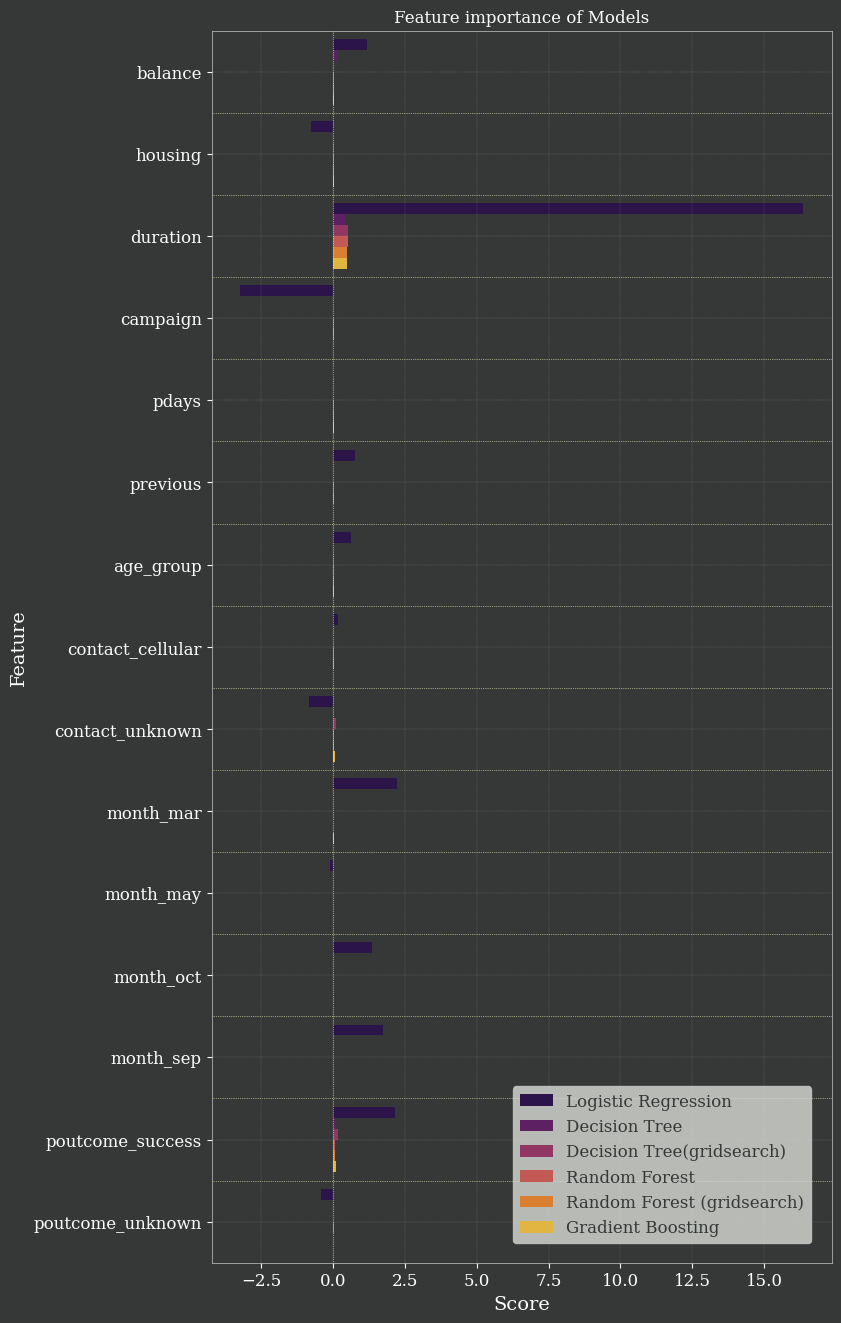

In [96]:
feature_vis(X[best_features].columns, models_df, 'model_name', 'importance_score', 'features')

In [226]:
# на тестовых данных
perm_lr_test = permutation_importance(log_reg, X_test_scaled, y_test)
perm_dt_test = permutation_importance(decision_tree, X_test_scaled, y_test)
perm_grids_dt_test = permutation_importance(grids_tree, X_test_scaled, y_test)
perm_rf_test = permutation_importance(rf_model, X_test_scaled, y_test)
perm_grids_rf_test = permutation_importance(rf_gridsvc, X_test_scaled, y_test)
perm_gboost_model_test = permutation_importance(rf_gridsvc, X_test_scaled, y_test)


In [476]:
test_results = [perm_lr_test, perm_dt_test, perm_grids_dt_test, perm_rf_test, perm_grids_rf_test, perm_gboost_model_test]

models_names = ['Logistic Regression', 'Decision Tree (default)', 'Decision Tree (GridSearch)', 
                'Random Forest', 'Random Forest (GridSearch)', 'Gradient Boosting']

mod_perm = {name : res['importances_mean'] for name, res in zip(models_name, test_results)}
mod_perm = pd.DataFrame.from_dict(mod_perm, orient = 'index', columns = X[best_features].columns)
mod_perm.reset_index(drop=False, inplace = True)
mod_perm.rename(columns={'index':'model_name'}, inplace = True)


In [480]:
list = ['balance', 'housing', 'duration', 'campaign', 'pdays','previous', 
        'age_group', 'contact_cellular', 'contact_unknown','month_mar', 
        'month_may', 'month_oct', 'month_sep', 'poutcome_success',
        'poutcome_unknown']

In [481]:
models_perm = mod_perm.melt(id_vars = 'model_name', value_vars = list, var_name = 'features', value_name = 'permutation_score')

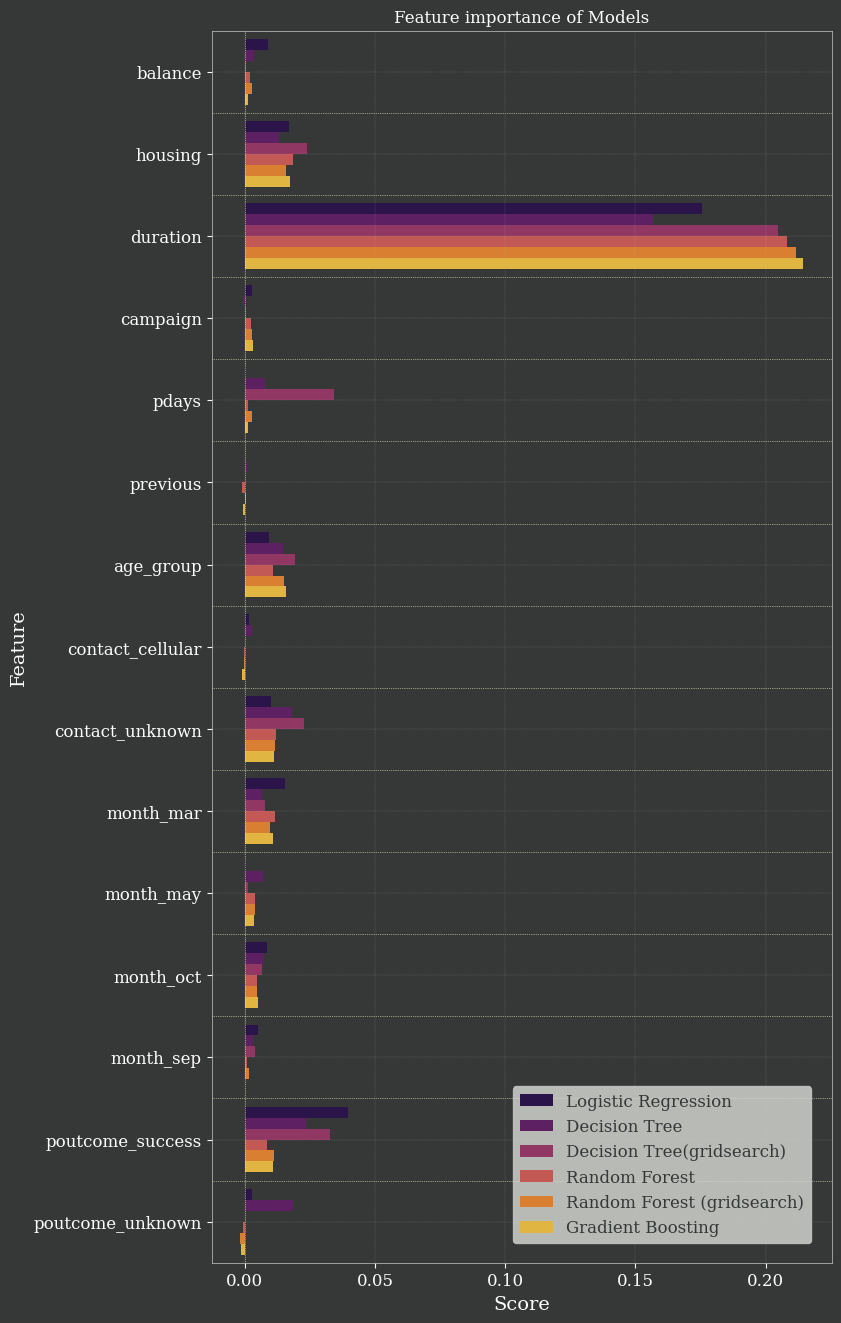

In [558]:
feature_vis(X[best_features].columns, models_perm, 'model_name', 'permutation_score', 'features')

### Задание 4

In [540]:
# объедините уже известные вам алгоритмы с помощью стекинга 
# создаем список моделей 
model_stack = [('Logistic Regression', linear_model.LogisticRegression(
                solver = 'sag', 
                random_state=42, 
                max_iter=1000)
            ),
            ('Decision Tree', DecisionTreeClassifier(
                max_depth=7,
                min_samples_split = 2, 
                random_state=42)
            ),
            ('Random Forest', ensemble.RandomForestClassifier(
                n_estimators=100, 
                criterion='gini',
                min_samples_leaf = 5,
                max_depth=10,
                random_state=42)
            ),
            ('Gradient Boost', GradientBoostingClassifier(
                learning_rate = 0.05,
                n_estimators = 300,
                min_samples_leaf = 5,
                max_depth = 5,
                random_state = 42)
            )
            ]
# создаем объект Stacking Classifier
stack = StackingClassifier(
                estimators=model_stack,
                final_estimator=linear_model.LogisticRegression(random_state=42))


#print('Показатели метрик моделей:\n')
def models_result(mod_list):
    f1_list = []
    accuracy_list = []
    precision_list = []
    
    cnt = 1
    for (name,est) in  (mod_list+[('Stacking Regressor',stack)]):
        model = est.fit(X_train_scaled, y_train)
        #pred_train = model.predict(X_train_scaled)
        pred_test = model.predict(X_test_scaled)
 
        f1_score_test = np.round(metrics.f1_score(y_test, pred_test),3)
        f1_list.append(f1_score_test)
    
        accuracy_test = np.round(metrics.accuracy_score(y_test, pred_test),3)
        accuracy_list.append(accuracy_test)
        
        precision_test = np.round(metrics.precision_score(y_test, pred_test),3)
        precision_list.append(precision_test)
    
        cnt += 1
        
        models_scores = list(zip(f1_list, accuracy_list, precision_list))
    
        
    return models_scores 


mod_stack = models_result(model_stack)



In [545]:
models_df = pd.DataFrame(mod_stack, 
                        columns = ['F1 Score', 'Accuracy','Precision'],
                        index = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boost', 'Stacking Regressor'])


display(models_df)

F1 Score  Accuracy  Precision
Logistic Regression     0.781     0.808      0.830
Decision Tree           0.801     0.812      0.788
Random Forest           0.817     0.827      0.801
Gradient Boost          0.816     0.826      0.801
Stacking Regressor      0.814     0.827      0.809

Значения метрик на трейне:

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      3634
           1       0.85      0.86      0.86      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.87      0.87      0.87      6770

Значения метрик на тесте:

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1790
           1       0.81      0.82      0.81      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



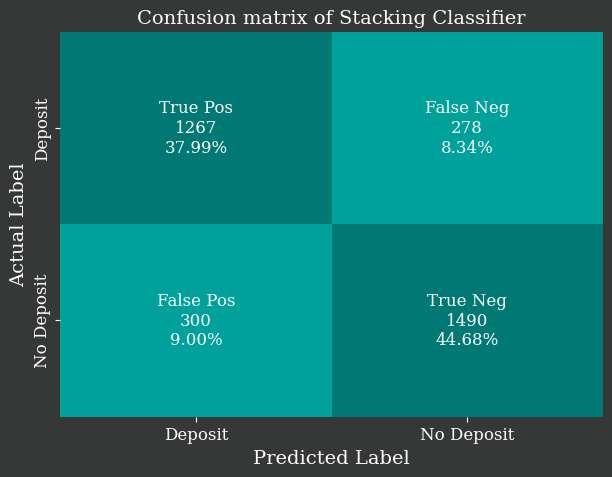

In [544]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
# создаем объект 
stacking = StackingClassifier(
                estimators=model_stack,
                final_estimator=linear_model.LogisticRegression(random_state=42))

# обучаем модель
stacking.fit(X_train_scaled, y_train)
# предсказываем таргет на тренировочных данных
y_train_pred = stacking.predict(X_train_scaled)
# выводим метрики модели на тренировочных данных
print('Значения метрик на трейне:\n')
print(metrics.classification_report(y_train, y_train_pred))

# предсказываем таргет на тестовых данных
stacking_y_pred = stacking.predict(X_test_scaled)
# выводим метриеи модели на тестовых данных 
print('Значения метрик на тесте:\n')
print(metrics.classification_report(y_test, stacking_y_pred))
# строим матрицу ошибок модели Gradient Boosting
stacking_cnf_mtx = confusion_matrix(y_test, stacking_y_pred, labels=[1,0])
# вызываем функцию визуализации матрицы ошибок модели Gradient Boosting
models_conf_mtx_plot(stacking_cnf_mtx, 'Confusion matrix of Stacking Classifier')

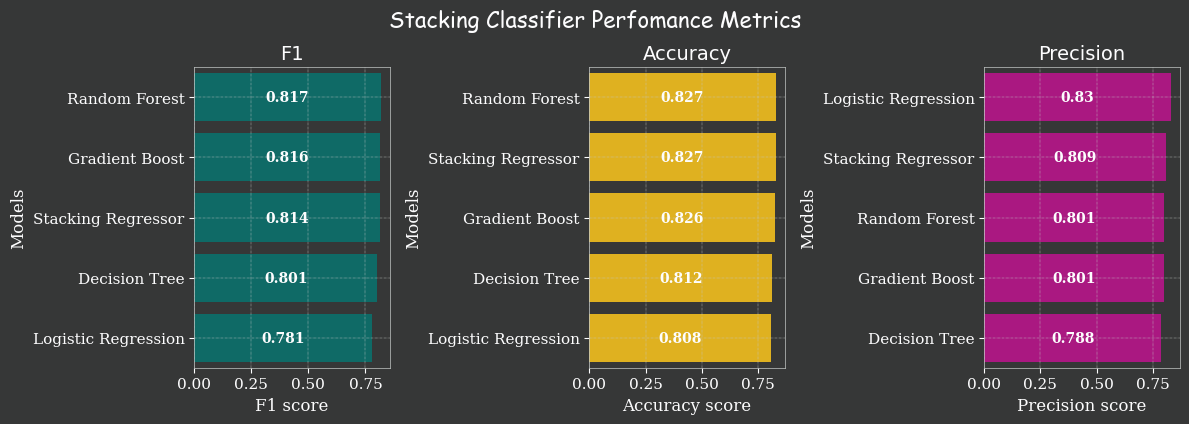

In [577]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))
fig.patch.set_facecolor('xkcd:dark grey')
ax1.set_facecolor('#363737')
f1_models = models_df.sort_values(by='F1 Score', ascending =False)
sns.barplot(x = f1_models['F1 Score'], 
            y = f1_models.index, 
            data = f1_models,
            ax = ax1,
            orient ='h', 
            color =  '#007974')

ax1.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax1.spines[['top', 'bottom', 'left', 'right']].set_color('#c5c9c7')
ax1.set_title('F1', fontsize=14, fontname = 'Sans', color = '#fdfdfe')
ax1.set_ylabel('Models', fontsize=12, color = '#fdfdfe')
ax1.set_xlabel('F1 score', fontsize=12, color = '#fdfdfe')
ax1.tick_params(axis='y', labelsize=11, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax1.tick_params(axis='x', labelsize=11, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax1.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)

for index, value in enumerate(f1_models['F1 Score']):
    ax1.text(value / 2 ,
            index,
            str(round(value, 3)),
            ha = 'center',
            va = 'center',
            size = 'medium',
            weight = 'semibold',
            color = '#fdfdfe'
            )
    
ax2.set_facecolor('#363737')
acc_models = models_df.sort_values(by='Accuracy', ascending = False)
sns.barplot(x = acc_models['Accuracy'], 
            y = acc_models.index, 
            data = acc_models,
            ax = ax2,
            orient ='h', 
            color =  '#ffc200')

ax2.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax2.spines[['top', 'bottom', 'left', 'right']].set_color('#c5c9c7')
ax2.set_title('Accuracy', fontsize=14, fontname = 'Sans', color = '#fdfdfe')
ax2.set_ylabel('Models', fontsize=12, color = '#fdfdfe')
ax2.set_xlabel('Accuracy score', fontsize=12, color = '#fdfdfe')
ax2.tick_params(axis='y', labelsize=11, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax2.tick_params(axis='x', labelsize=11, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax2.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)

for index, value in enumerate(acc_models['Accuracy']):
    ax2.text(value / 2,
            index,
            str(round(value, 3)),
            ha = 'center',
            va = 'center',
            size = 'medium',
            weight = 'semibold',
            color = '#fdfdfe'
            )
    
ax3.set_facecolor('#363737')
prc_models = models_df.sort_values(by='Precision', ascending = False)
sns.barplot(x = prc_models['Precision'], 
            y = prc_models.index, 
            data = prc_models,
            ax = ax3,
            orient ='h', 
            color = '#c2008c')

ax3.spines[['top', 'bottom', 'left', 'right']].set_linewidth(.5)
ax3.spines[['top', 'bottom', 'left', 'right']].set_color('#c5c9c7')
ax3.set_title('Precision', fontsize=14, fontname = 'Sans', color = '#fdfdfe')
ax3.set_ylabel('Models', fontsize=12, color = '#fdfdfe')
ax3.set_xlabel('Precision score', fontsize=12, color = '#fdfdfe')
ax3.tick_params(axis='y', labelsize=11, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax3.tick_params(axis='x', labelsize=11, color = '#fdfdfe', labelcolor = '#fdfdfe')
ax3.grid(color='#c5c9c7', linestyle='-.', linewidth=0.3)

for index, value in enumerate(prc_models['Precision']):
    ax3.text(value / 2,
            index,
            str(round(value, 3)),
            ha = 'center',
            va = 'center',
            size = 'medium',
            weight = 'semibold',
            color = '#fdfdfe'
            )
    
plt.tight_layout()
plt.suptitle('Stacking Classifier Perfomance Metrics',
            fontsize = 16,
            y = 1.05,
            color = '#fdfdfe',
            fontname = 'Comic Sans MS')

plt.show();
             

acc_models

In [576]:
acc_models

F1 Score  Accuracy  Precision
Random Forest           0.817     0.827      0.801
Stacking Regressor      0.814     0.827      0.809
Gradient Boost          0.816     0.826      0.801
Decision Tree           0.801     0.812      0.788
Logistic Regression     0.781     0.808      0.830

## BEST VARIANT STEK

In [141]:
# объедините уже известные вам алгоритмы с помощью стекинга 
# создаем список моделей 
models = [('Logistic Regression', linear_model.LogisticRegression(
                solver = 'sag', 
                random_state=42, 
                max_iter=1000)
          ),
           ('Decision Tree', tree.DecisionTreeClassifier(
                criterion='gini',
                max_depth=9,
                min_samples_leaf = 5,
                min_samples_split = 10, 
                random_state=42)
           ),
           ('Random Forest', ensemble.RandomForestClassifier(
                n_estimators=200, 
                criterion='entropy',
                max_features = 'auto',  
                max_depth=8,
                random_state=43)
           ),
           ('Gradient Boost', GradientBoostingClassifier(
                n_estimators=100, 
                learning_rate=0.1, 
                random_state=42)
           )
           ]
# создаем объект Stacking Classifier
stacking = StackingClassifier(
                estimators=models,
                final_estimator=linear_model.LogisticRegression(random_state=42))


print('Показатели метрик моделей:\n')

for (name, est) in  (models+[('Stacking Regressor',stacking)]):
    model = est.fit(X_train_scaled, y_train)
    pred_train = model.predict(X_train_scaled)
    pred_test = model.predict(X_test_scaled)
    #f1_score_train = np.round(metrics.f1_score(y_train, pred_train),3)
    #accuracy_train = np.round(metrics.accuracy_score(y_train, pred_train),3)
    f1_score_test = np.round(metrics.f1_score(y_test, pred_test),3)
    accuracy_test = np.round(metrics.accuracy_score(y_test, pred_test),3)
    print(name)
    #print('accuracy train -{}'.format(accuracy_train), '\naccuracy test -{}'.format(accuracy_test))
    print('f1 score test- {}'.format(f1_score_test), '\naccuracy test -{}'.format(accuracy_test))
    #print('f1 score - {}'.format(f1_score_train), '\naccuracy -{}'.format(accuracy_train))
    #print('f1 score - {}'.format(f1_score_test), '\naccuracy -{}'.format(accuracy_test))
    print('=='*20)




Показатели метрик моделей:

Logistic Regression
f1 score test- 0.781 
accuracy test -0.808
Decision Tree
f1 score test- 0.797 
accuracy test -0.812
Random Forest
f1 score test- 0.817 
accuracy test -0.827
Gradient Boost
f1 score test- 0.813 
accuracy test -0.825
Stacking Regressor
f1 score test- 0.816 
accuracy test -0.828


Мы видим, что лучшие метрики показали две модели Random Forest и Stacking Regressor

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

n_estimators = trial.suggest_int('n_estimators', 100, 200, 1),
max_depth = trial.suggest_int('max_depth', 10, 30, 1),
min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

In [529]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
  
    model = ensemble.RandomForestClassifier(n_estimators = n_estimators,
                                            max_depth = max_depth,
                                            min_samples_leaf = min_samples_leaf,
                                            random_state=42)
    
    
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))

    return score

study = optuna.create_study(study_name = 'RandomForestClassifier', direction = 'maximize')

study.optimize(objective, n_trials=27)
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)

print("accuracy на тренировочном наборе: {:.2f}".format(model.score(X_train_scaled, y_train)))
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2023-09-23 00:39:39,603] A new study created in memory with name: RandomForestClassifier
[I 2023-09-23 00:39:40,763] Trial 0 finished with value: 0.8671482412060302 and parameters: {'n_estimators': 139, 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8671482412060302.
[I 2023-09-23 00:39:42,466] Trial 1 finished with value: 0.9245757385292268 and parameters: {'n_estimators': 171, 'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9245757385292268.
[I 2023-09-23 00:39:43,532] Trial 2 finished with value: 0.876446668751955 and parameters: {'n_estimators': 137, 'max_depth': 14, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9245757385292268.
[I 2023-09-23 00:39:44,580] Trial 3 finished with value: 0.866635323616988 and parameters: {'n_estimators': 134, 'max_depth': 12, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9245757385292268.
[I 2023-09-23 00:39:45,372] Trial 4 finished with value: 0.8537350910232266 and parameters: {'n_es

accuracy на тренировочном наборе: 0.93
f1_score на тренировочном наборе: 0.92
accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82


In [566]:
fig= plt.figure(figsize=(12,4))
fig = optuna.visualization.plot_param_importances(study)
fig.show();

<Figure size 1200x400 with 0 Axes>

In [567]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show();

In [537]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 33, 99, 1)
    max_depth = trial.suggest_int('max_depth', 5, 35, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 6, 1)
    
  
    model = ensemble.RandomForestClassifier(n_estimators = n_estimators,
                                            max_depth = max_depth,
                                            min_samples_leaf = min_samples_leaf,
                                            random_state=42)
    
    
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))

    return score

study2 = optuna.create_study(study_name = 'RandomForestClassifier', direction = 'maximize')

study2.optimize(objective, n_trials=99)
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)

print("accuracy на тренировочном наборе: {:.3f}".format(model.score(X_train_scaled, y_train)))
print('f1_score на тренировочном наборе: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test_scaled)
print("accuracy на тестовом наборе: {:.3f}".format(model.score(X_test_scaled, y_test)))
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2023-09-23 00:42:47,983] A new study created in memory with name: RandomForestClassifier
[I 2023-09-23 00:42:48,416] Trial 0 finished with value: 0.8588363749805021 and parameters: {'n_estimators': 46, 'max_depth': 26, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8588363749805021.
[I 2023-09-23 00:42:48,991] Trial 1 finished with value: 0.9018867924528301 and parameters: {'n_estimators': 62, 'max_depth': 16, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9018867924528301.
[I 2023-09-23 00:42:49,359] Trial 2 finished with value: 0.8763625038928683 and parameters: {'n_estimators': 46, 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9018867924528301.
[I 2023-09-23 00:42:49,981] Trial 3 finished with value: 0.8907300297014225 and parameters: {'n_estimators': 73, 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9018867924528301.
[I 2023-09-23 00:42:50,311] Trial 4 finished with value: 0.8554047730463268 and parameters: {'n_esti

accuracy на тренировочном наборе: 0.929
f1_score на тренировочном наборе: 0.925
accuracy на тестовом наборе: 0.828
f1_score на тестовом наборе: 0.820


In [538]:
fig= plt.figure(figsize=(13,7))
fig = optuna.visualization.plot_param_importances(study2)
fig.show()

<Figure size 1300x700 with 0 Axes>

In [539]:
fig = optuna.visualization.plot_optimization_history(study2)
fig.show();

In [516]:
study.best_params

{'n_estimators': 46, 'max_depth': 28, 'min_samples_leaf': 2}

In [517]:
study.best_value

0.9250906797035169

In [526]:
fig= plt.figure(figsize=(13,7))
fig = optuna.visualization.plot_param_importances(study)
fig.show()

<Figure size 1300x700 with 0 Axes>

In [528]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [142]:
optuna.visualization.plot_slice(study)